# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [1]:
# install package for displaying animation
!pip install JSAnimation
import numpy as np

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



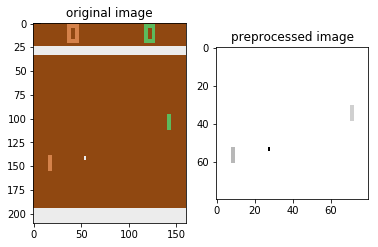

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):
    """ Define a policy based on a neural network
    """

    def __init__(self):
        """ Init of class Policy()
        
            INPUTS:
            ------------
                None
                
            OUTPUTS:
            ------------
                No direct
        """
        
        super(Policy, self).__init__()
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # conv1 80x80 --> 40x40 (due to stride=2)
        self.conv1 = nn.Conv2d(2, 4, kernel_size=2, stride=2)
        # conv2 40x40 --> 20x20 (due to stride=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride=2)
        # conv3 20x20 --> 10x10 (due to stride=2)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=2, stride=2)
        self.size=16*10*10
        
        # 3 fully connected layer
        self.fc1 = nn.Linear(self.size, 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        """ Forward path of neural network
        
            INPUTS:
            ------------
                x - (torch tensor) shape torch.Size([1, 2, 80, 80]) 
                    1 --> number of parallel instances, up to 4 at the moment
                    2 --> two consecutive stacked frames
                    80x80 --> pixel width and height
                
            OUTPUTS:
            ------------
                x - (torch tensor) shape torch.Size([1, 1]) - Probability to choose RIGHT as action
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # flatten the tensor
        x = x.view(-1,self.size)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x

# use your own policy!
policy=Policy().to(device)
print(policy)

#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

Policy(
  (conv1): Conv2d(2, 4, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=1600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (sig): Sigmoid()
)


# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


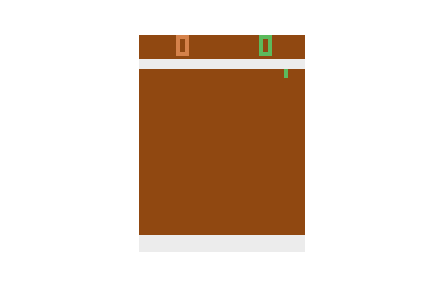
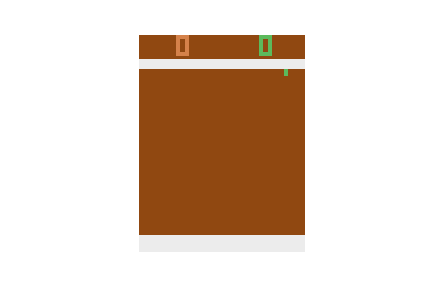
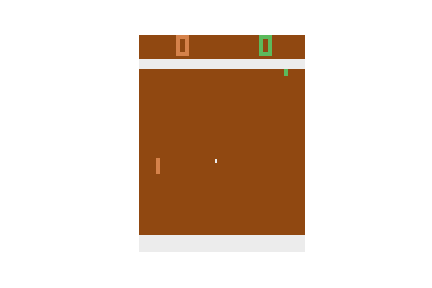
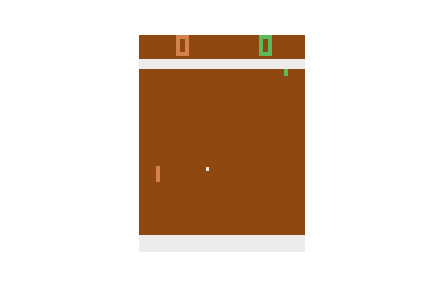
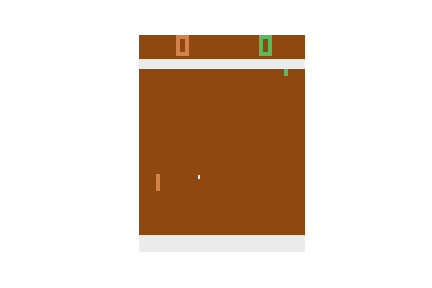
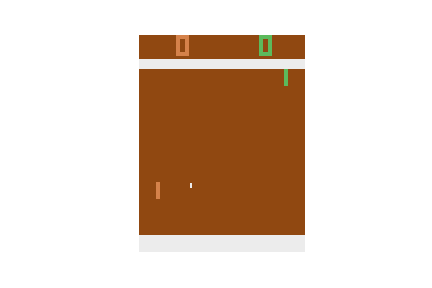
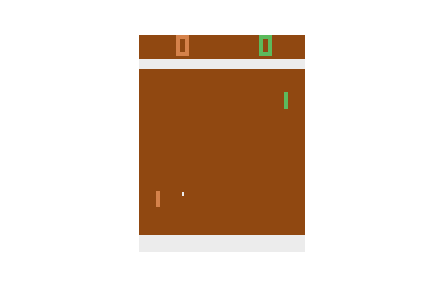
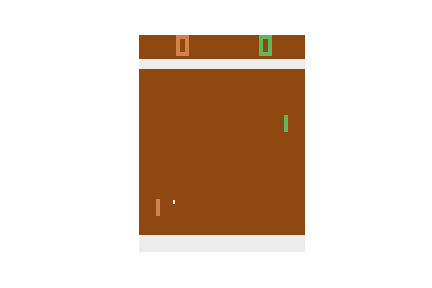
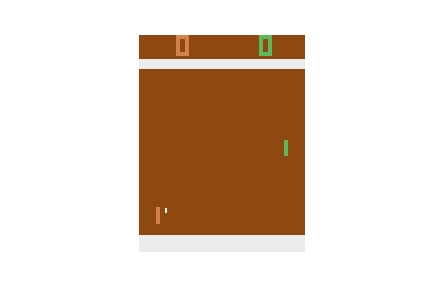
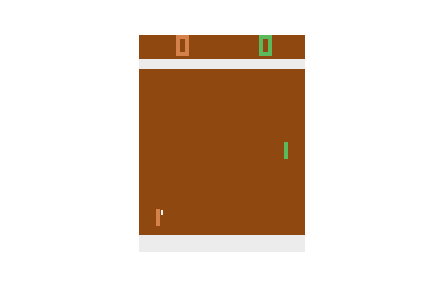
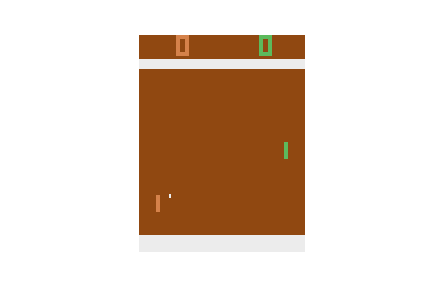
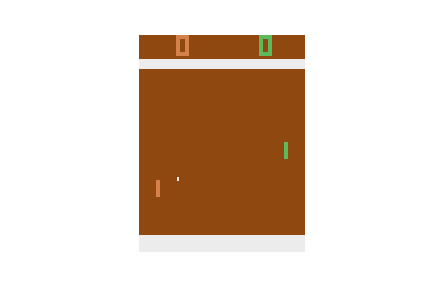
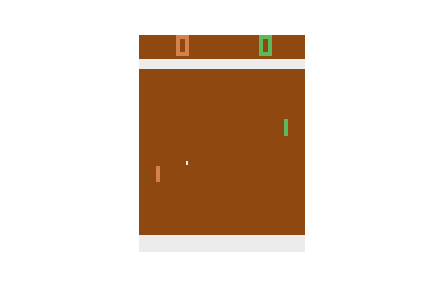
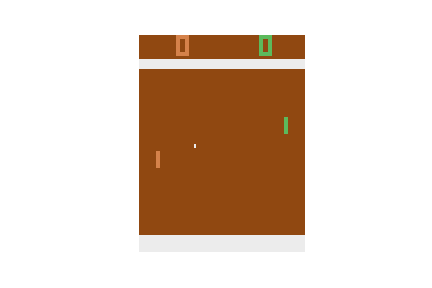
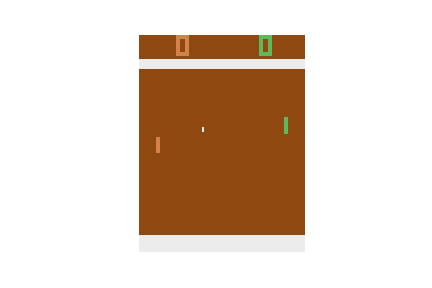
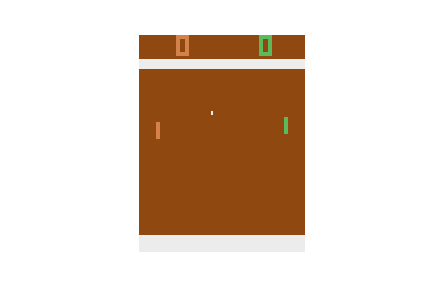
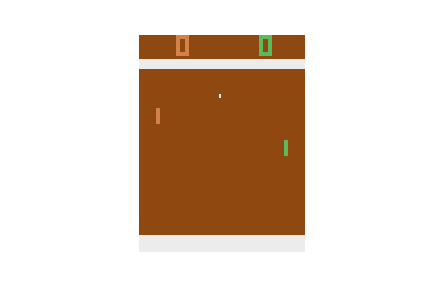
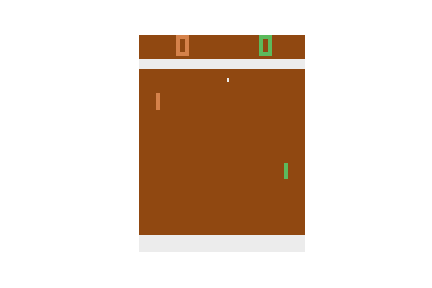
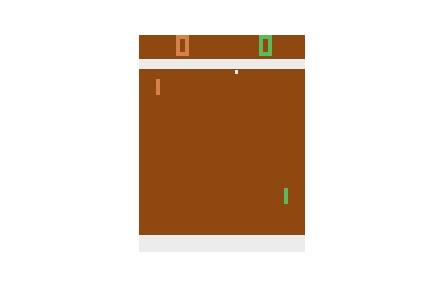
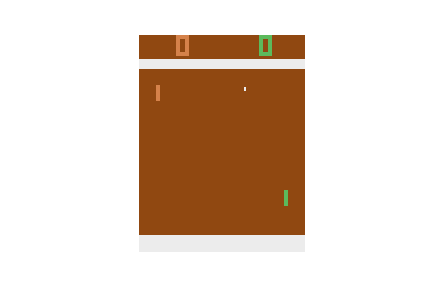
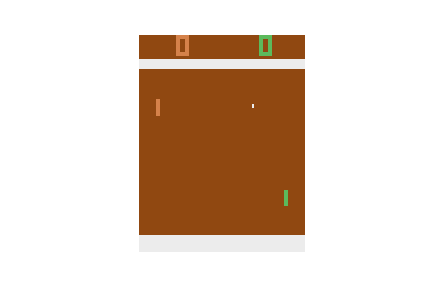
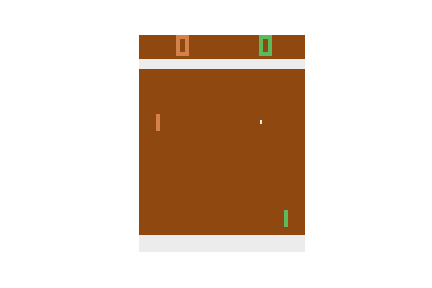
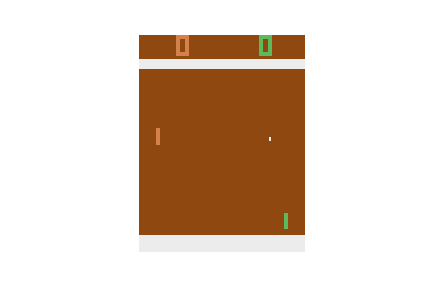
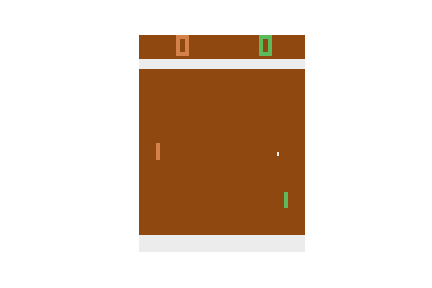
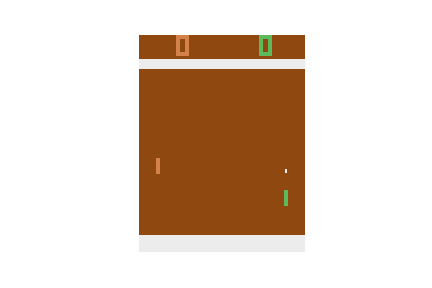
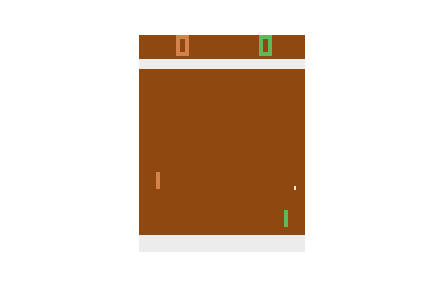
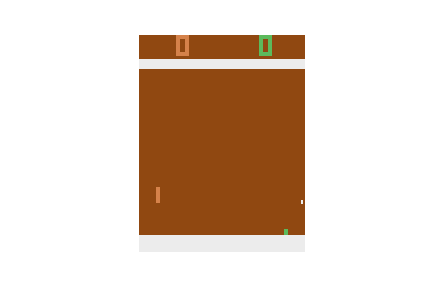
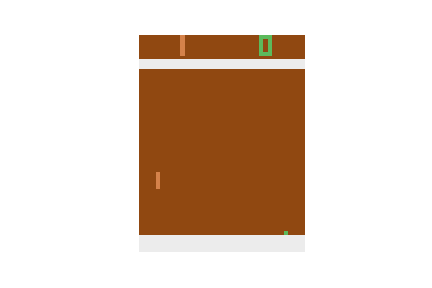
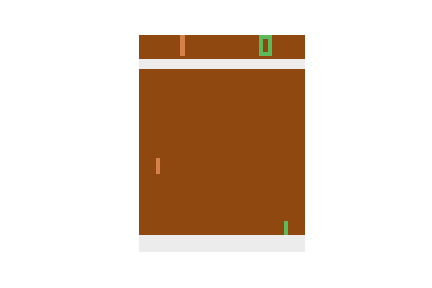
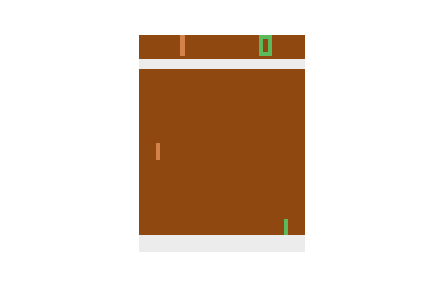
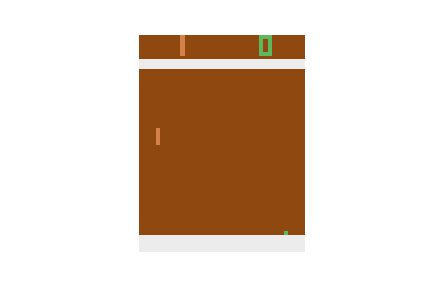
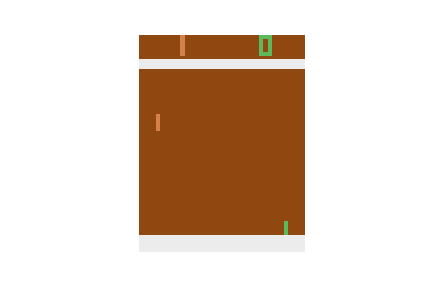
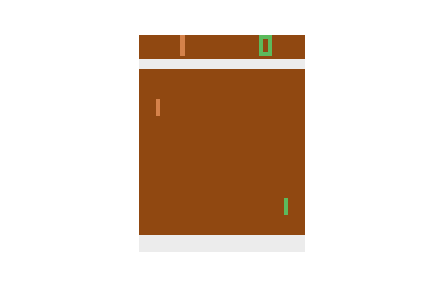
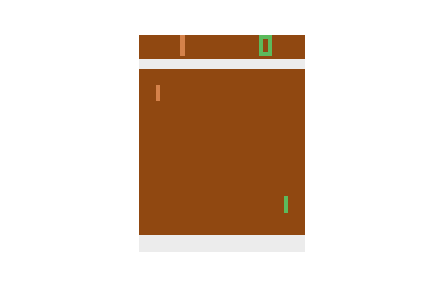
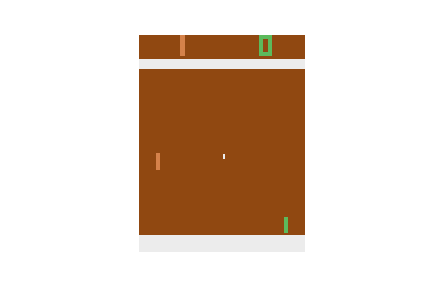
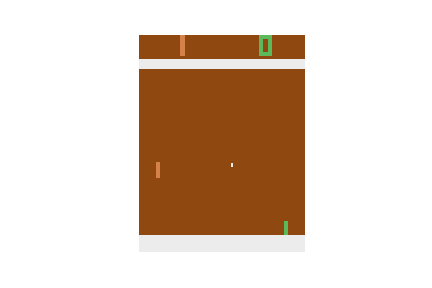
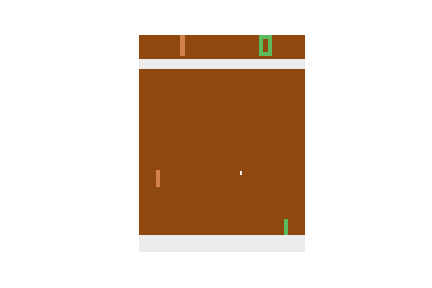
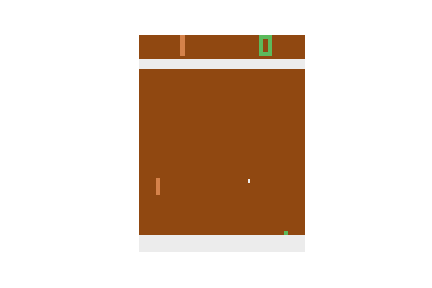
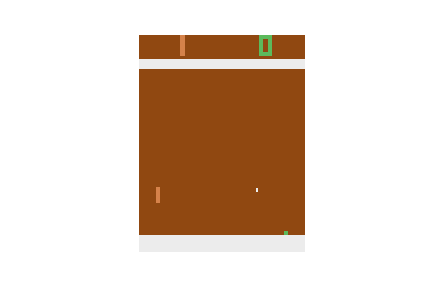
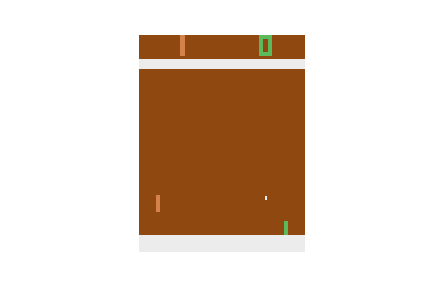
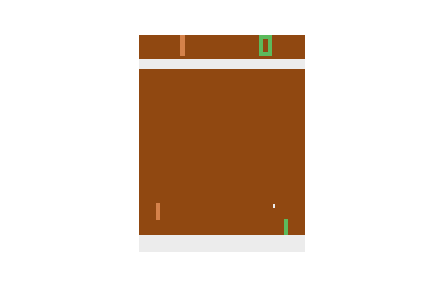
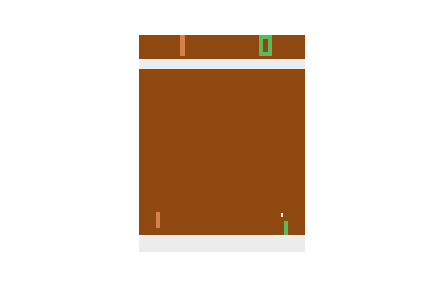
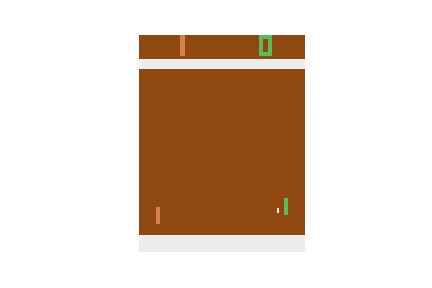
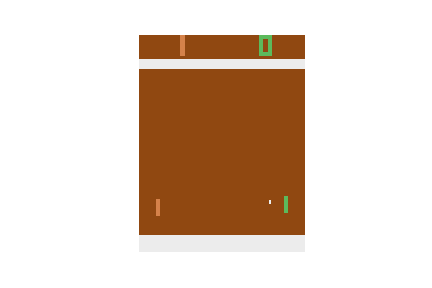
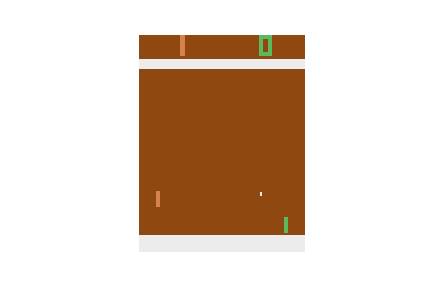
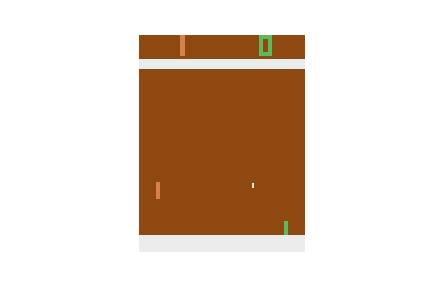
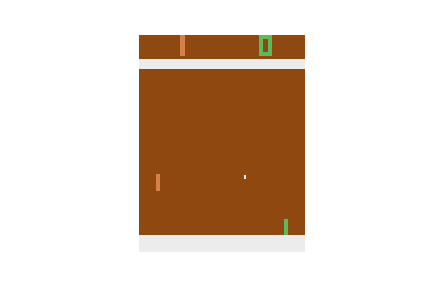
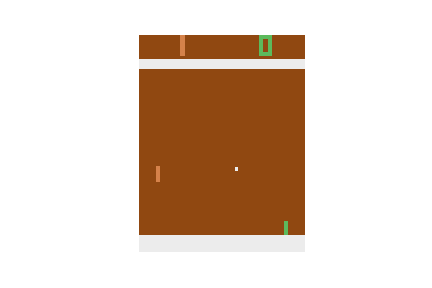
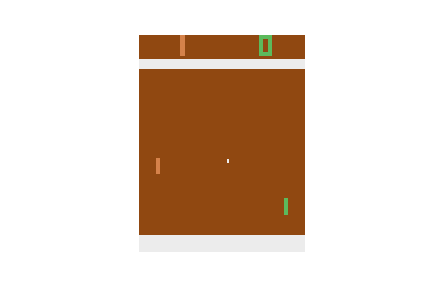
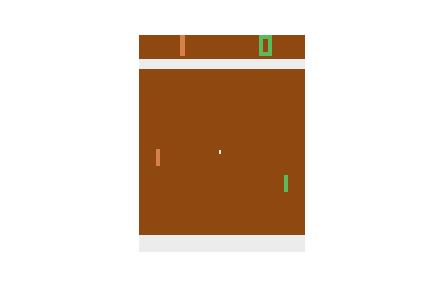
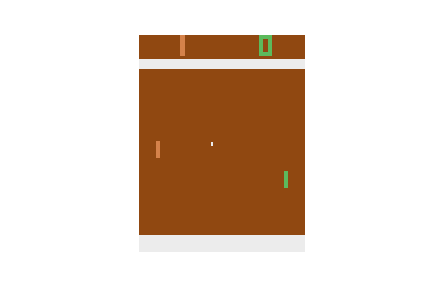
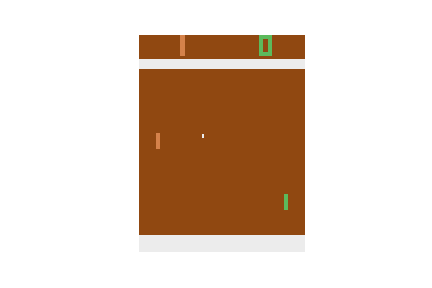
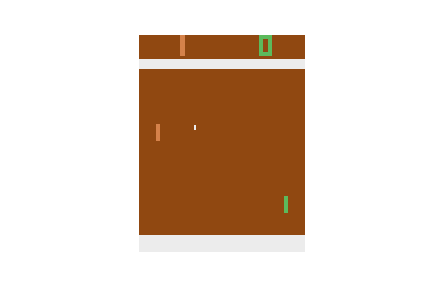
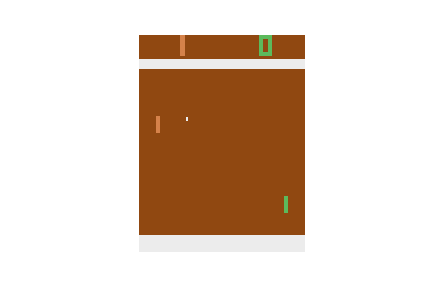
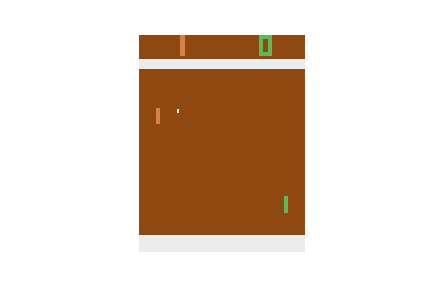
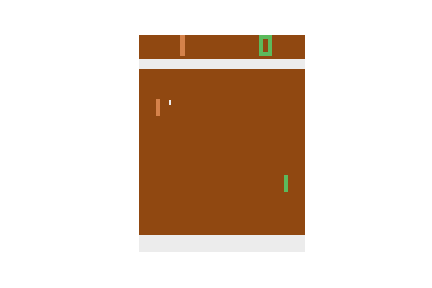
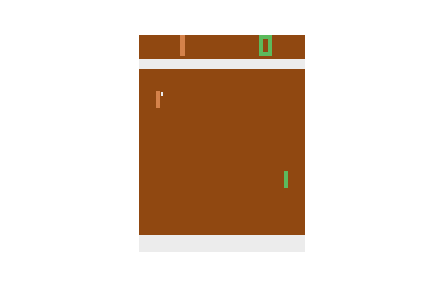
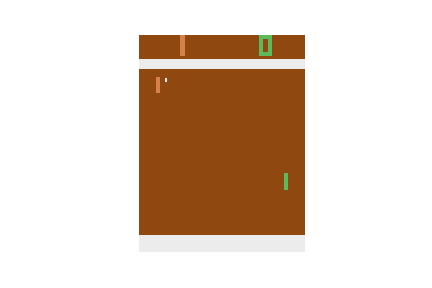
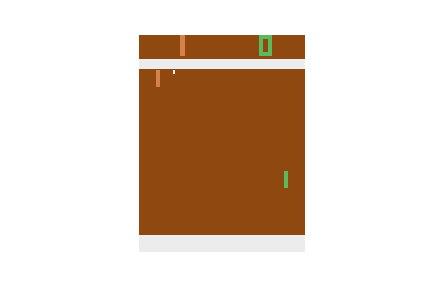
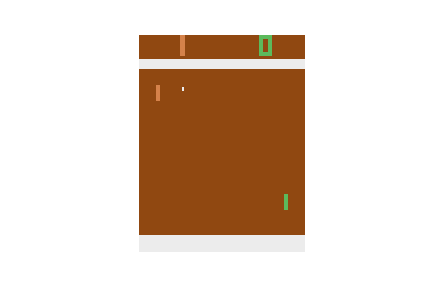
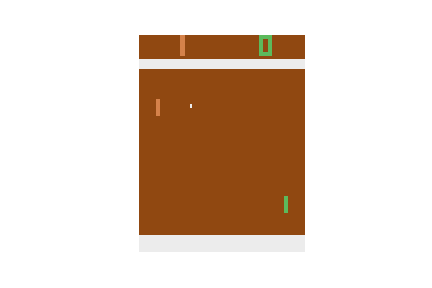
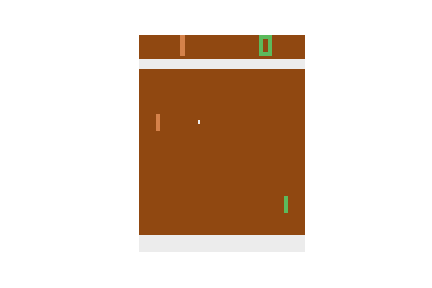
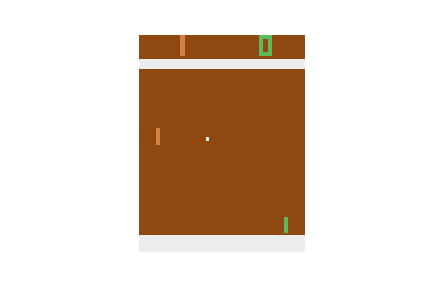
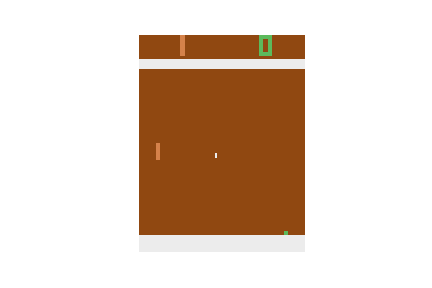
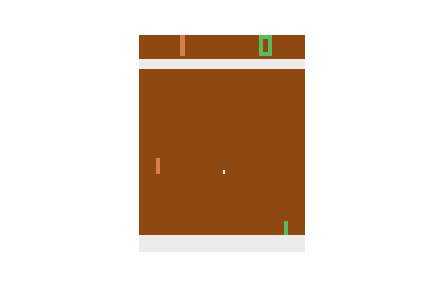
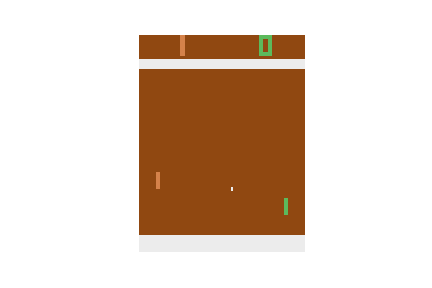
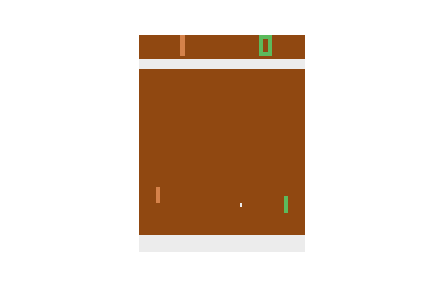
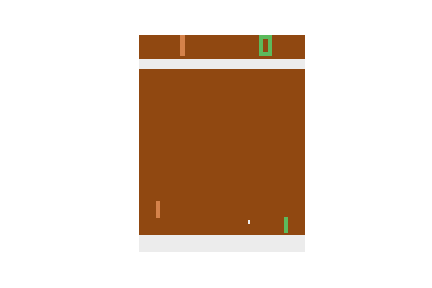
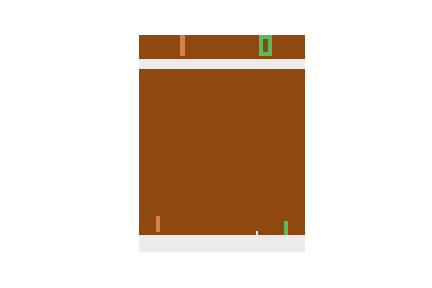
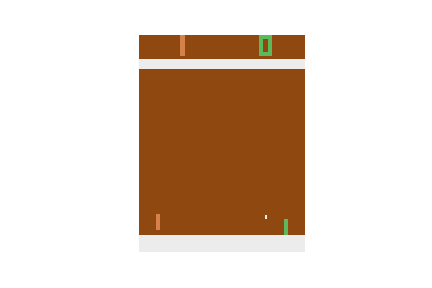
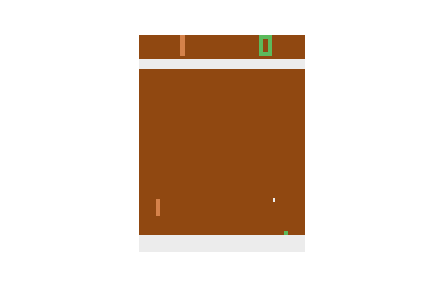
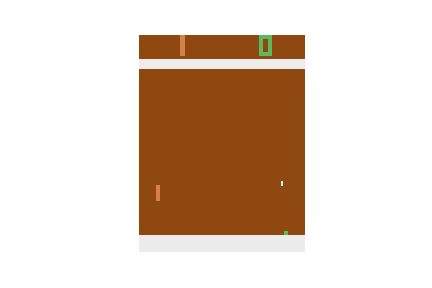
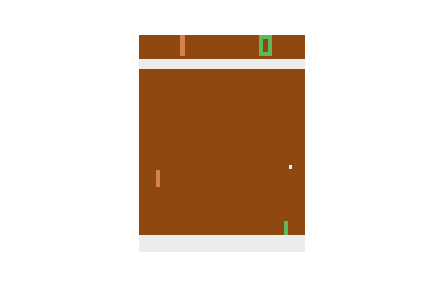
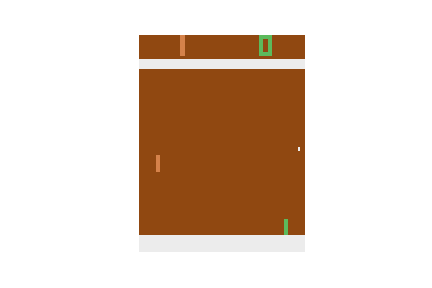
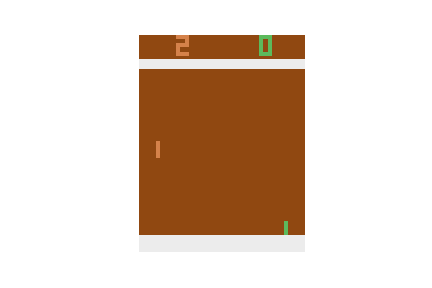
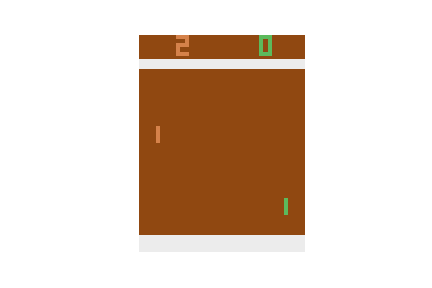
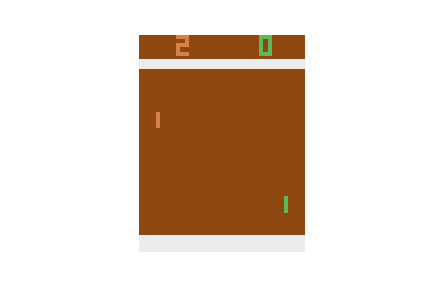
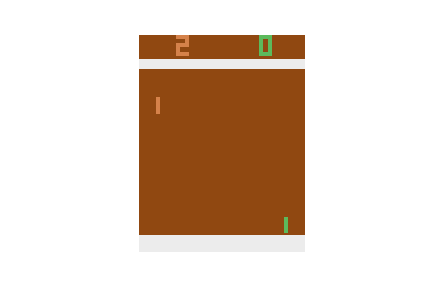
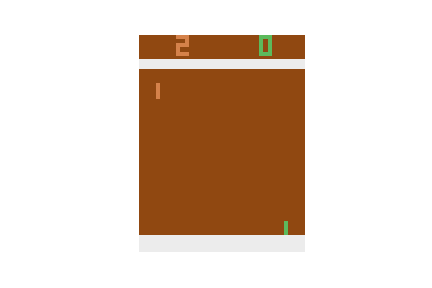
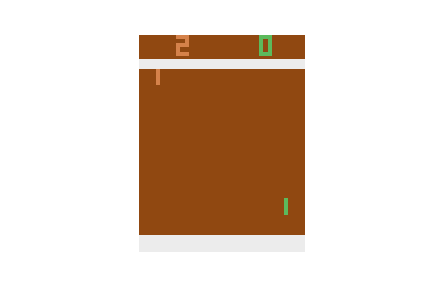
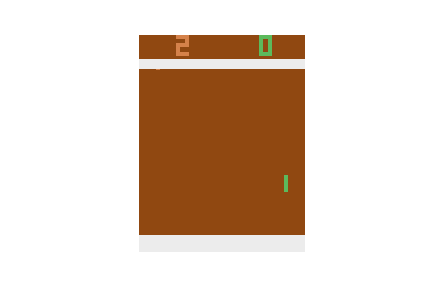
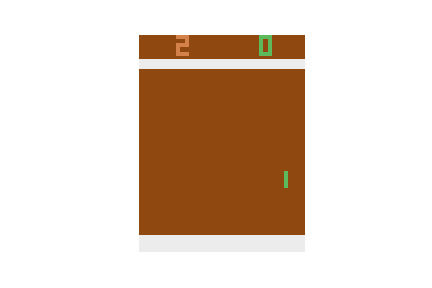
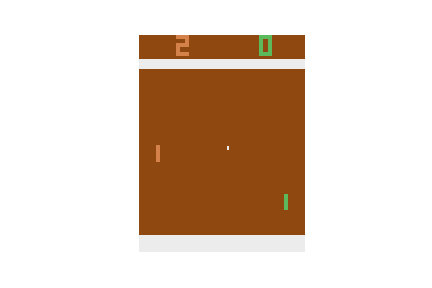
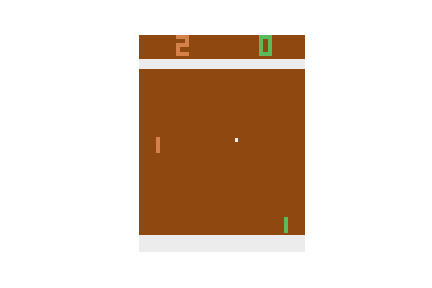
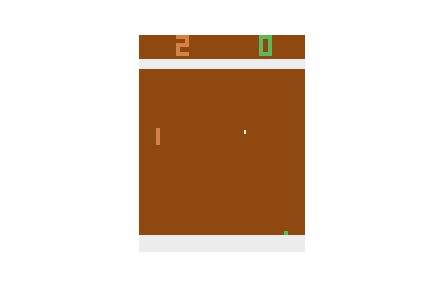
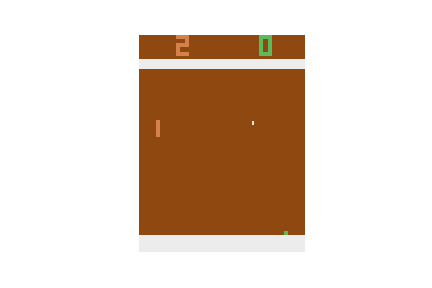
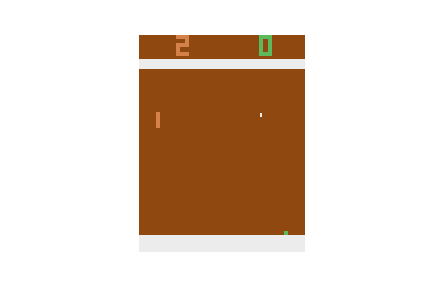
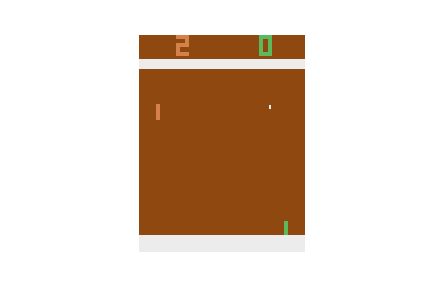
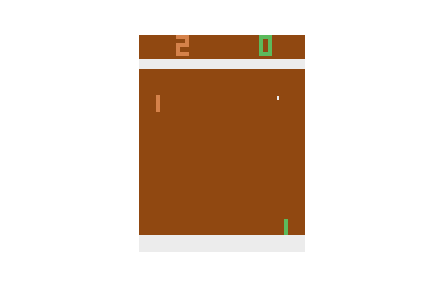
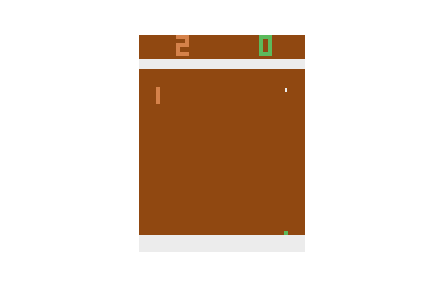
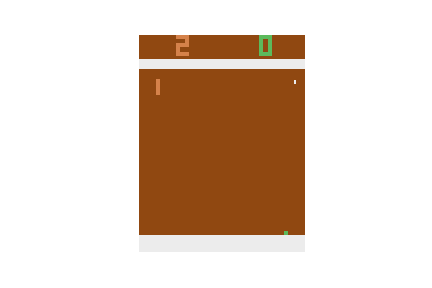
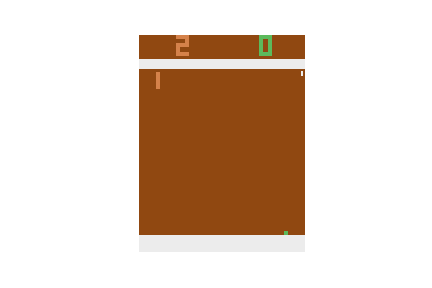
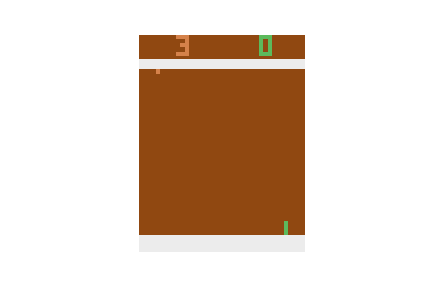
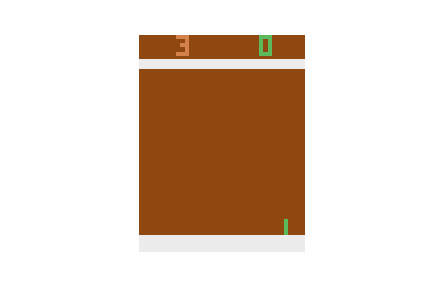
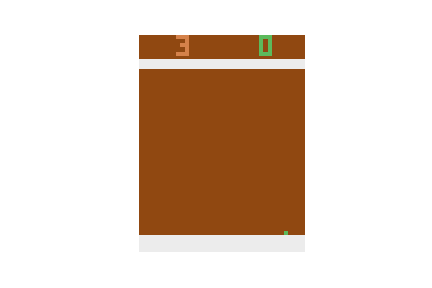
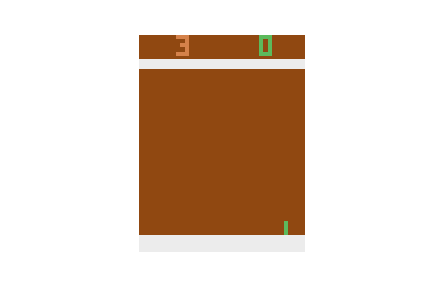
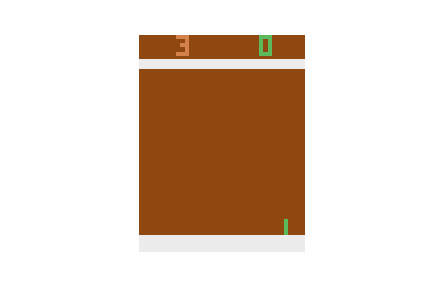
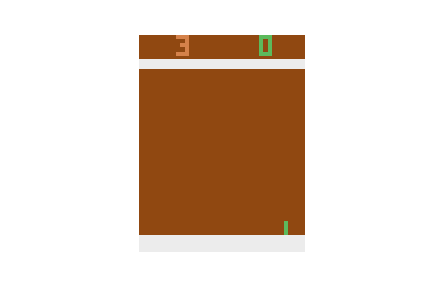
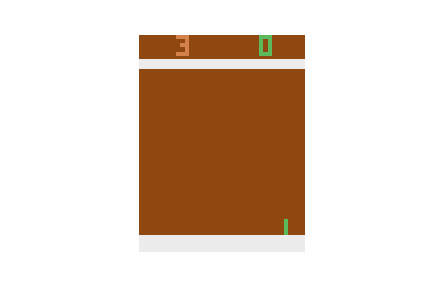
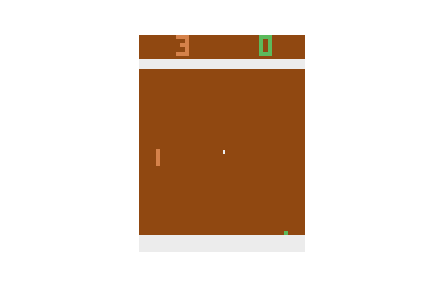

In [5]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [7]:
print(reward)
print()
print('Length trajectory:', len(reward))

[array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([-1., -1., -1., -1.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [8]:
RIGHT=4
LEFT=5
# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    """ Convert states to probability
    
        INPUTS:
        -------------
            policy - (instance of Policy class) definition of a neural network
            states - (list of torch tensor) states[0] shape torch.Size([4, 2, 80, 80])
                     len of list = tmax from collecting trajectories          
        
        OUTPUTS:
        -------------
            policy_output - (torch tensor) shape torch.Size([tmax, 4]), tmax from collecting trajectories   
    """
    
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    
    policy_output = policy(policy_input).view(states.shape[:-3])
    
    return policy_output

def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):
    """ 
        INPUTS:
        ------------
            policy - (instance of Policy class) definition of a neural network, see policy model above
            old_probs - () 
            states - ()
            actions - ()
            rewards - ()
            discount - ()= 0.995
            beta - ()=0.01
        
        OUTPUTS:
        ------------
    """
    
    discount = discount**np.arange(len(rewards))
   
    
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]

    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
   
    ratio = new_probs/old_probs
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    surrogate = torch.mean(ratio*rewards + beta*entropy)

    return surrogate


Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(1.00000e-03 *
       6.8200)


In [9]:
def surrogate_describe(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):
    """ Function 
    
        INPUTS:
        ------------
            policy - (instance of Policy class) definition of a neural network
            old_probs - (list of numpy arrays) 
                        like [array([ 0.47297633,  0.52704322,  0.52703786,  0.52704197], dtype=float32), array([...]), ...] 
                        len of list = tmax from collecting trajectories
            states - (list of torch tensor) states[0] shape torch.Size([4, 2, 80, 80])
                        len of list = tmax from collecting trajectories          
            actions - (list of numpy arrays)like [array([4, 5, 5, 5]), array([4, 4, 5, 5]), array([5, 4, 4, 5]), array([5, 4, 4, 4]), array([5, 4, 5, 5])]
                        actions[0] shape (4,)
                        len of list = tmax from collecting trajectories   
            rewards - (list of numpy arrays) like array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.])]
                        rewards[0] shape (4,)
                        len of list = tmax from collecting trajectories   
            discount - (float) default = 0.995
            beta - (float) default = 0.01
        
        OUTPUTS:
        ------------
            surrogate - (torch tensor) like tensor(1.00000e-03 * 6.9168)
                        surrogate shape torch.Size([])
    """
    print('INPUT')
    print('-----------')
    print()
    print('policy', policy)
    print()
    print('old_probs', old_probs)
    print('old_probs len', len(old_probs))
    print()
    print('states', states)
    print('states len', len(states))
    print('states[0] shape', states[0].shape)
    print()
    print('actions', actions)
    print('actions len', len(actions))
    print('actions[0] shape', actions[0].shape)
    print()
    print('rewards', rewards)
    print('rewards len', len(rewards))
    print('rewards[0] shape', rewards[0].shape)
    print()
    print('discount', discount)
    print()
    print('beta', beta)
    print()

    # discount numpy array like [ 1.  0.995  0.990025  0.98507488  0.9801495 ] --> shape (tmax,)
    discount = discount**np.arange(len(rewards))
    print('discount', discount)
    print('discount shape', discount.shape)
    print()
    
    # rewards numpy array like
    # [[ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]]
    # rewards shape (5, 4)
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    print('rewards', rewards)
    print('rewards shape', rewards.shape)
    print()
    
    # convert rewards to rewards_future like
    # [[ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]]
    # rewards_future shape (5, 4)
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    print('rewards_future', rewards_future)
    print('rewards_future shape', rewards_future.shape)
    print()
    
    # mean like [ 0.  0.  0.  0.  0.]
    # mean shape (5,)
    mean = np.mean(rewards_future, axis=1)
    print('mean', mean)
    print('mean shape', mean.shape)
    print()
    
    # std like [1.00000000e-10  1.00000000e-10  1.00000000e-10  1.00000000e-10  1.00000000e-10]
    # std shape (5,)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    print('std', std)
    print('std shape', std.shape)
    print()

    # rewards_normalized [[ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]
    # [ 0.  0.  0.  0.]]
    # rewards_normalized shape (5, 4)
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    print('rewards_normalized', rewards_normalized)
    print('rewards_normalized shape', rewards_normalized.shape)
    print()
    
    # convert everything into pytorch tensors and move to gpu if available
    # actions like
    # tensor([[ 4,  5,  5,  5],
    #        [ 4,  4,  5,  5],
    #        [ 5,  4,  4,  5],
    #        [ 5,  4,  4,  4],
    #        [ 5,  4,  5,  5]], dtype=torch.int8)
    # actions shape torch.Size([5, 4])
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    
    # old_probs like
    # tensor([[ 0.4730,  0.5270,  0.5270,  0.5270],
    #        [ 0.4729,  0.4729,  0.5270,  0.5271],
    #        [ 0.5271,  0.4729,  0.4729,  0.5270],
    #        [ 0.5271,  0.4730,  0.4730,  0.4730],
    #        [ 0.5270,  0.4730,  0.5270,  0.5270]])
    # old_probs shape torch.Size([5, 4])
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    
    # rewards like
    # tensor([[ 0.,  0.,  0.,  0.],
    #        [ 0.,  0.,  0.,  0.],
    #        [ 0.,  0.,  0.,  0.],
    #        [ 0.,  0.,  0.,  0.],
    #        [ 0.,  0.,  0.,  0.]])
    # rewards shape torch.Size([5, 4])
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    print('actions', actions)
    print('actions shape', actions.shape)
    print()
    print('old_probs', old_probs)
    print('old_probs shape', old_probs.shape)
    print()
    print('rewards', rewards)
    print('rewards shape', rewards.shape)
    print()
    
    # convert states to policy (or probability) like
    # tensor([[ 0.4730,  0.5270,  0.5270,  0.5270],
    #        [ 0.4729,  0.4729,  0.5270,  0.5271],
    #        [ 0.5271,  0.4729,  0.4729,  0.5270],
    #        [ 0.5271,  0.4730,  0.4730,  0.4730],
    #        [ 0.5270,  0.4730,  0.5270,  0.5270]])
    # new_probs shape torch.Size([5, 4])
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    print('new_probs ', new_probs)
    print('new_probs shape', new_probs.shape)
    print()
    
    # ratio like 
    # tensor([[ 1.0000,  1.0000,  1.0000,  1.0000],
    #        [ 1.0000,  1.0000,  1.0000,  1.0000],
    #        [ 1.0000,  1.0000,  1.0000,  1.0000],
    #        [ 1.0000,  1.0000,  1.0000,  1.0000],
    #        [ 1.0000,  1.0000,  1.0000,  1.0000]])
    # ratio shape torch.Size([5, 4])
    ratio = new_probs/old_probs
    
    print('ratio ', ratio)
    print('ratio shape', ratio.shape)
    print()

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    
    # entropy like
    # tensor([[ 0.6917,  0.6917,  0.6917,  0.6917],
    #        [ 0.6917,  0.6917,  0.6917,  0.6917],
    #        [ 0.6917,  0.6917,  0.6917,  0.6917],
    #        [ 0.6917,  0.6917,  0.6917,  0.6917],
    #        [ 0.6917,  0.6917,  0.6917,  0.6917]])
    # entropy shape torch.Size([5, 4])
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    print('entropy ', entropy)
    print('entropy shape', entropy.shape)
    print()
    
    # surrogate  
    # tensor(1.00000e-03 * 6.9168)
    # surrogate shape torch.Size([])
    surrogate = torch.mean(ratio*rewards + beta*entropy)
    
    print('surrogate ', surrogate)
    print('surrogate shape', surrogate.shape)
    print()

    return surrogate


Lsur= surrogate_describe(policy, prob, state, action, reward)

print(Lsur)

INPUT
-----------

policy Policy(
  (conv1): Conv2d(2, 4, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=1600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (sig): Sigmoid()
)

old_probs [array([ 0.57453328,  0.57452917,  0.57453328,  0.57453203], dtype=float32), array([ 0.42546391,  0.57453489,  0.42546391,  0.57453609], dtype=float32), array([ 0.42546383,  0.57453316,  0.5745362 ,  0.4254674 ], dtype=float32), array([ 0.42548361,  0.57449102,  0.42549139,  0.42549825], dtype=float32), array([ 0.57451272,  0.42548591,  0.57452393,  0.57452261], dtype=float32), array([ 0.5745368 ,  0.57452846,  0.42544812,  0.42544812], dtype=float32), array([ 0.57452834,  0.57448459,  0.42548761,  0.42548761], dtype=float32), array([ 0.42548656,  0.57449377,  0.42548651

new_probs  tensor([[ 0.5745,  0.5745,  0.5745,  0.5745],
        [ 0.4255,  0.5745,  0.4255,  0.5745],
        [ 0.4255,  0.5745,  0.5745,  0.4255],
        [ 0.4255,  0.5745,  0.4255,  0.4255],
        [ 0.5745,  0.4255,  0.5745,  0.5745],
        [ 0.5745,  0.5745,  0.4254,  0.4254],
        [ 0.5745,  0.5745,  0.4255,  0.4255],
        [ 0.4255,  0.5745,  0.4255,  0.4255],
        [ 0.5745,  0.5745,  0.4255,  0.5745],
        [ 0.5746,  0.5745,  0.5745,  0.5745],
        [ 0.4255,  0.4255,  0.4255,  0.4254],
        [ 0.5745,  0.5745,  0.5745,  0.5745],
        [ 0.5745,  0.4255,  0.4255,  0.4255],
        [ 0.4255,  0.4255,  0.4255,  0.5745],
        [ 0.4255,  0.5745,  0.5745,  0.4255],
        [ 0.4255,  0.4255,  0.5745,  0.4255],
        [ 0.5745,  0.5745,  0.5745,  0.5745],
        [ 0.5745,  0.4255,  0.5746,  0.5745],
        [ 0.4255,  0.5745,  0.4255,  0.4255],
        [ 0.4254,  0.4254,  0.4254,  0.4254],
        [ 0.4254,  0.5746,  0.4254,  0.5746],
        [ 0.5745,  0.42

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [10]:
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 100
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    #L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

Episode: 20, score: -14.375000
[-15. -14. -16. -14. -14. -14. -16. -12.]


Episode: 40, score: -14.625000
[-10. -13. -16. -16. -16. -16. -16. -14.]


Episode: 60, score: -13.625000
[-12. -14. -13. -14. -14. -12. -15. -15.]


Episode: 80, score: -13.625000
[-16. -16. -16. -13.  -7. -10. -16. -15.]


Episode: 100, score: -14.125000
[-11. -16. -12. -16. -11. -15. -16. -16.]



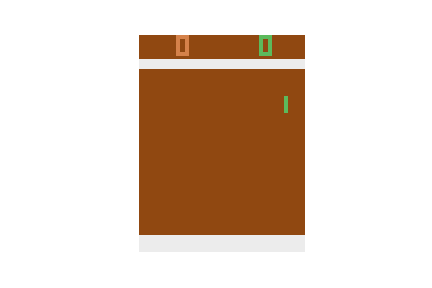
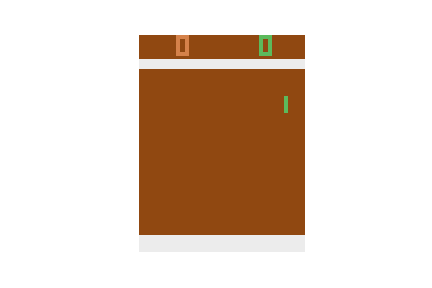
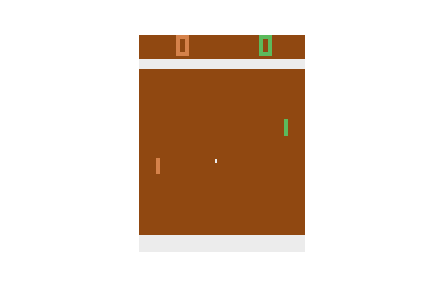
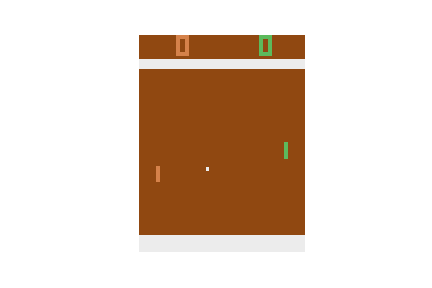
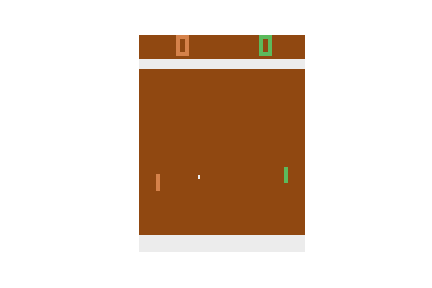
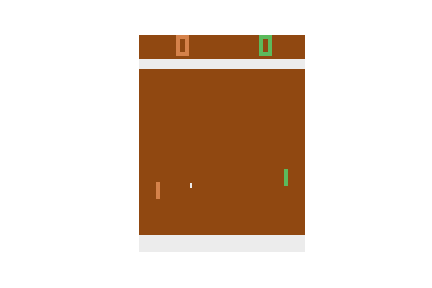
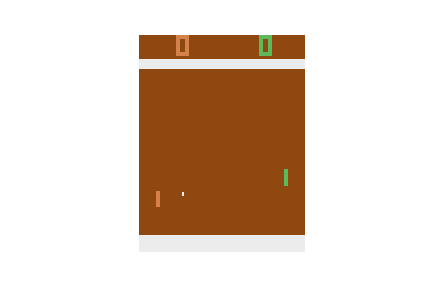
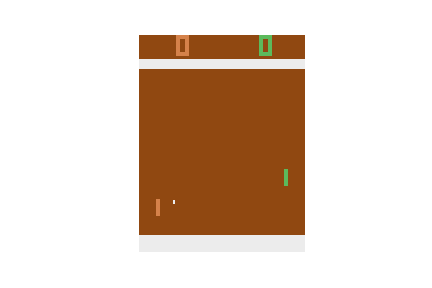
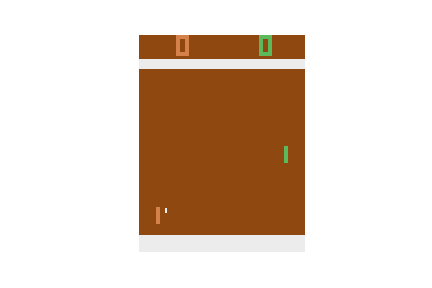
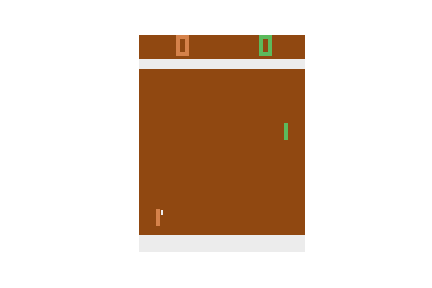
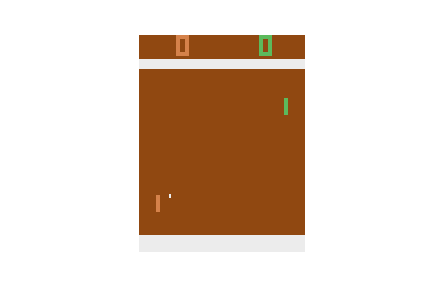
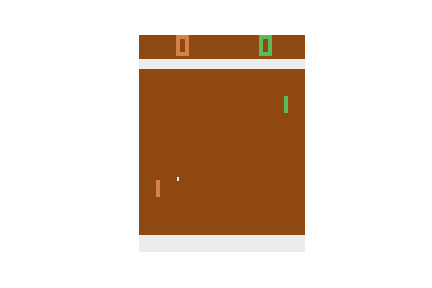
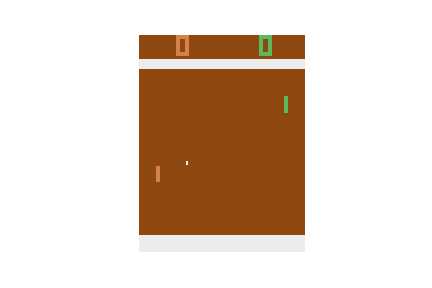
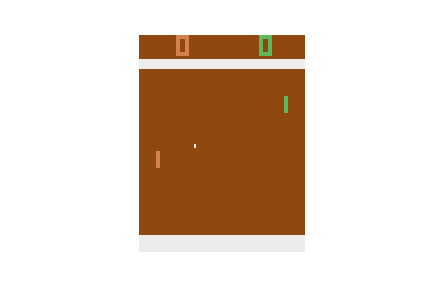
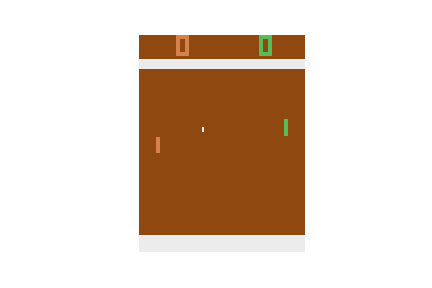
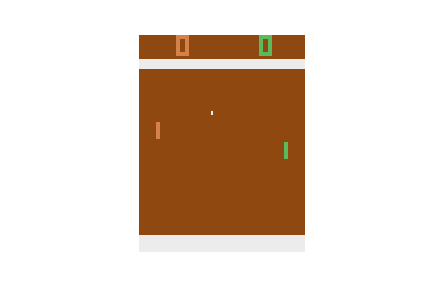
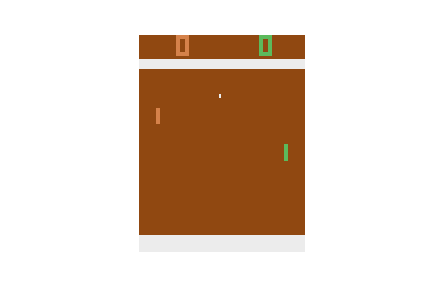
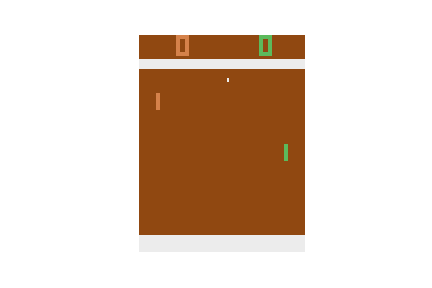
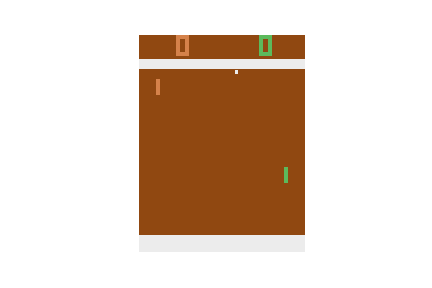
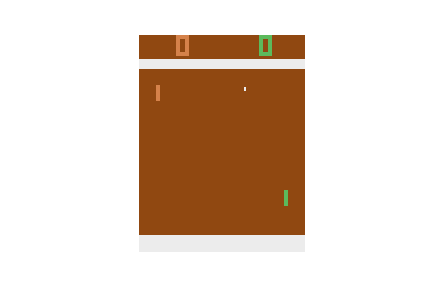
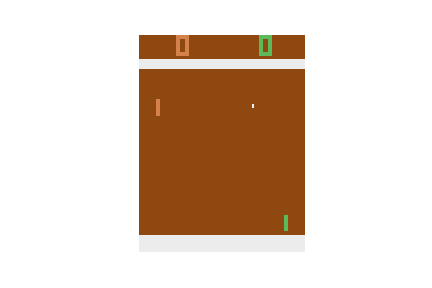
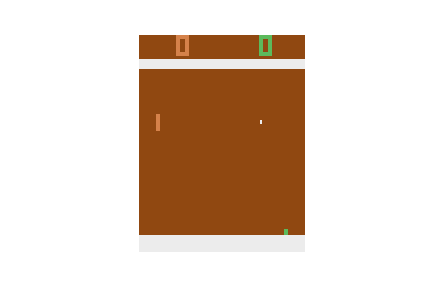
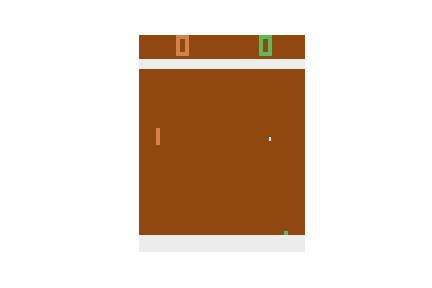
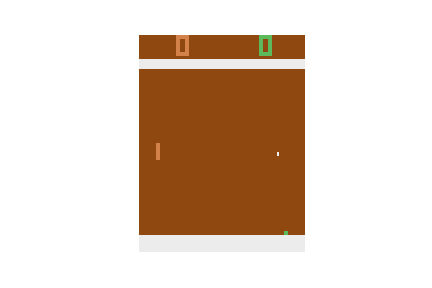
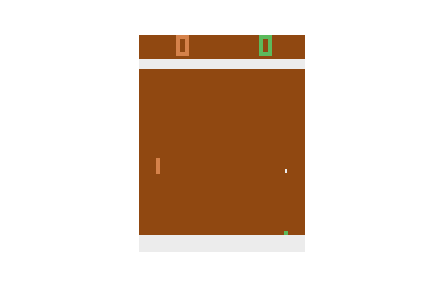
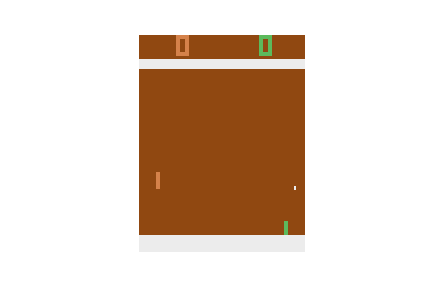
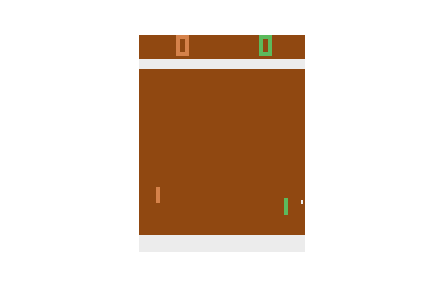
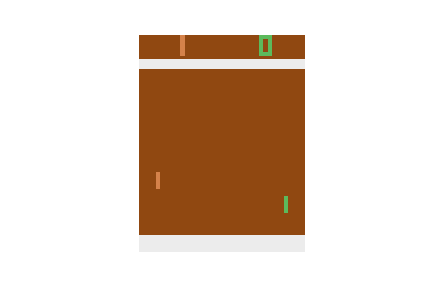
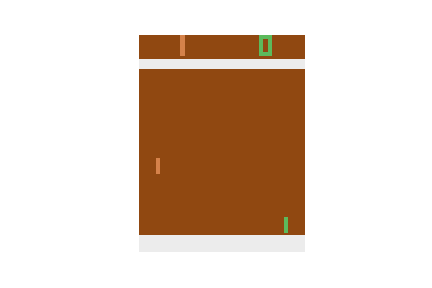
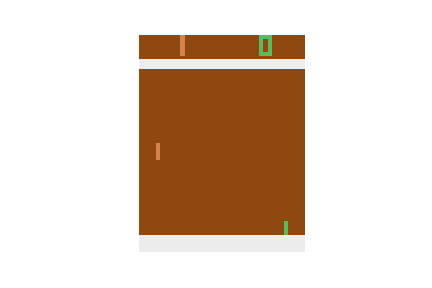
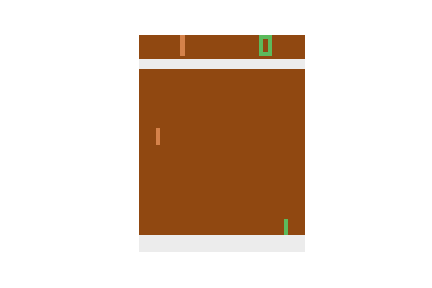
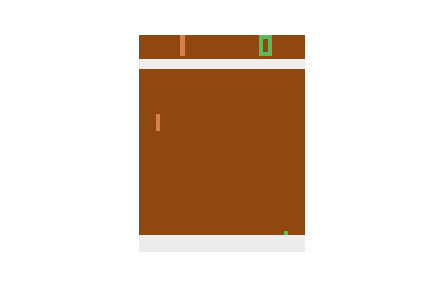
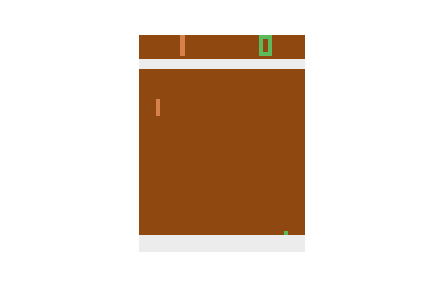
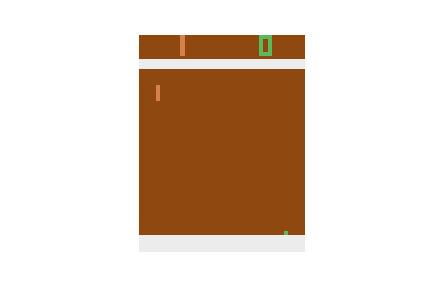
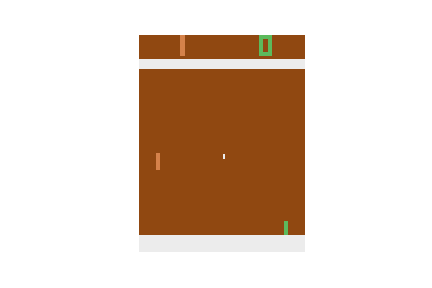
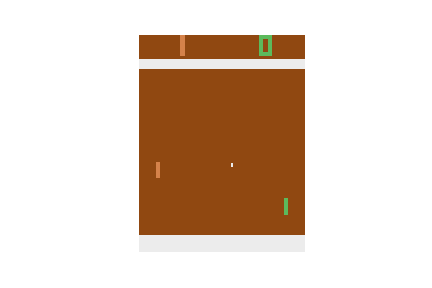
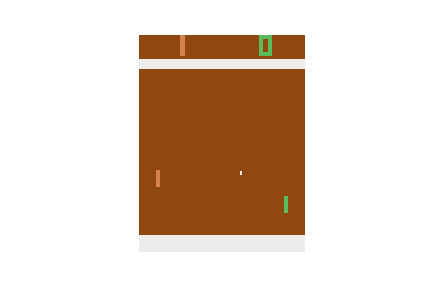
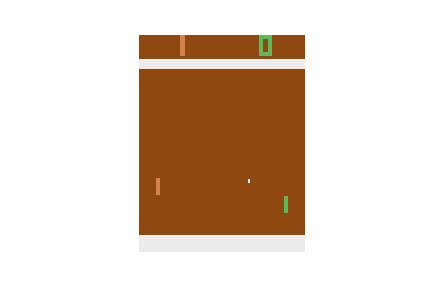
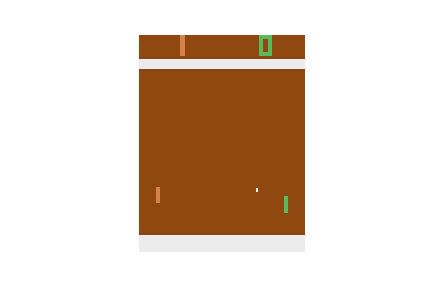
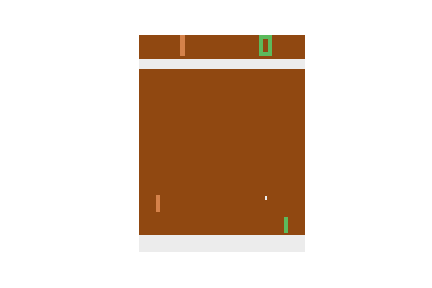
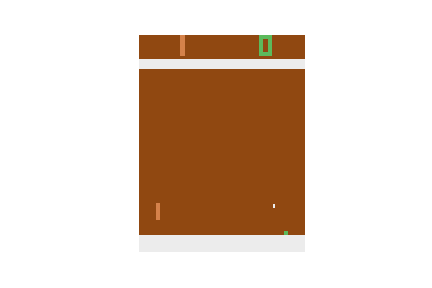
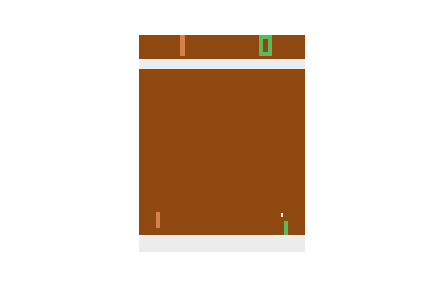
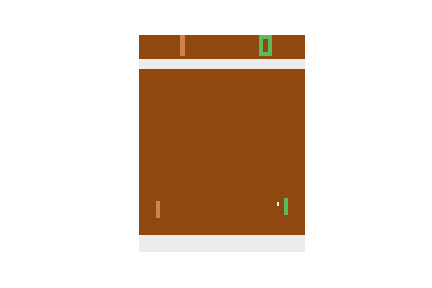
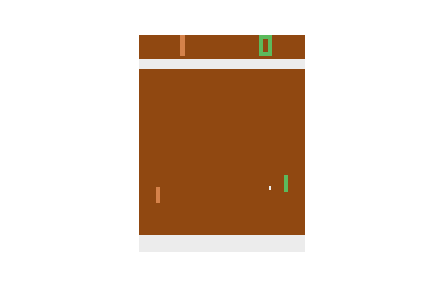
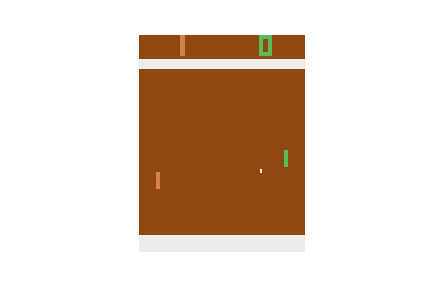
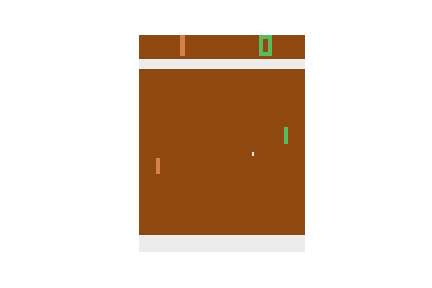
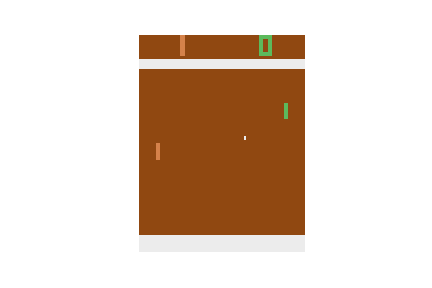
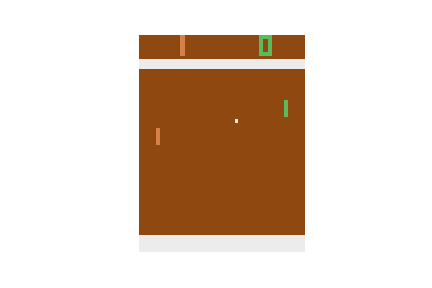
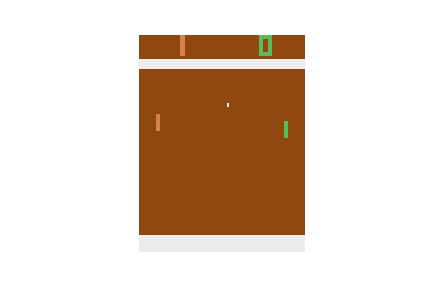
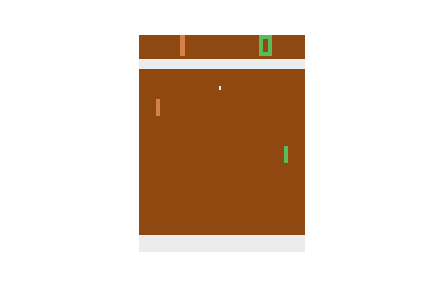
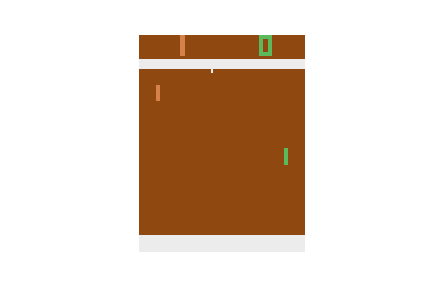
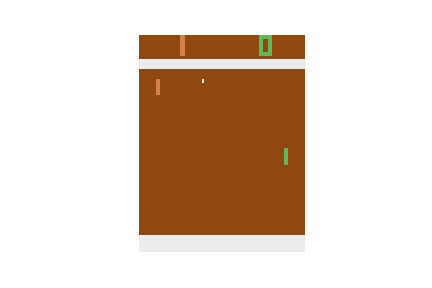
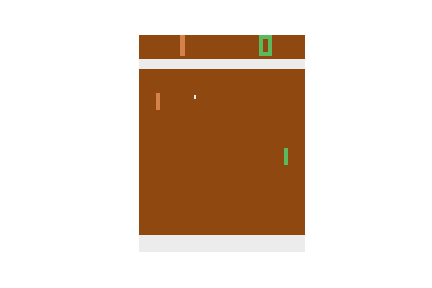
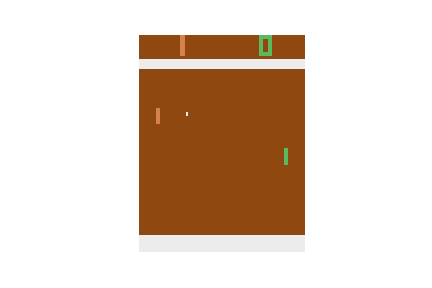
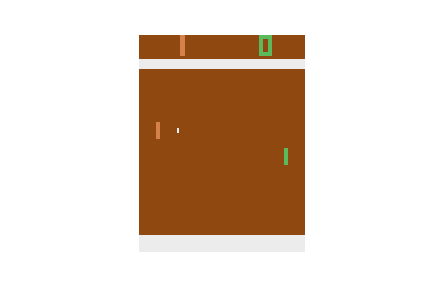
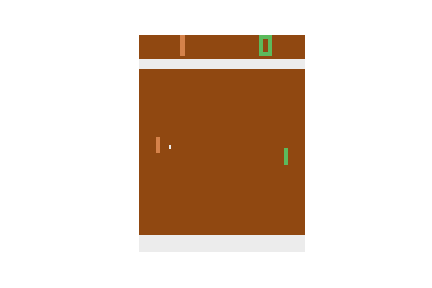
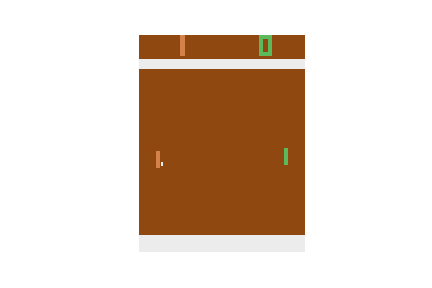
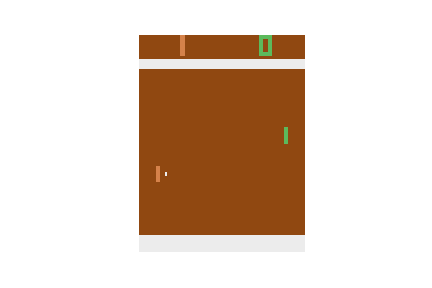
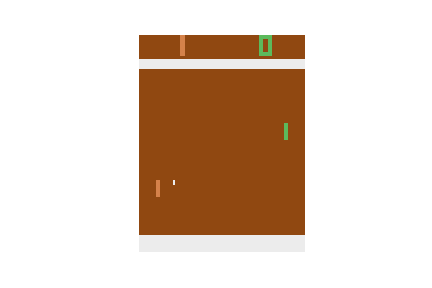
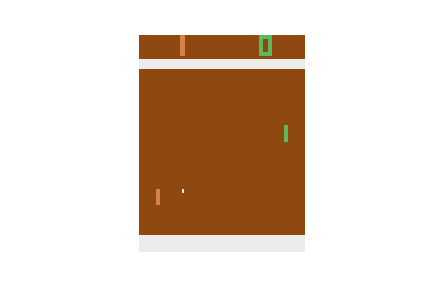
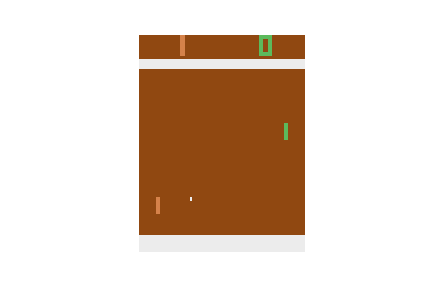
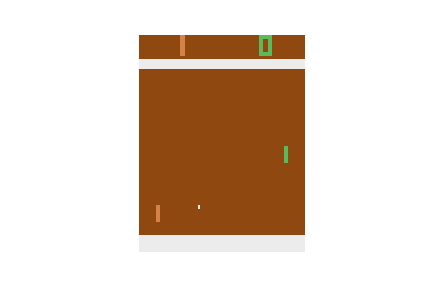
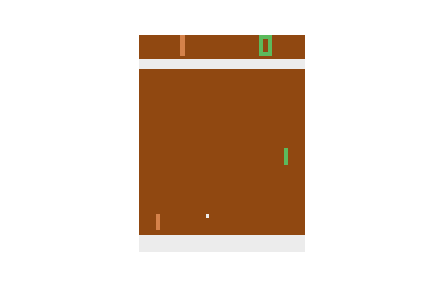
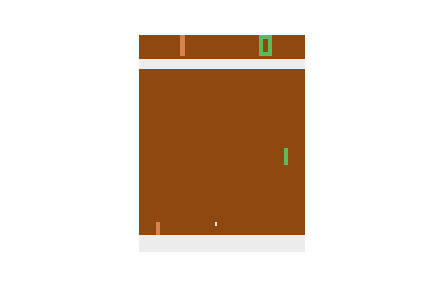
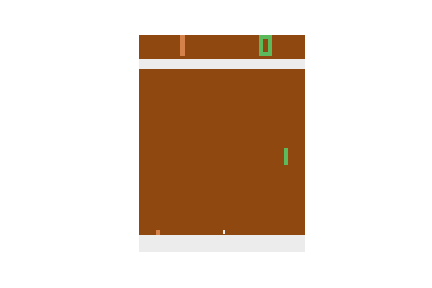
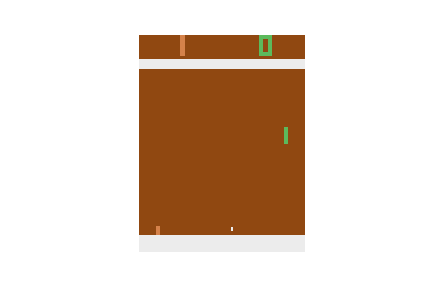
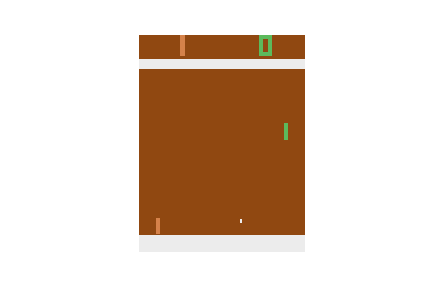
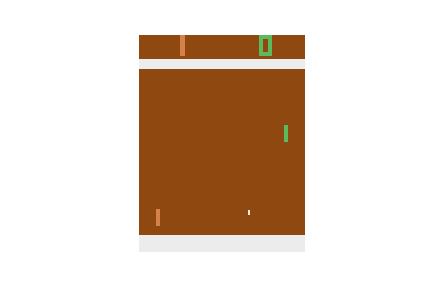
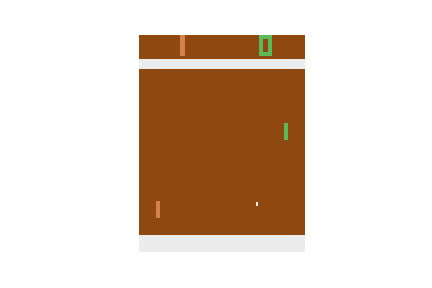
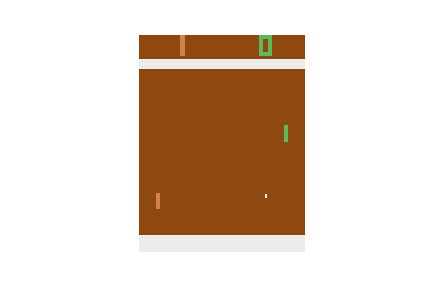
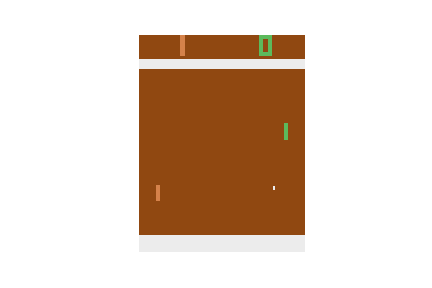
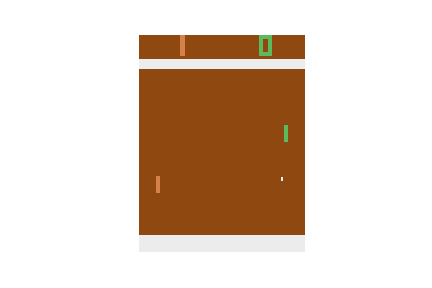
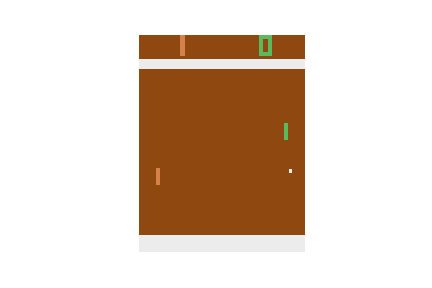
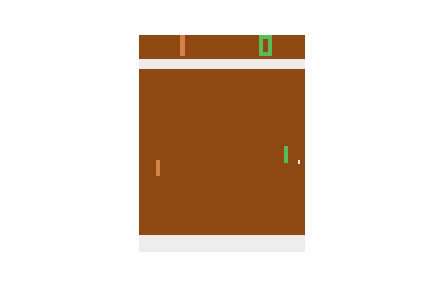
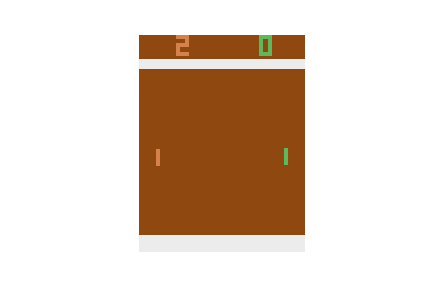
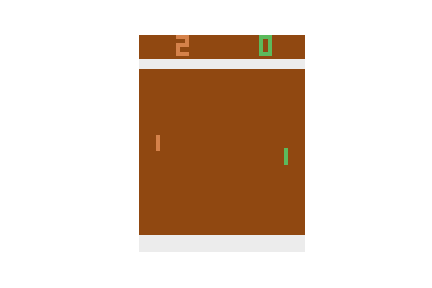
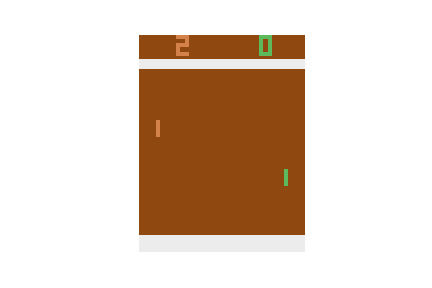
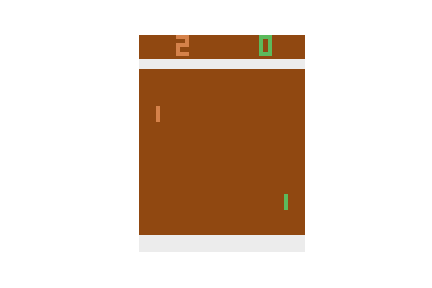
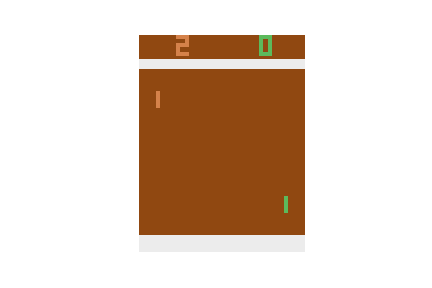
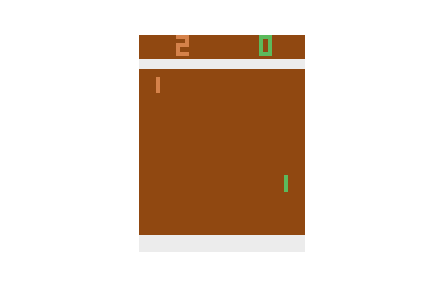
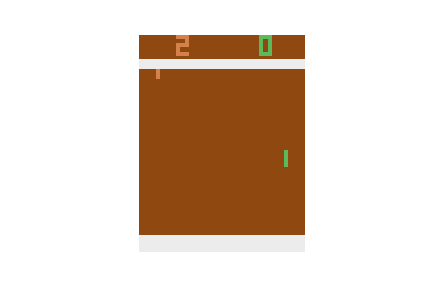
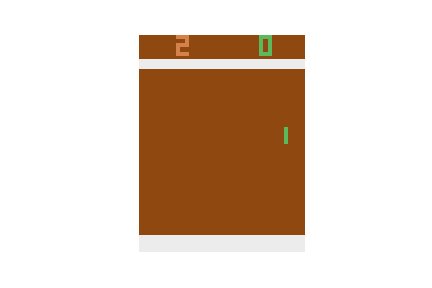
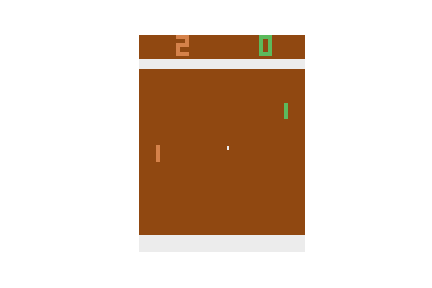
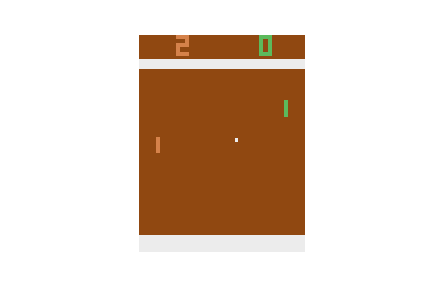
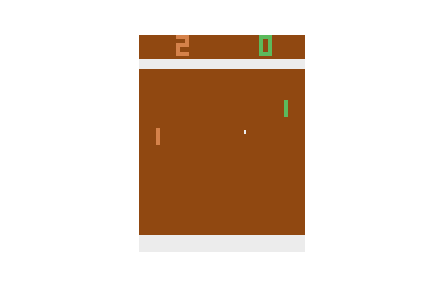
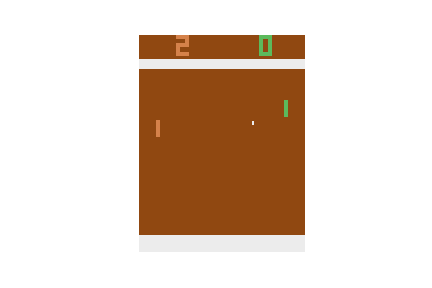
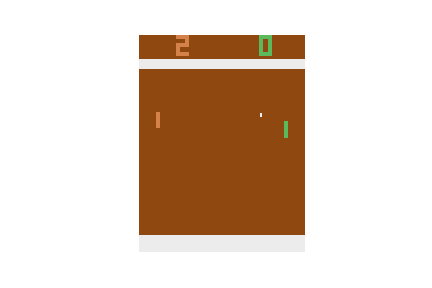
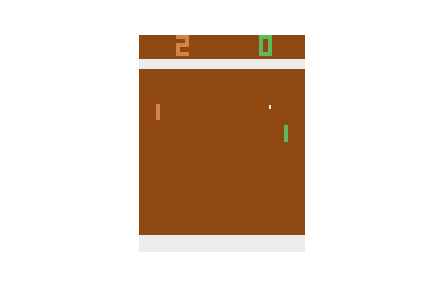
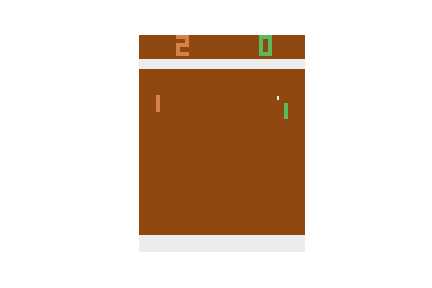
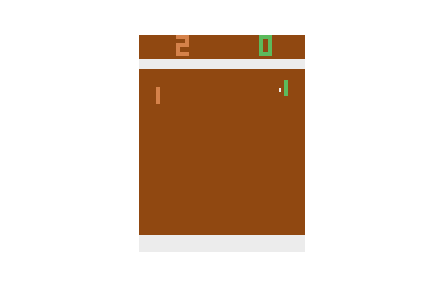
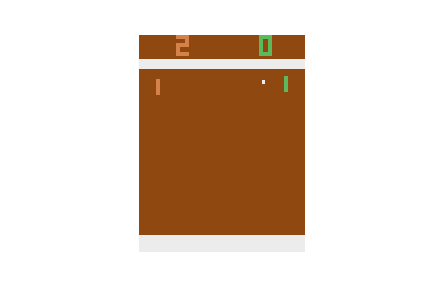
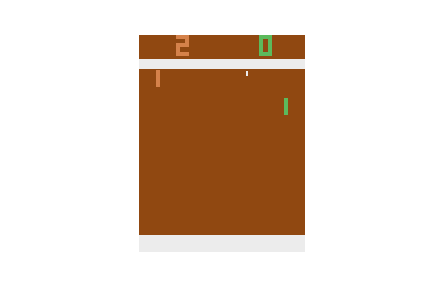
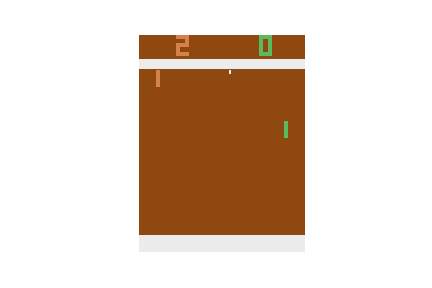
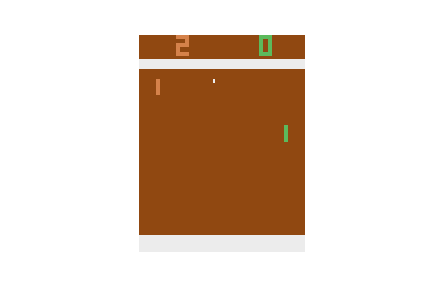
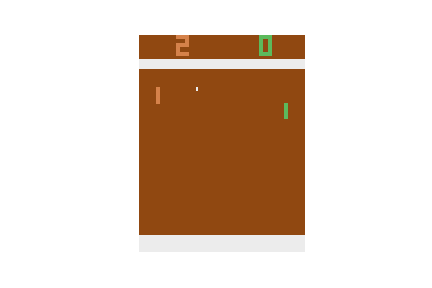
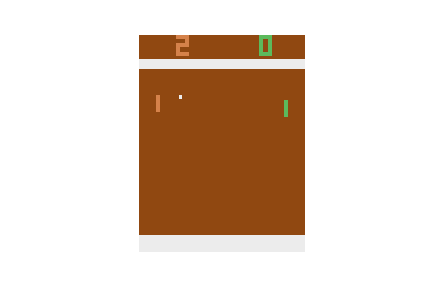
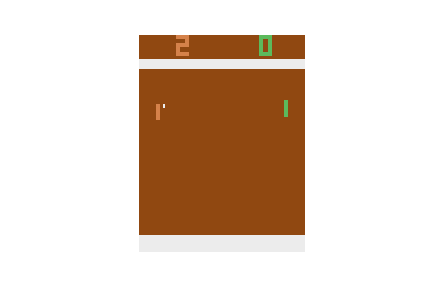
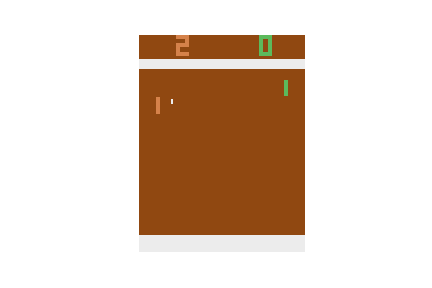
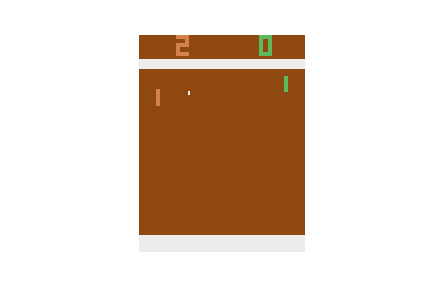
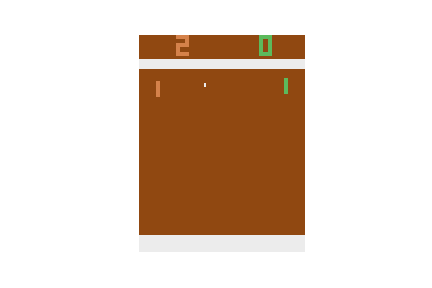
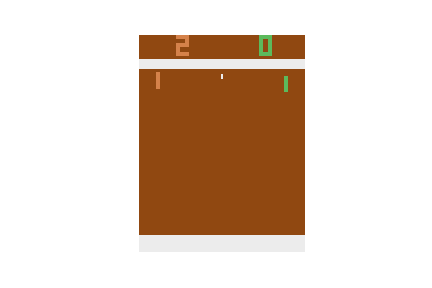
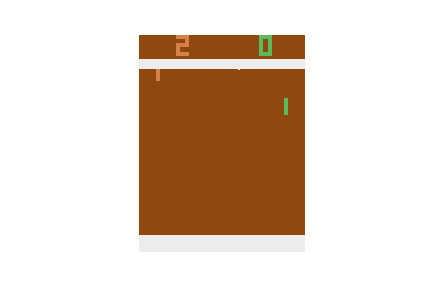
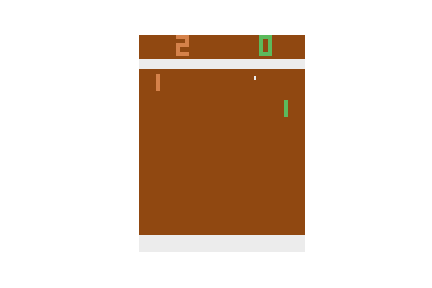
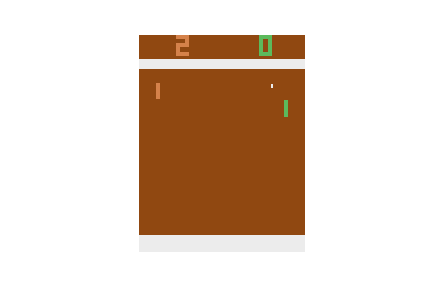
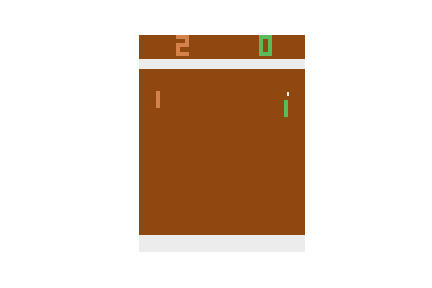
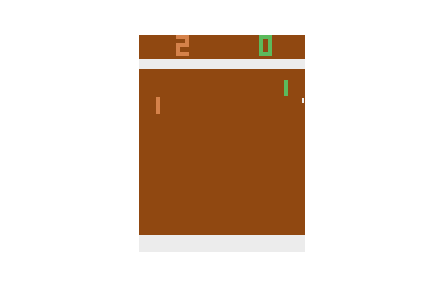
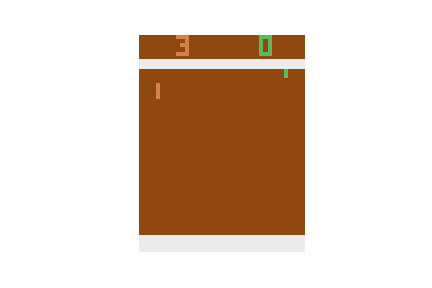
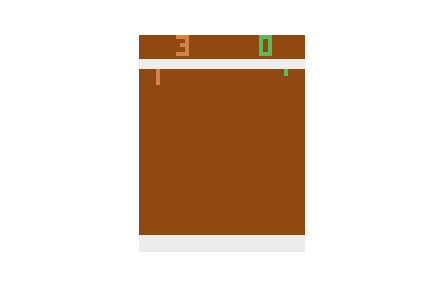
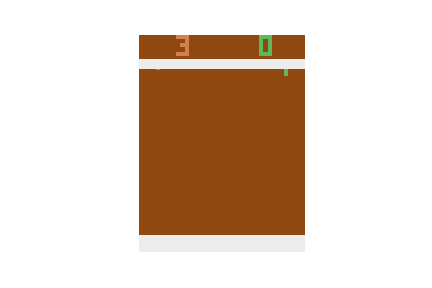
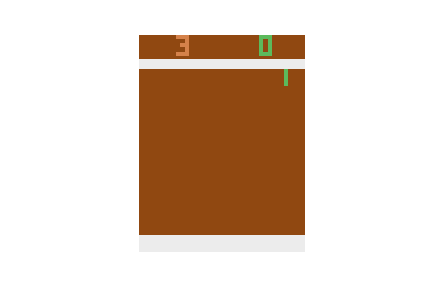
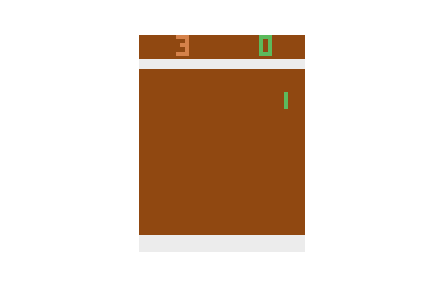
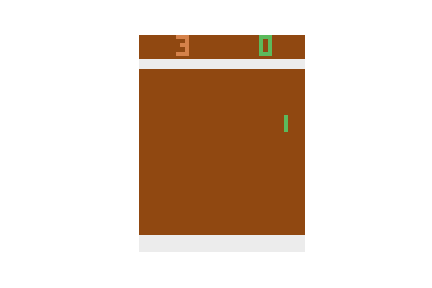
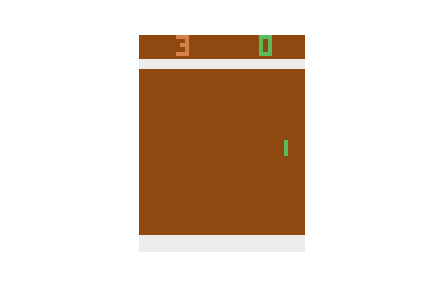
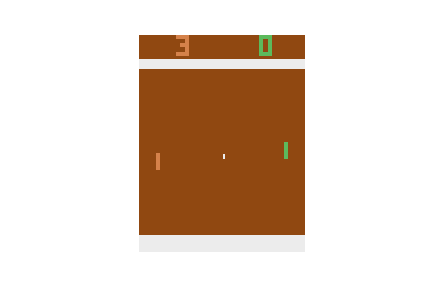
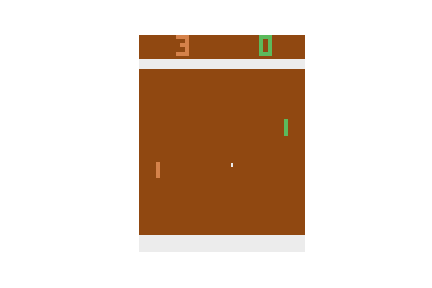
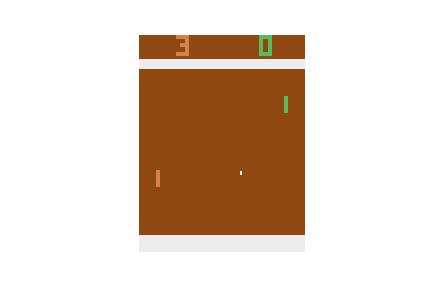
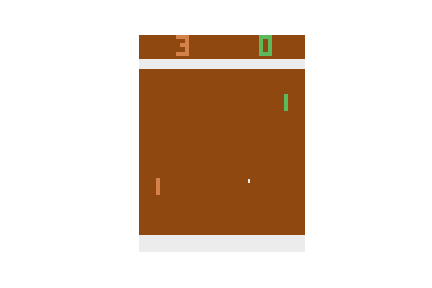
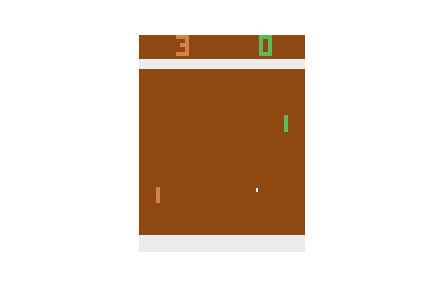
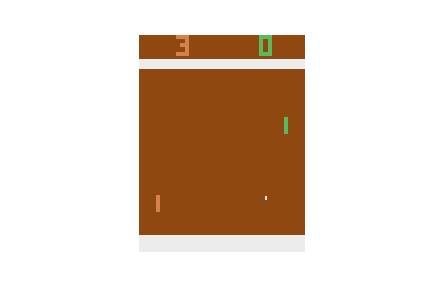
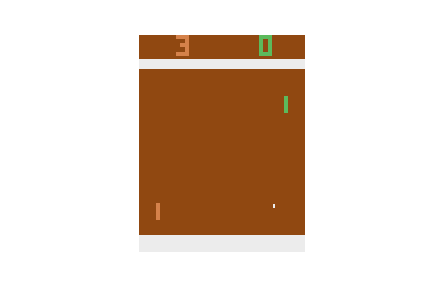
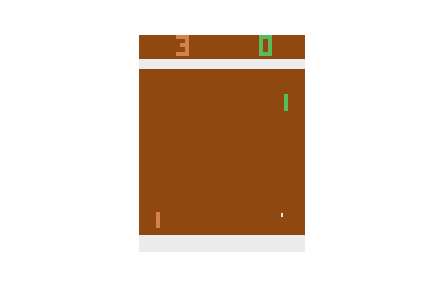
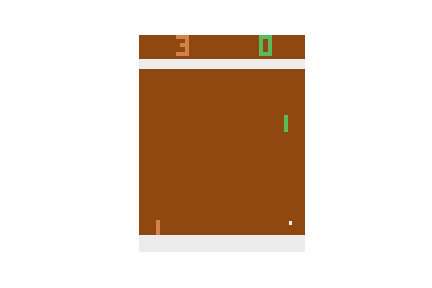
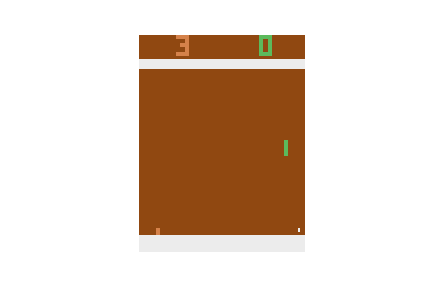
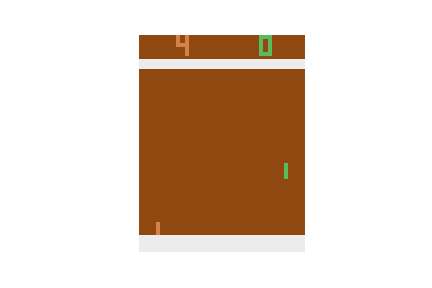
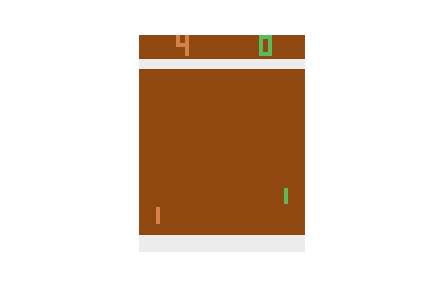
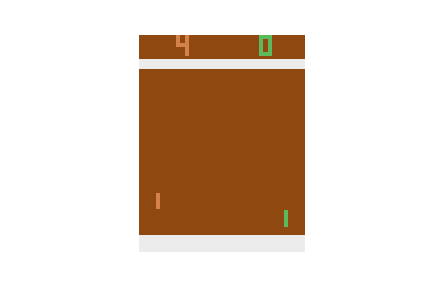
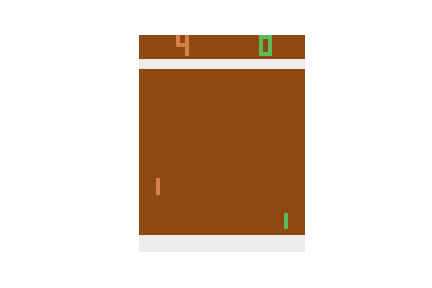
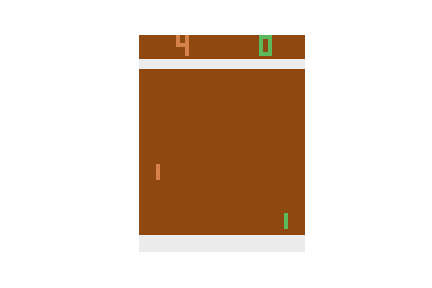
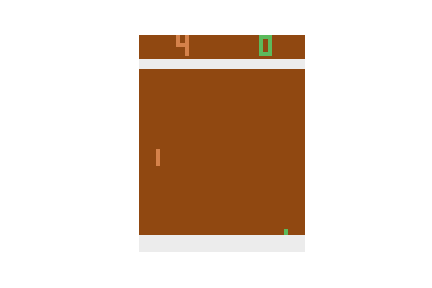
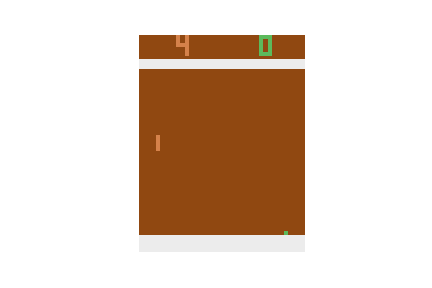
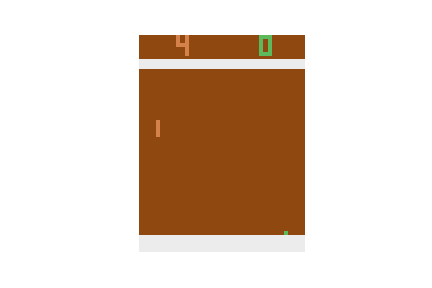
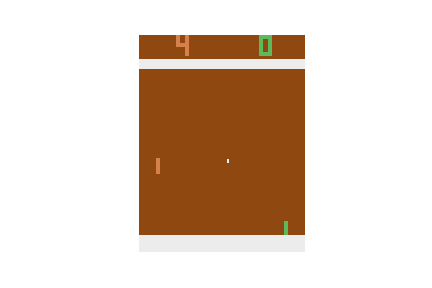
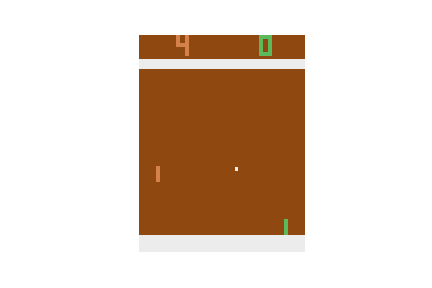
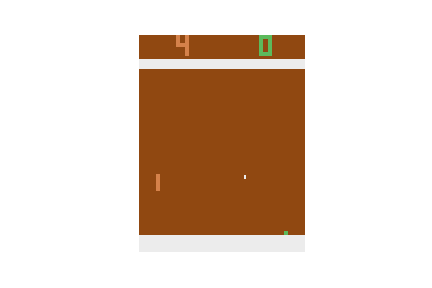
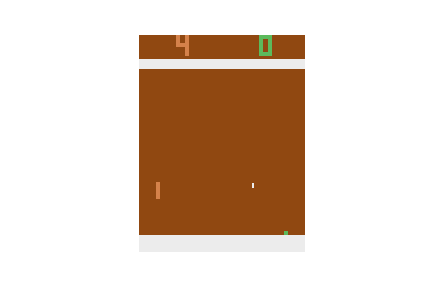
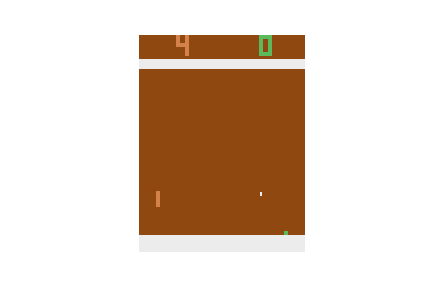
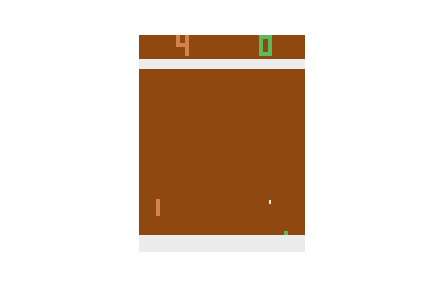
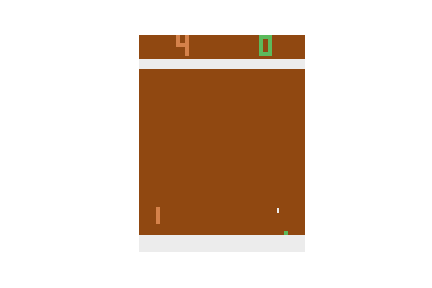
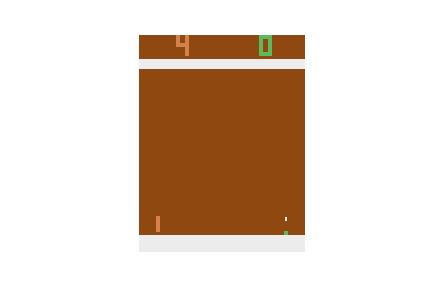
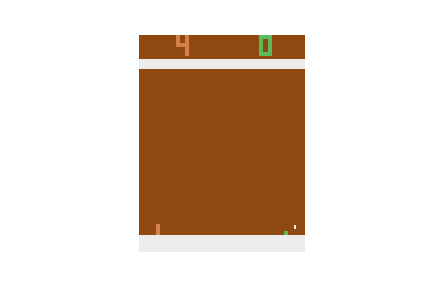
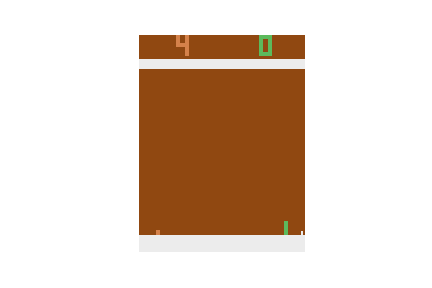
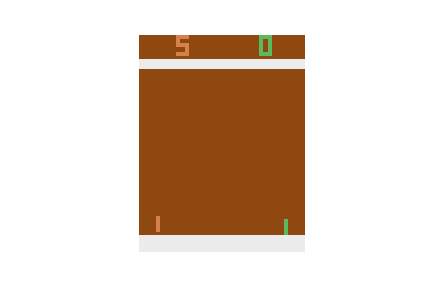
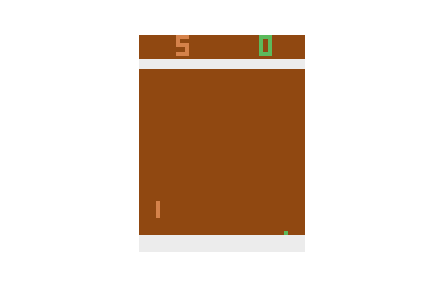
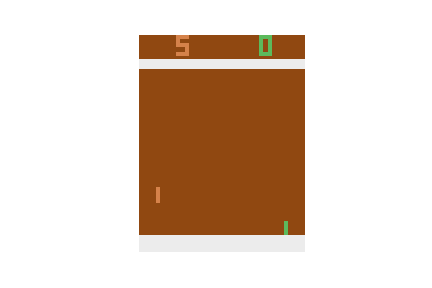
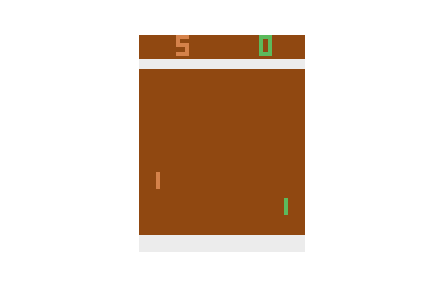
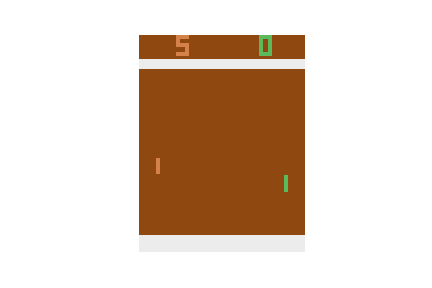
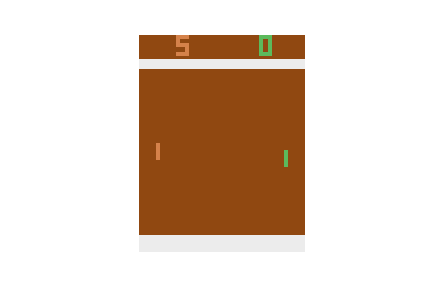
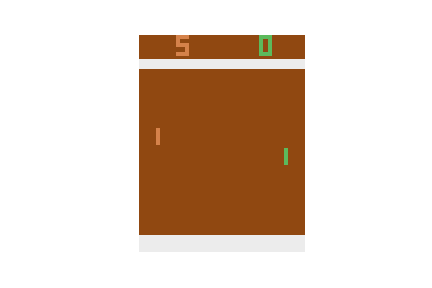
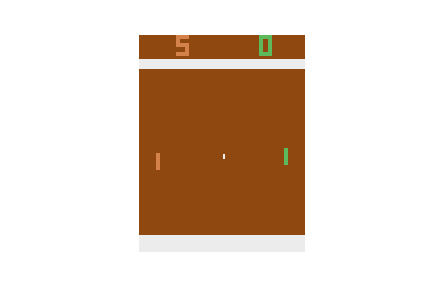
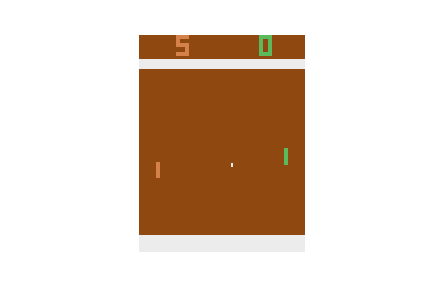
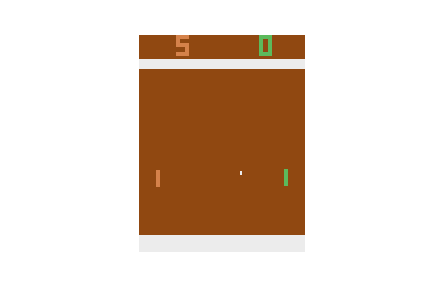
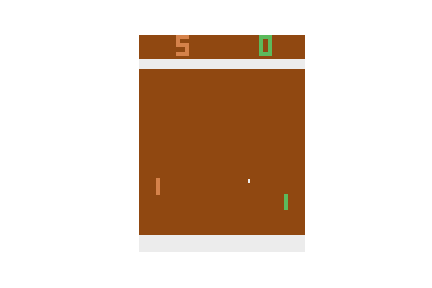
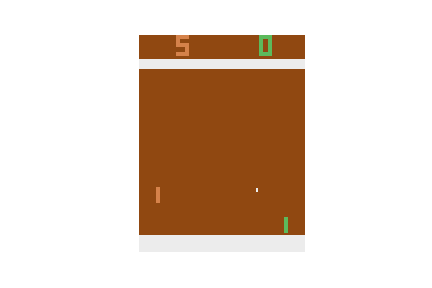
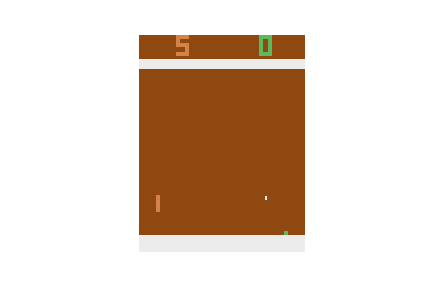
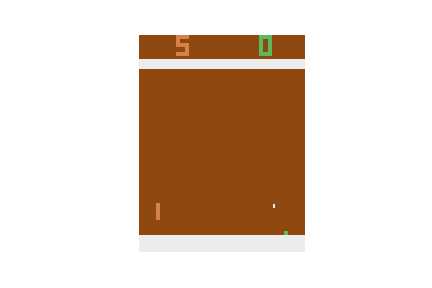
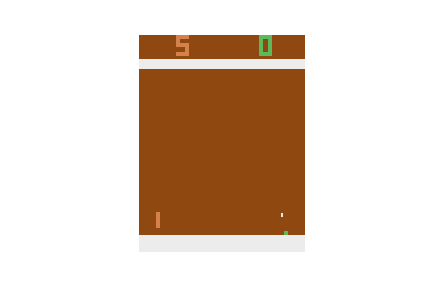
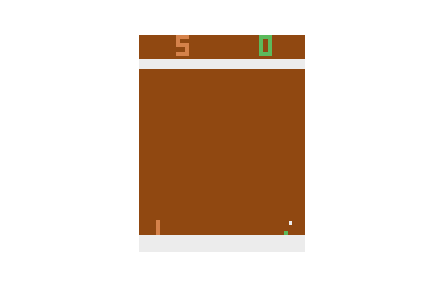
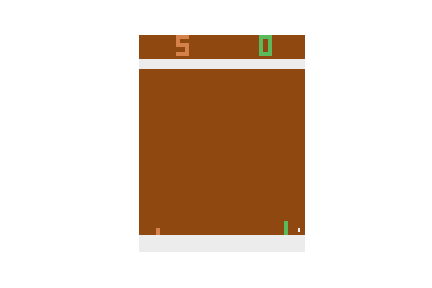
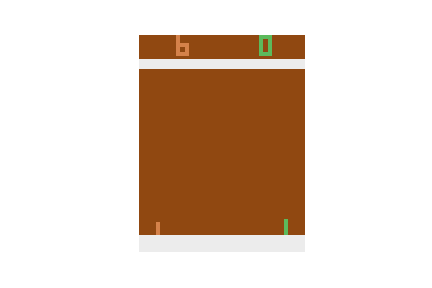
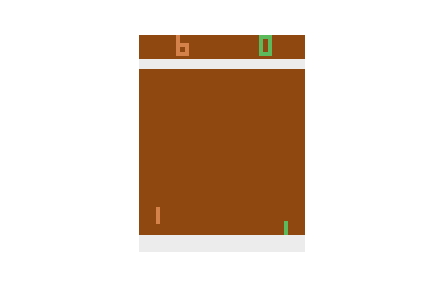
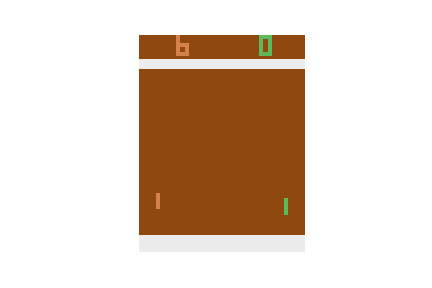
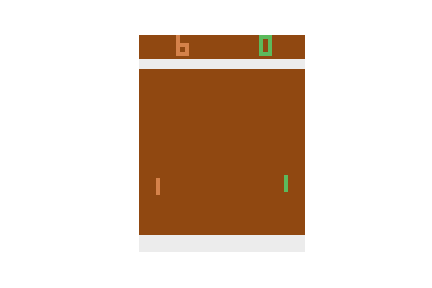
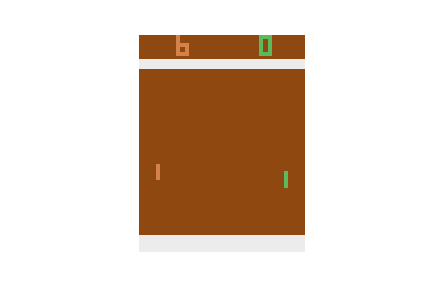
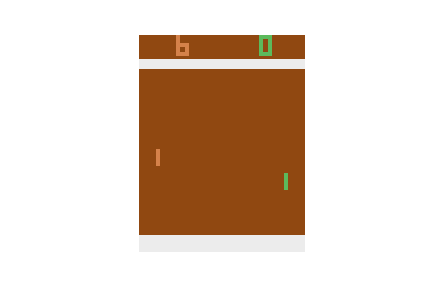
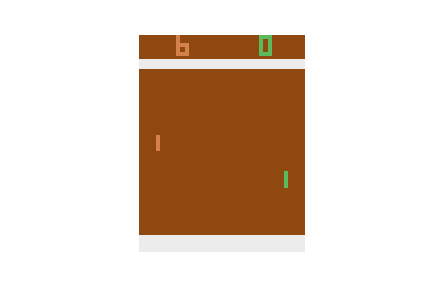
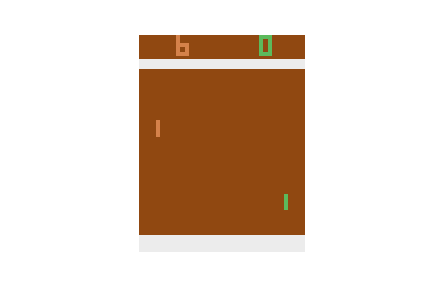
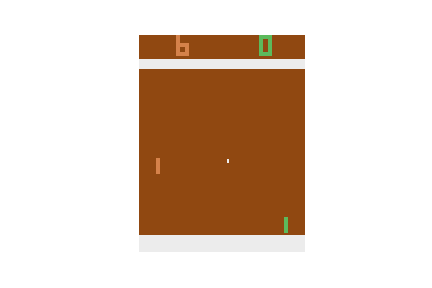
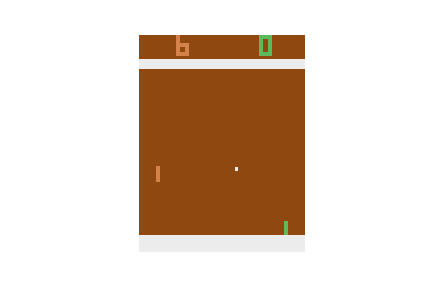
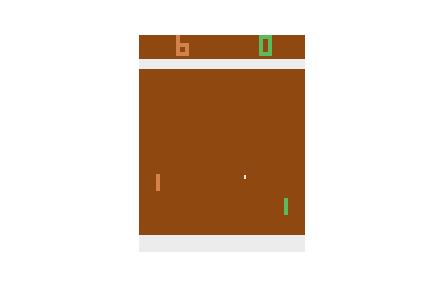
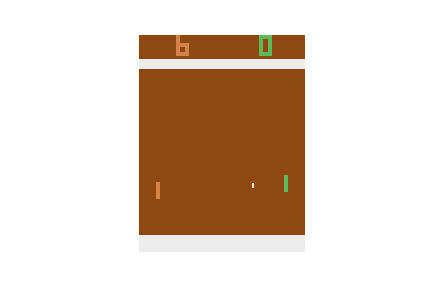
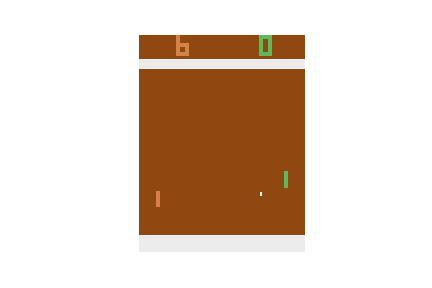
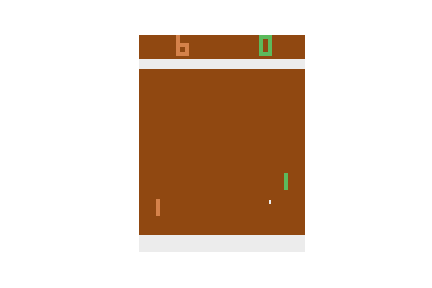
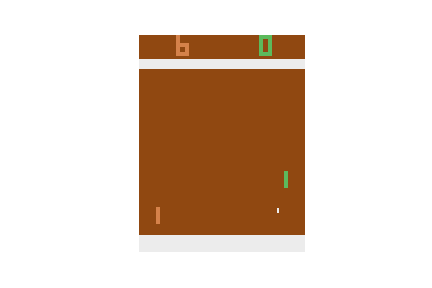
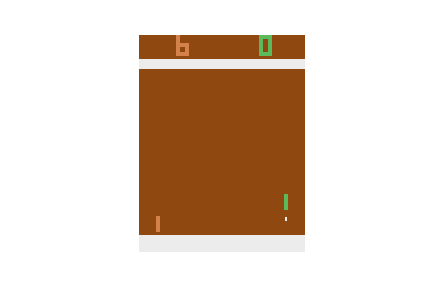
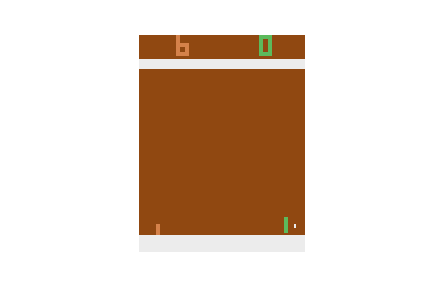
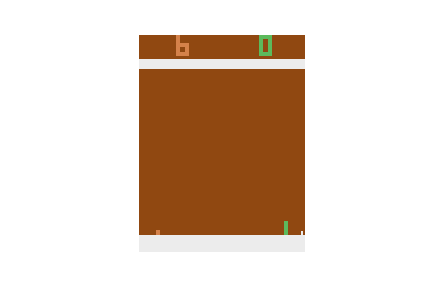
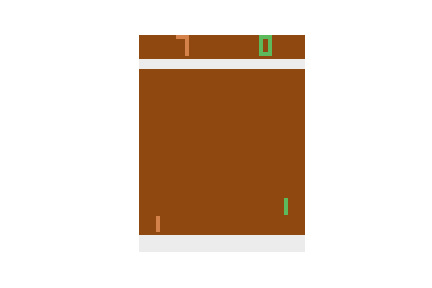
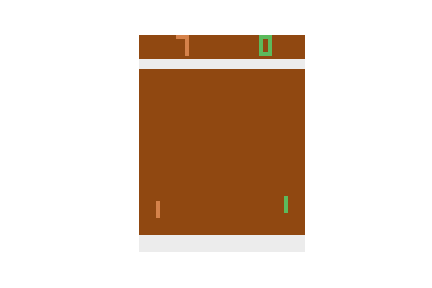
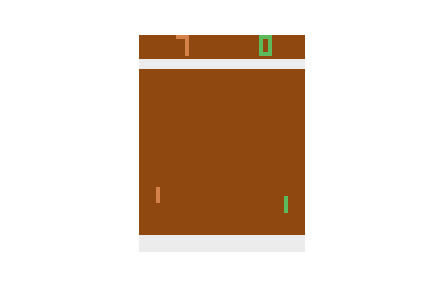
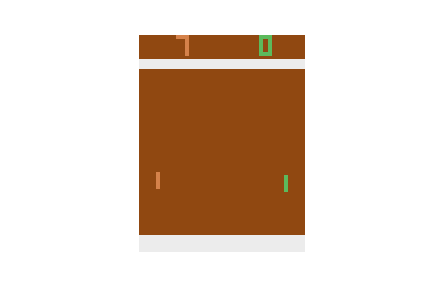
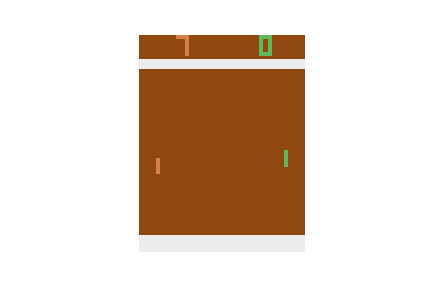
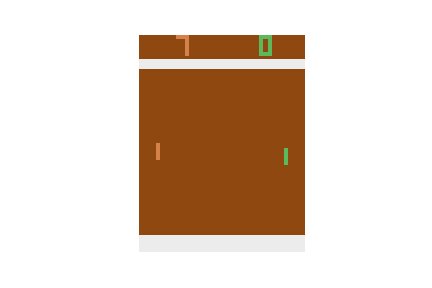
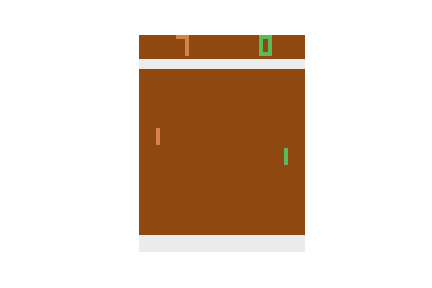
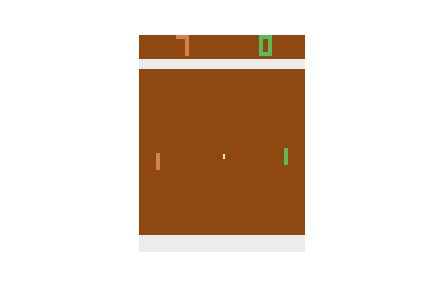
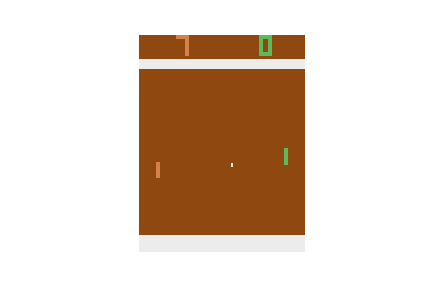
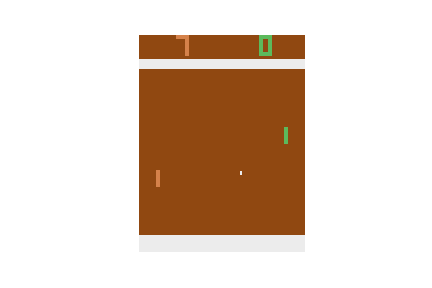
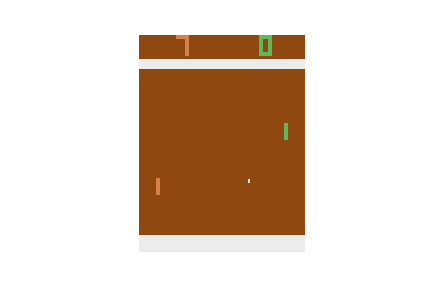
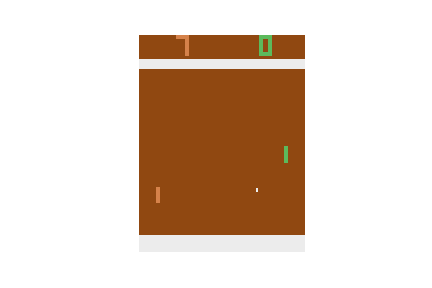
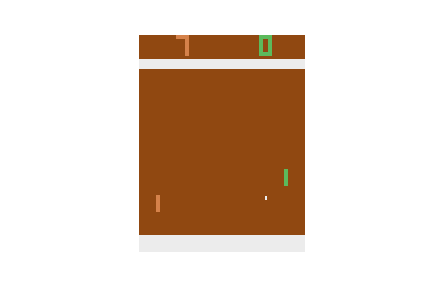
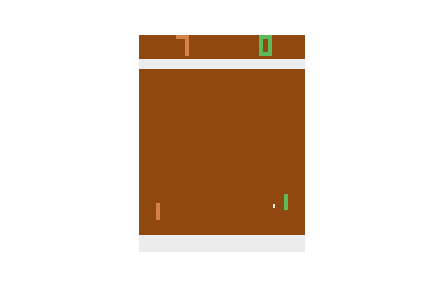
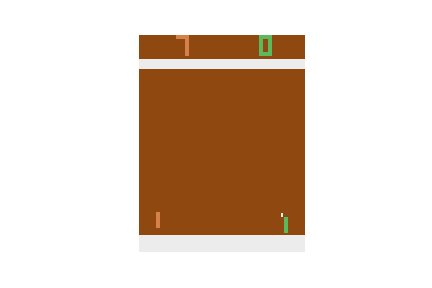
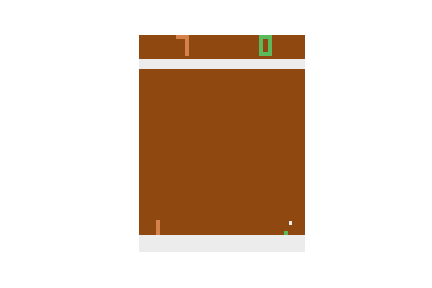
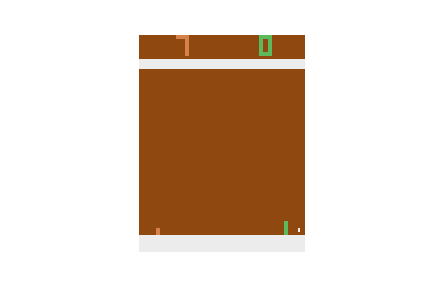
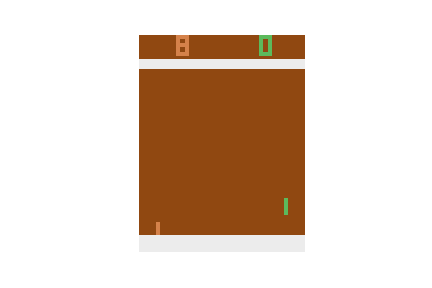
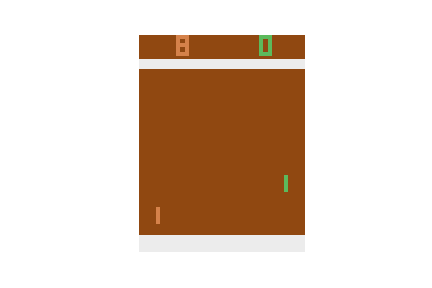
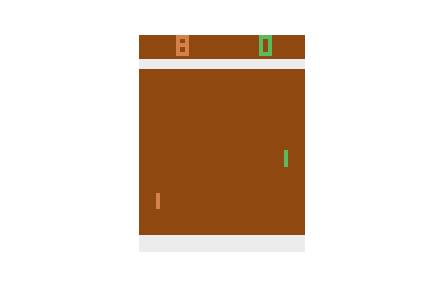
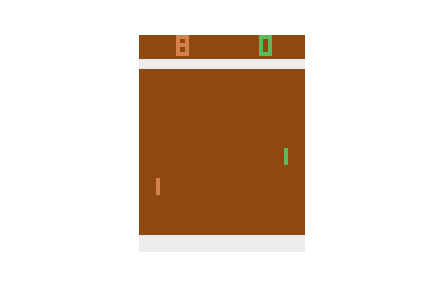
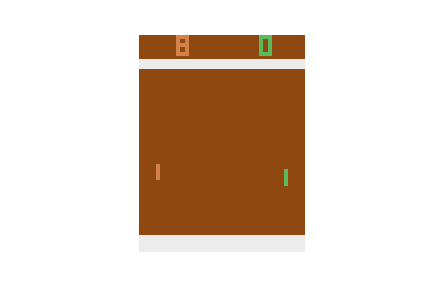
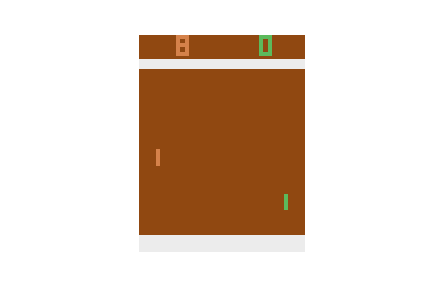
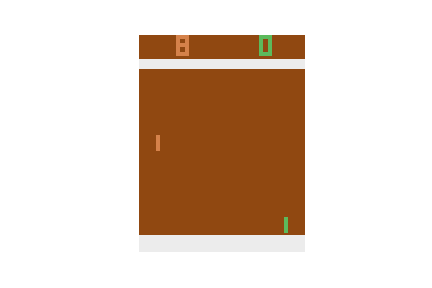
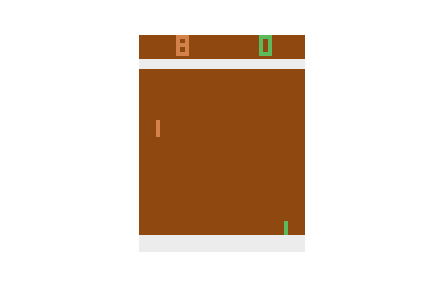
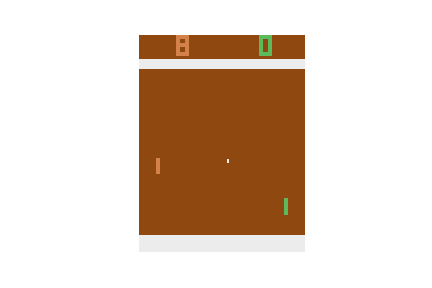
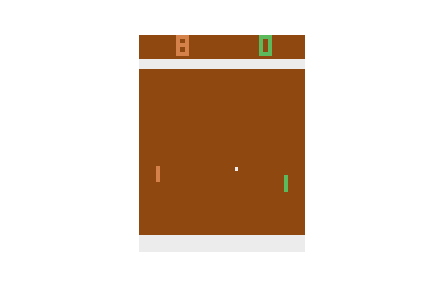
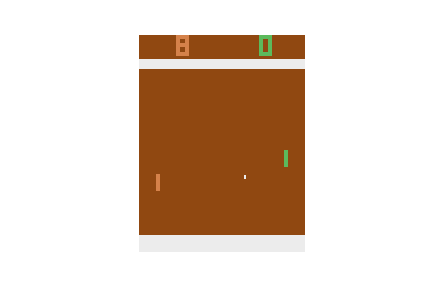
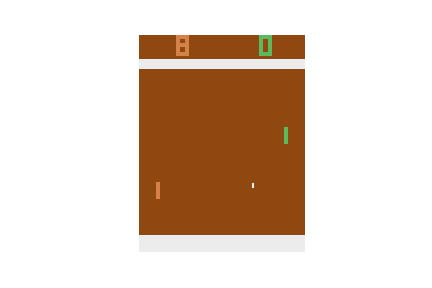
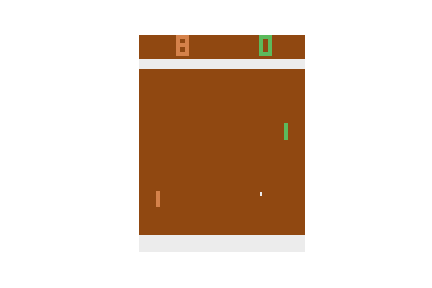
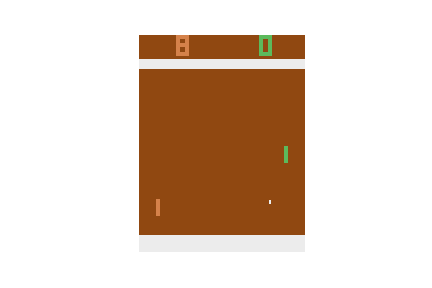
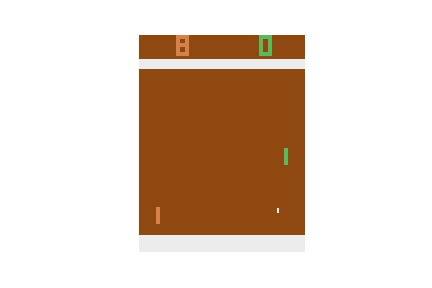
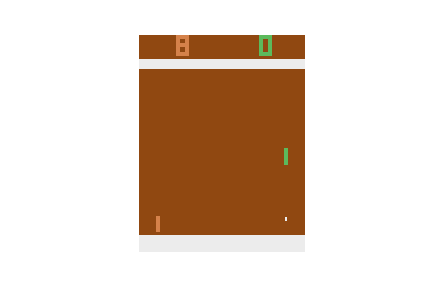
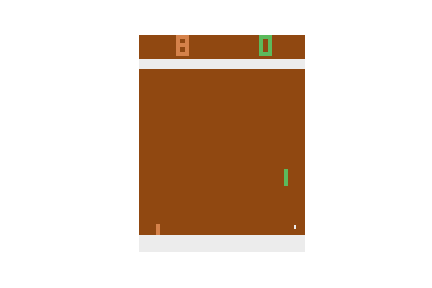
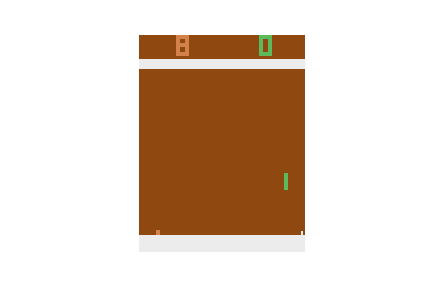
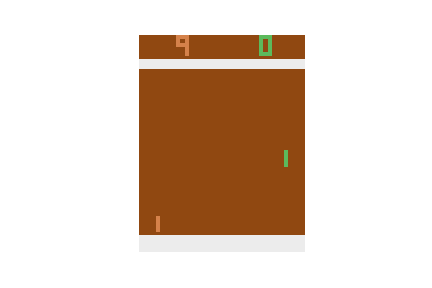
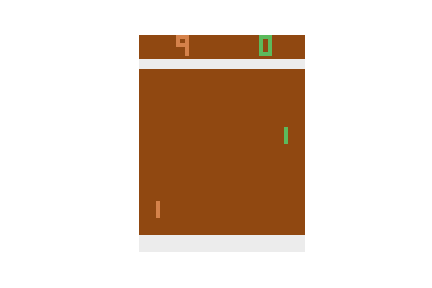
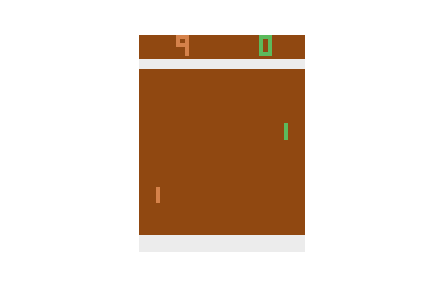
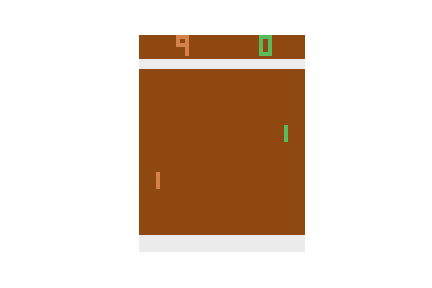
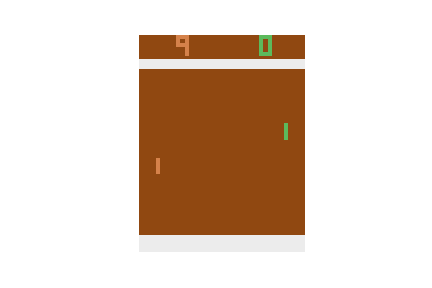
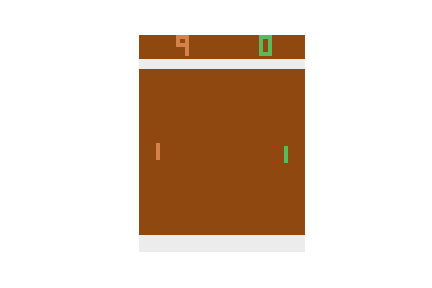
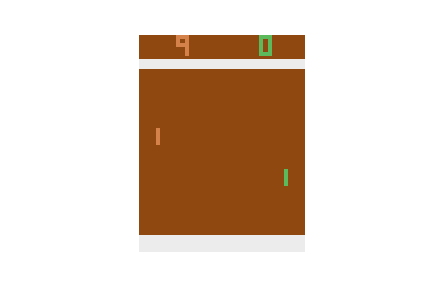
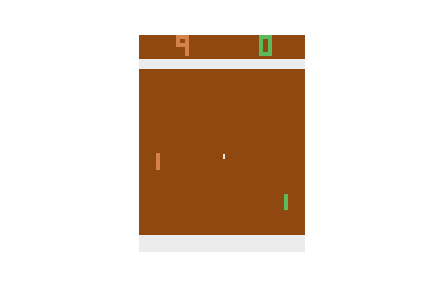
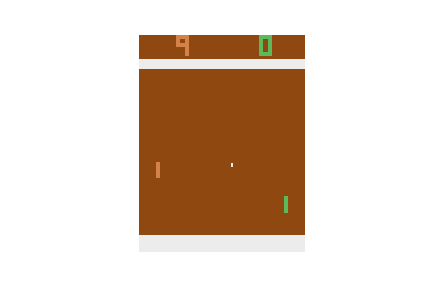
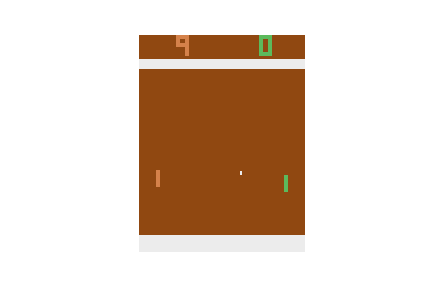
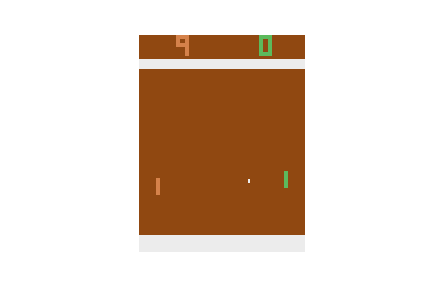
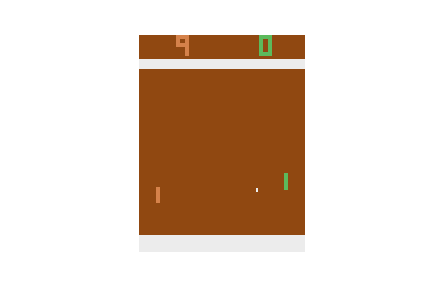
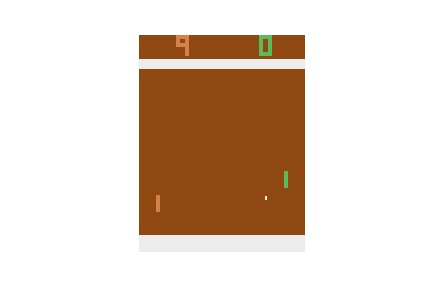
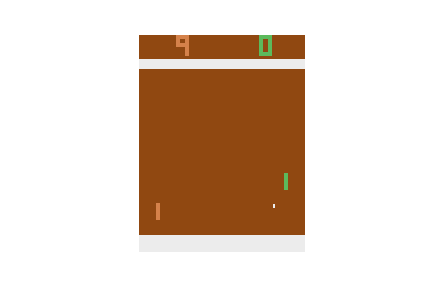
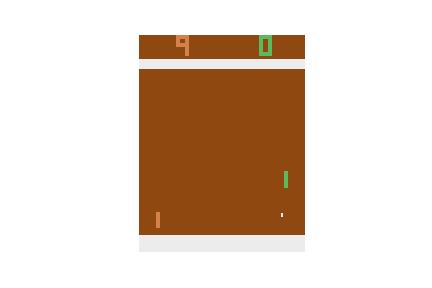
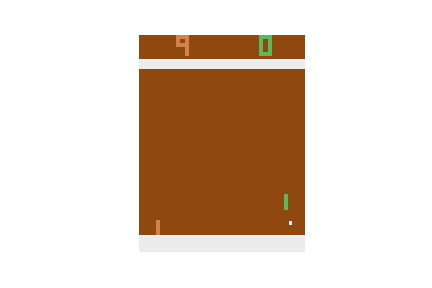
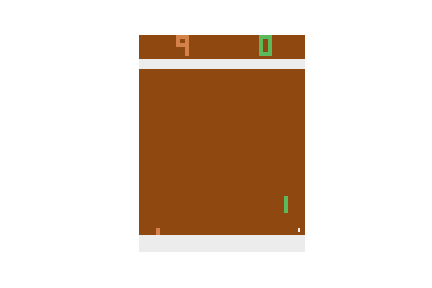
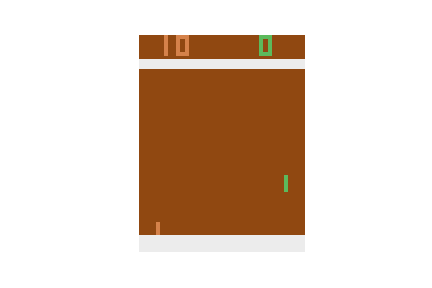
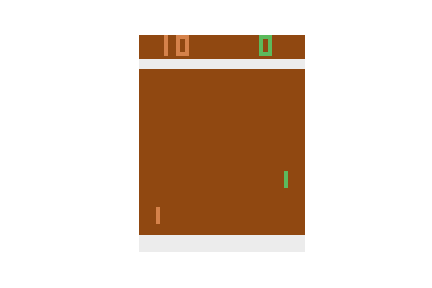
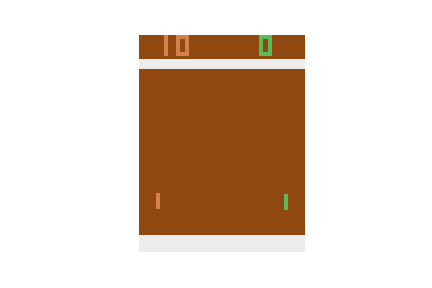
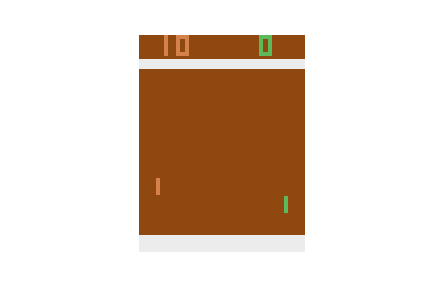
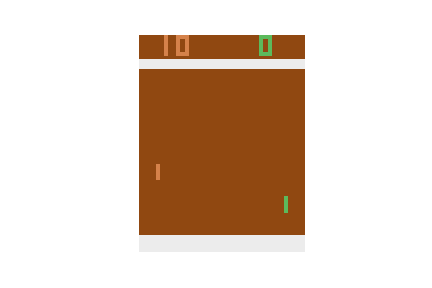
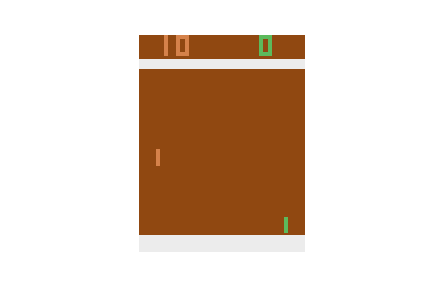
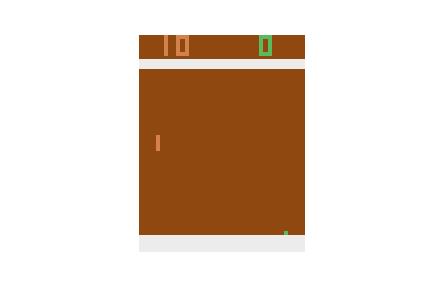
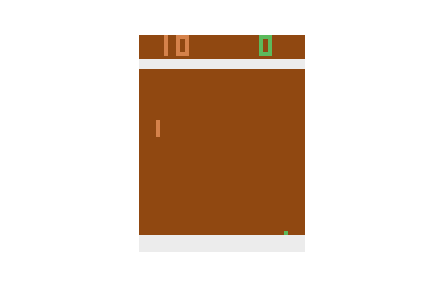
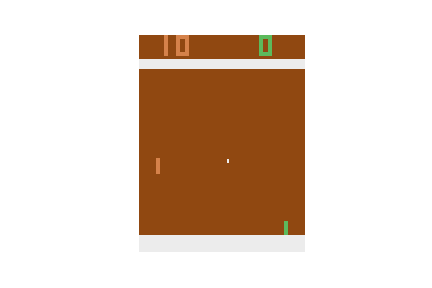
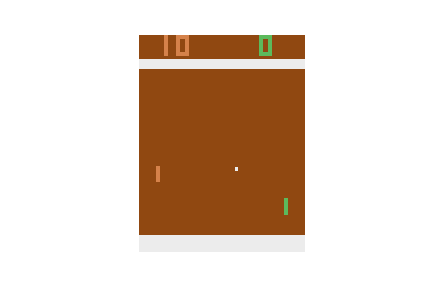
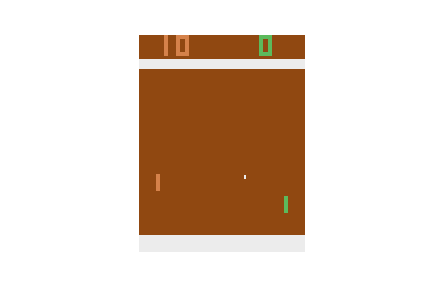
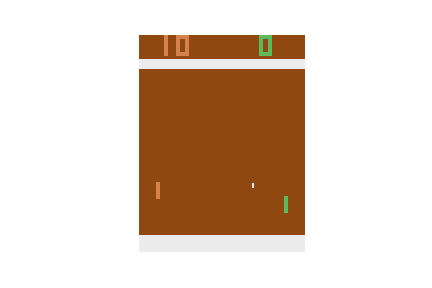
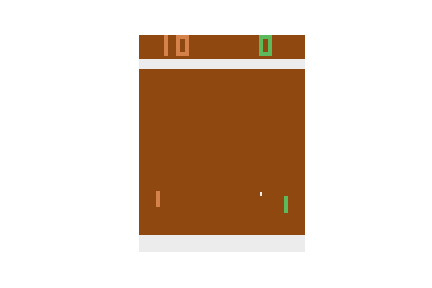
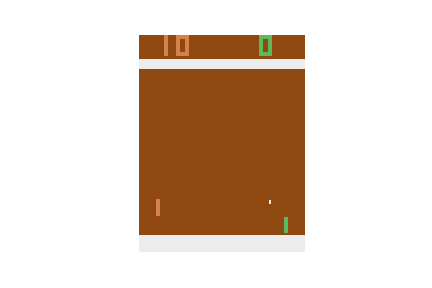
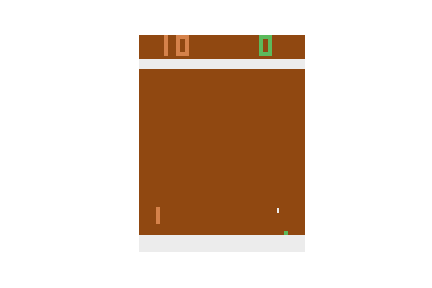
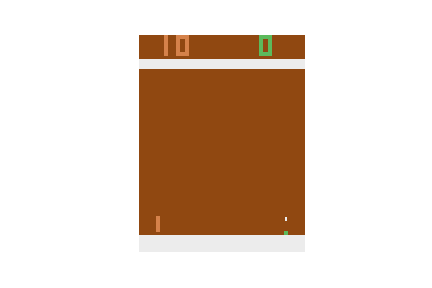
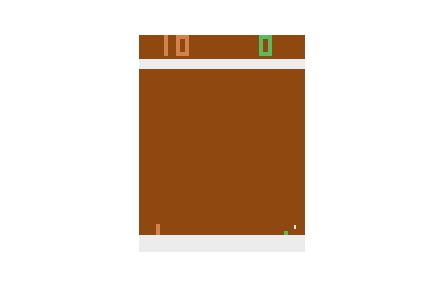
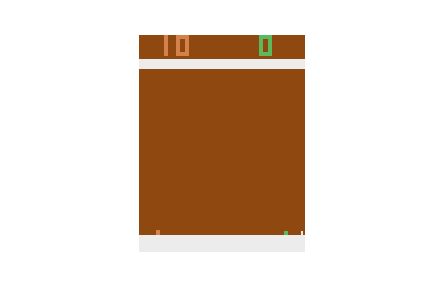
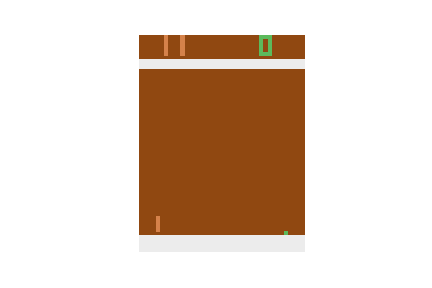
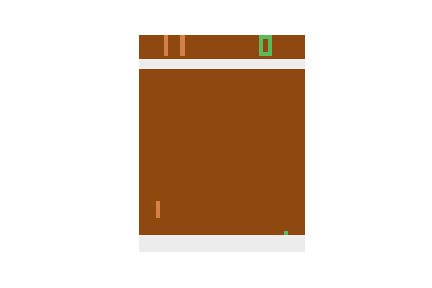
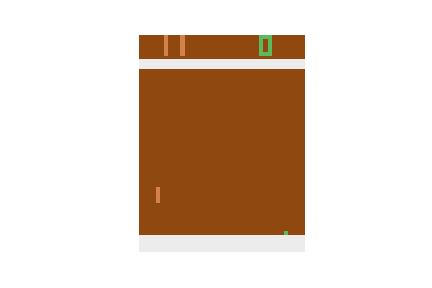
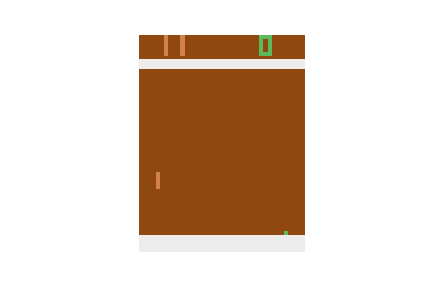
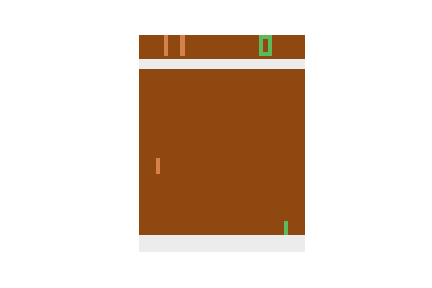
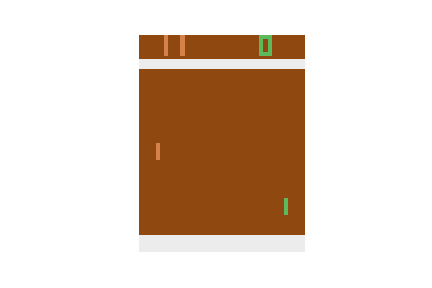
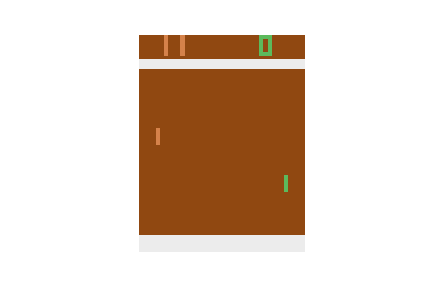
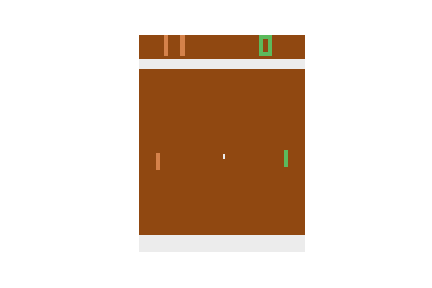
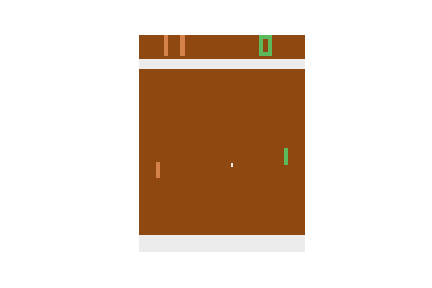
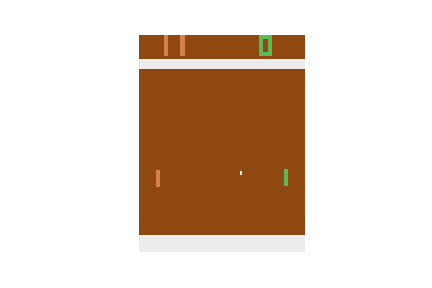
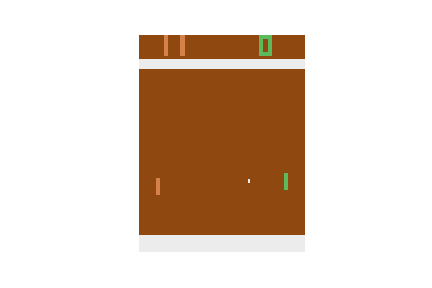
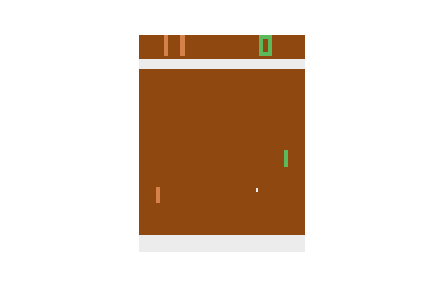
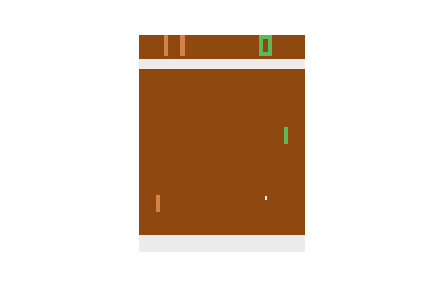
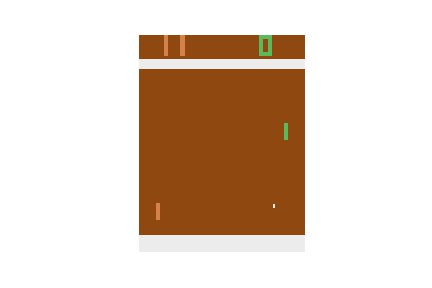
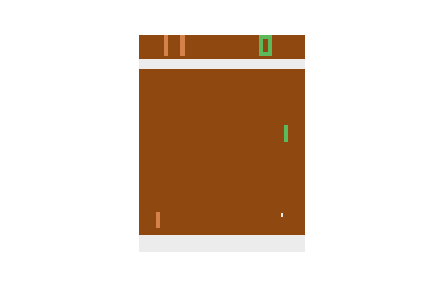
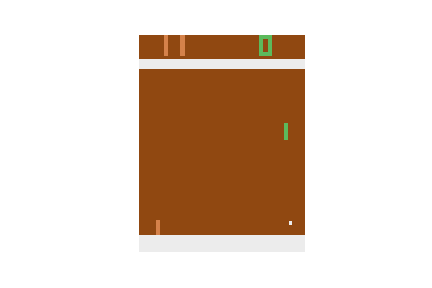
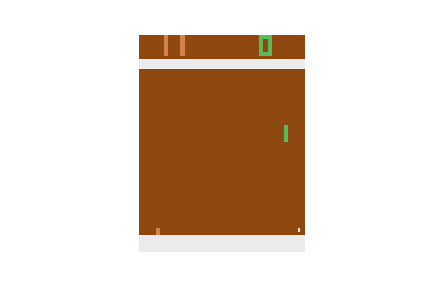
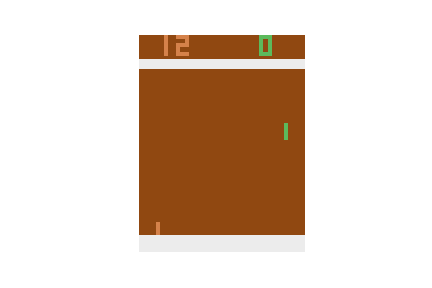
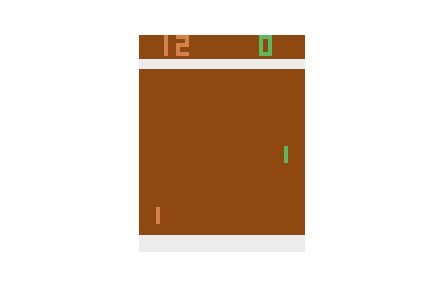
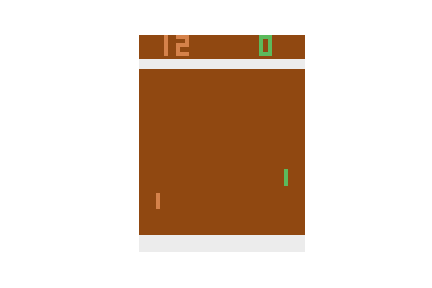
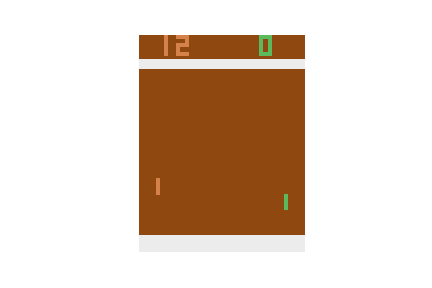
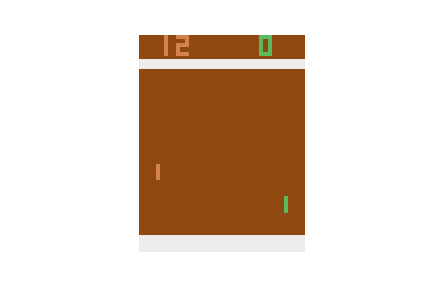
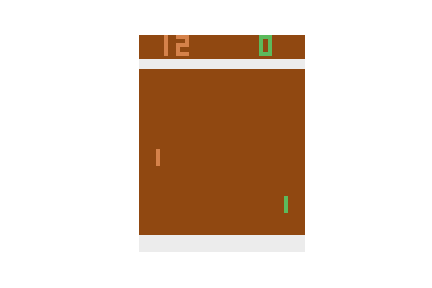
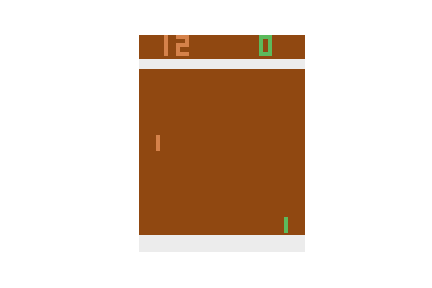
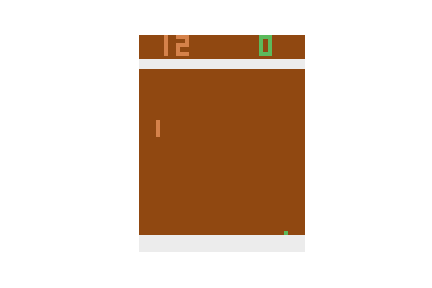
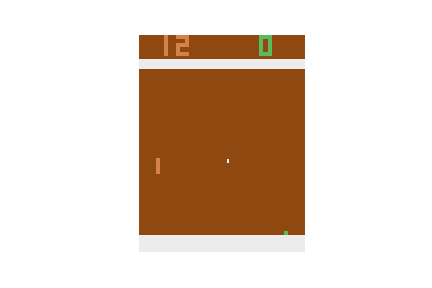
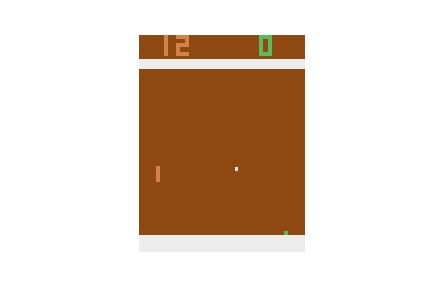
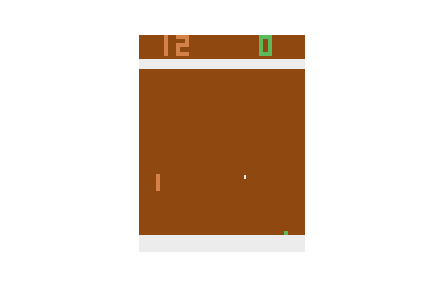
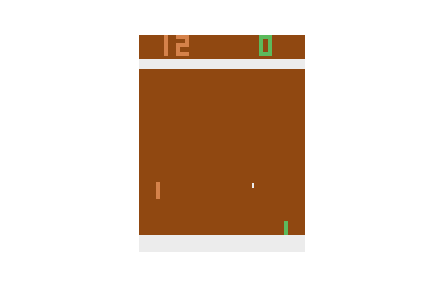
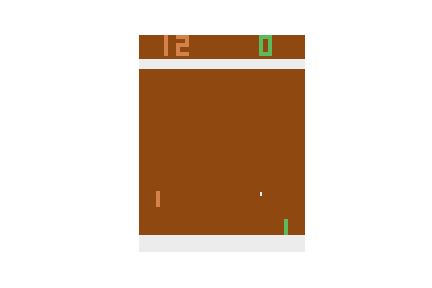
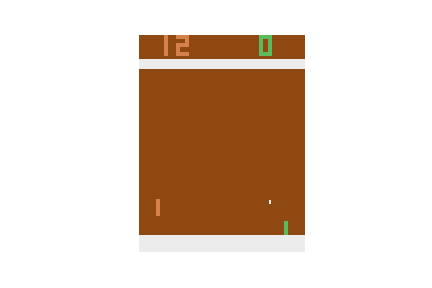
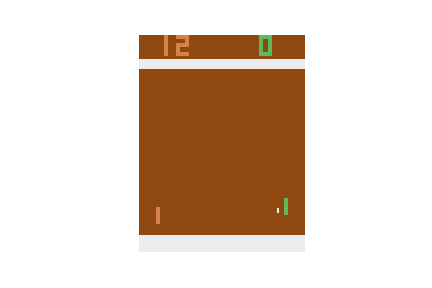
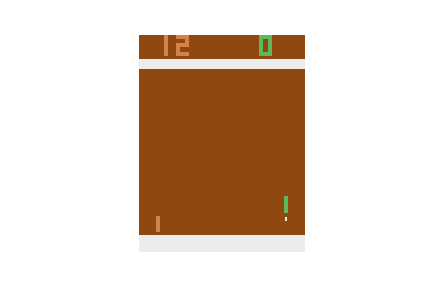
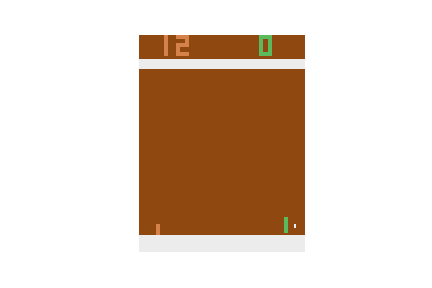
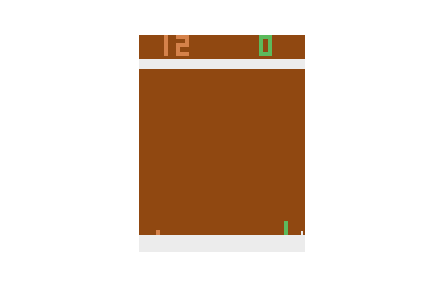
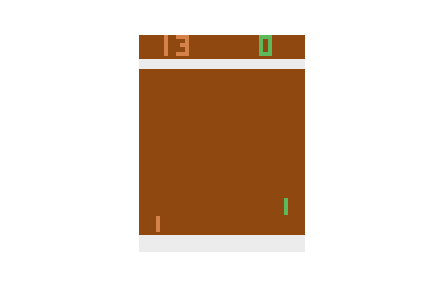
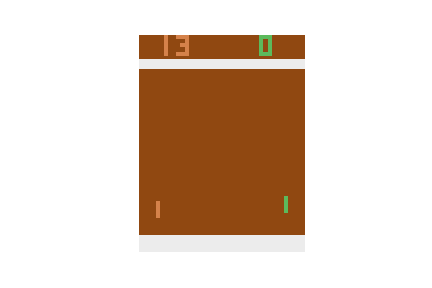
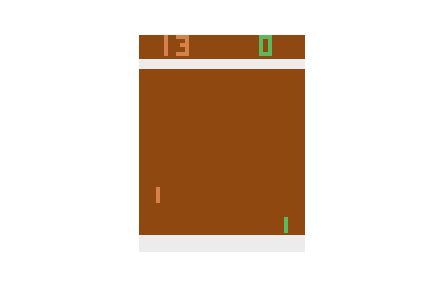
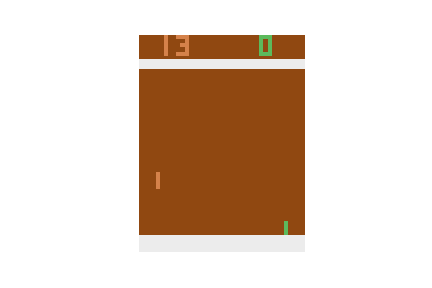
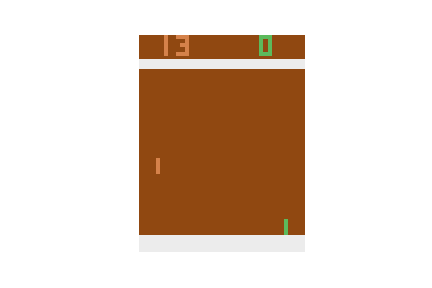
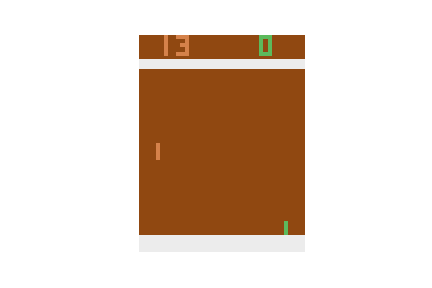
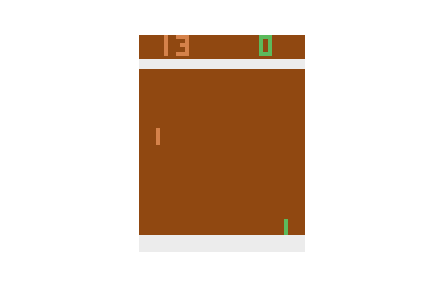
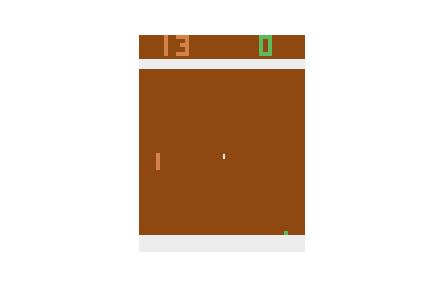
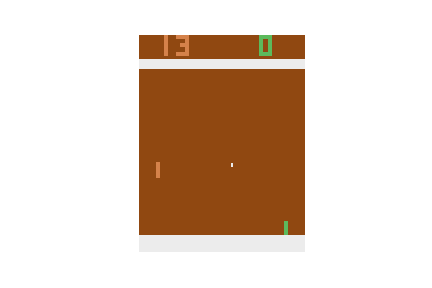
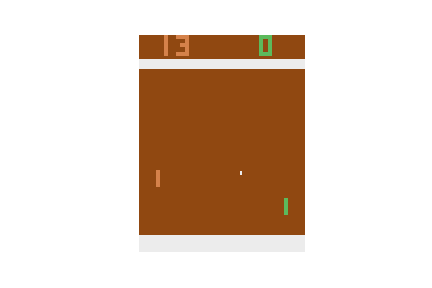
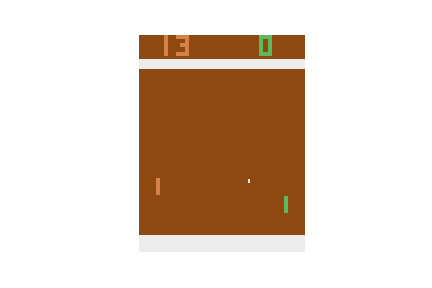
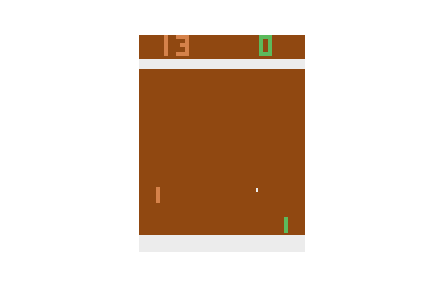
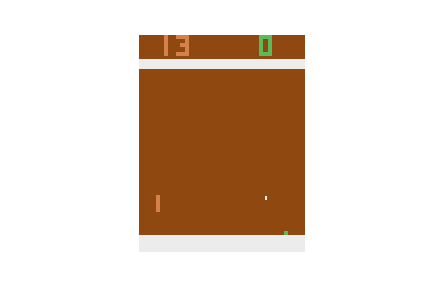
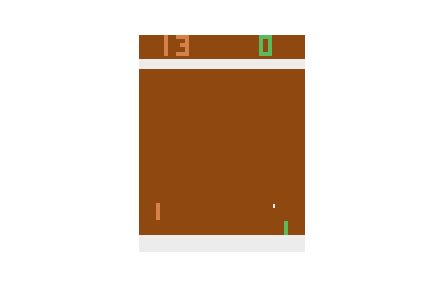
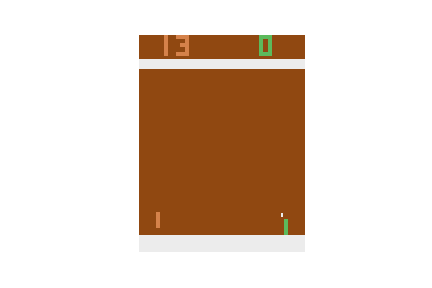
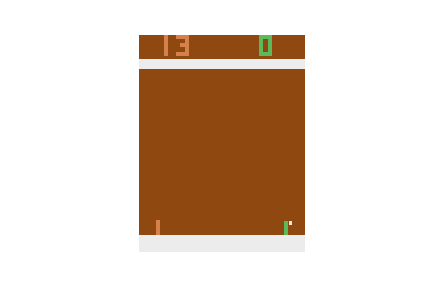
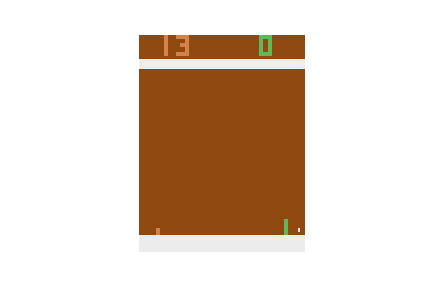
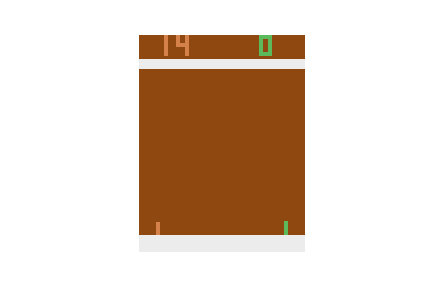
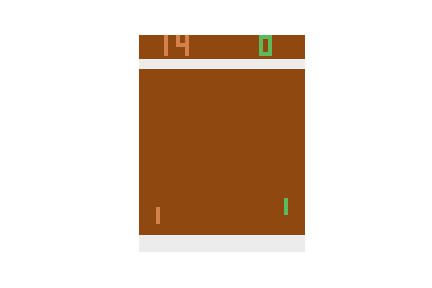
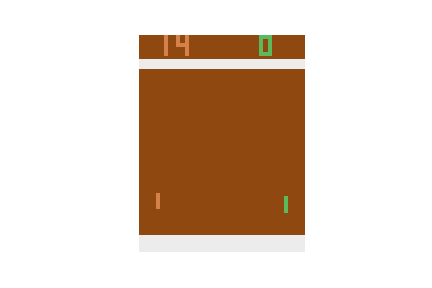
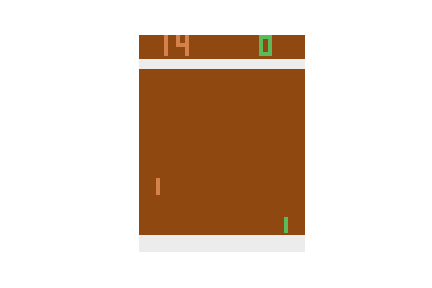
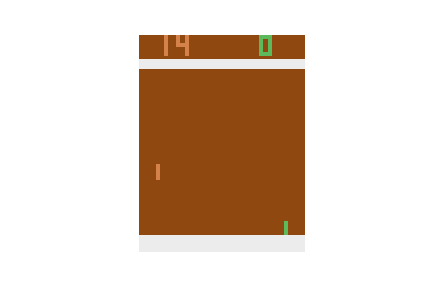
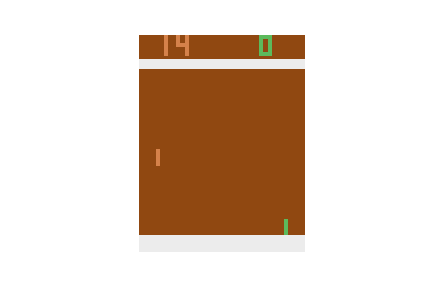
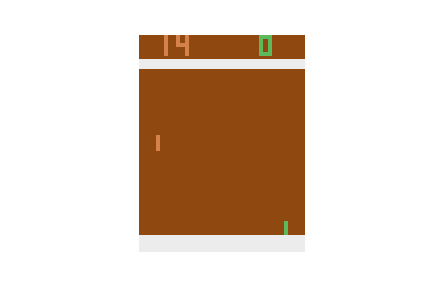
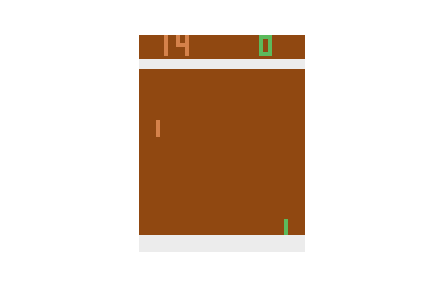
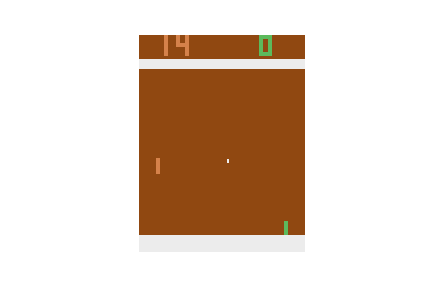
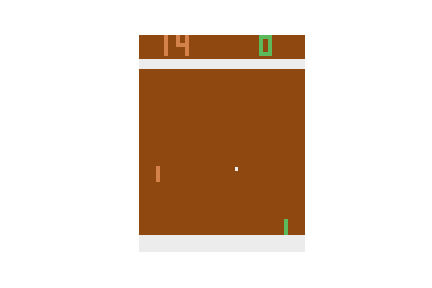
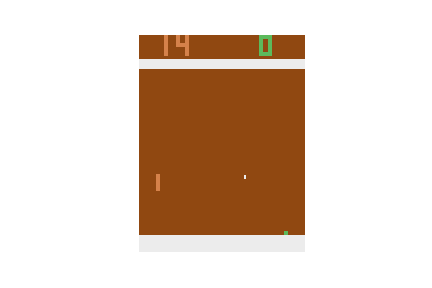
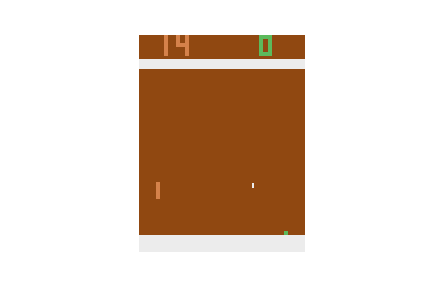
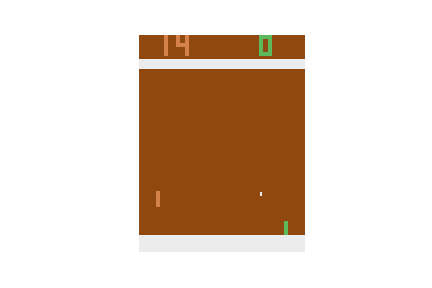
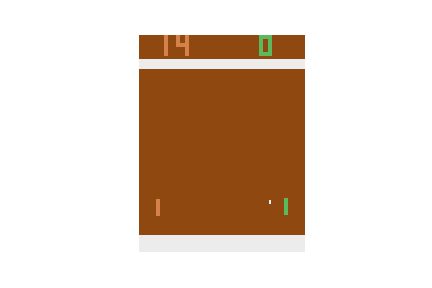
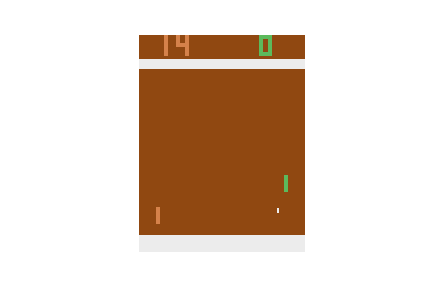
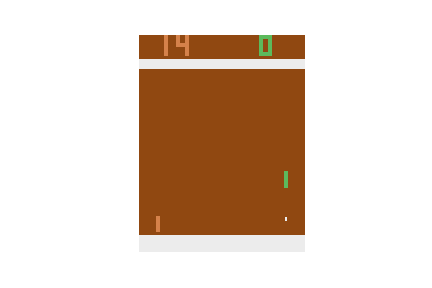
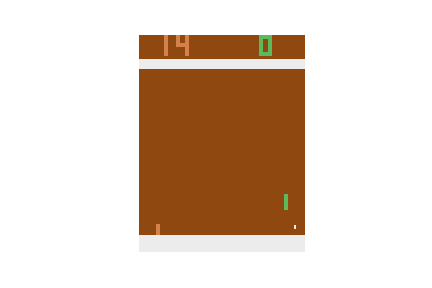
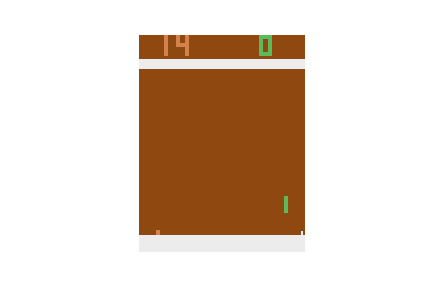
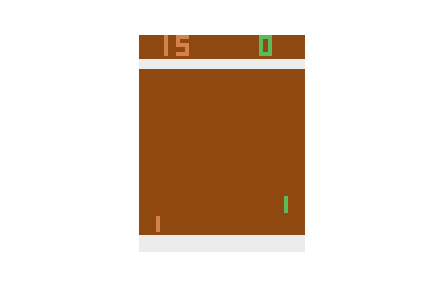
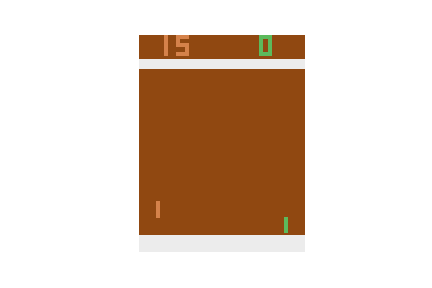
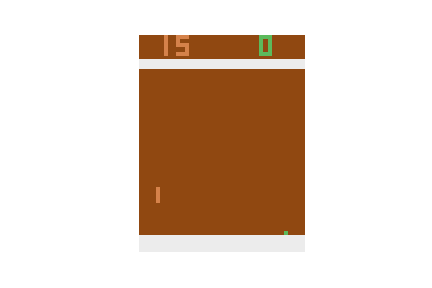
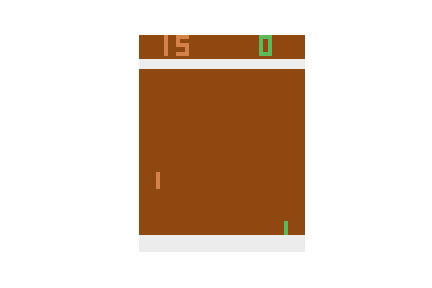
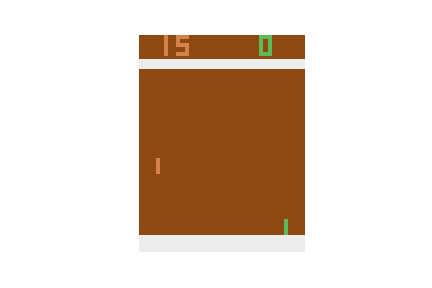
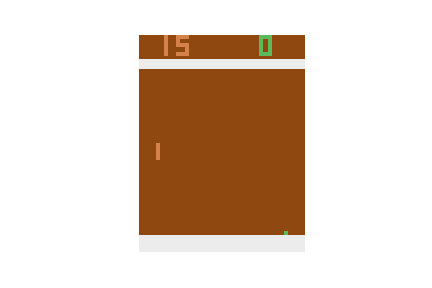
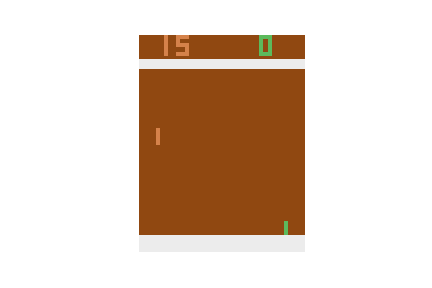
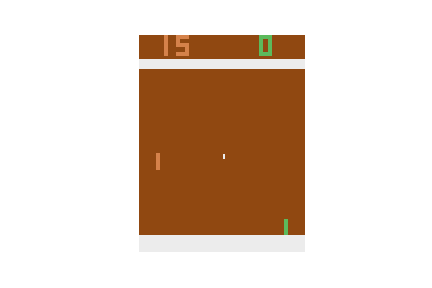
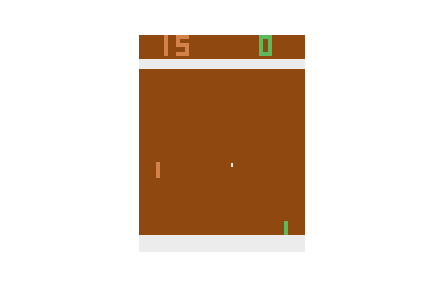
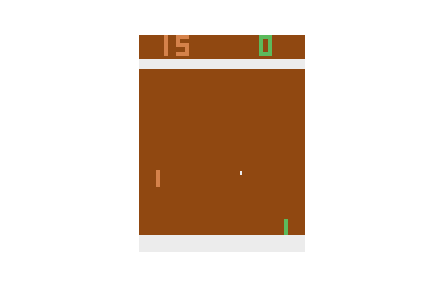
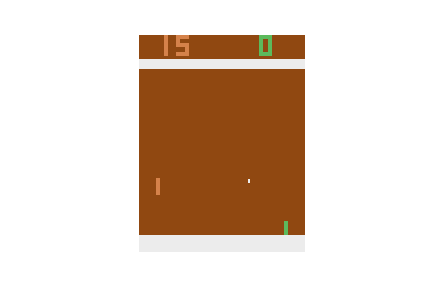
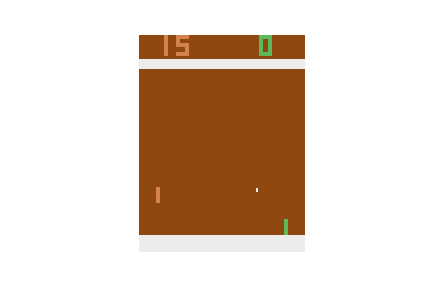
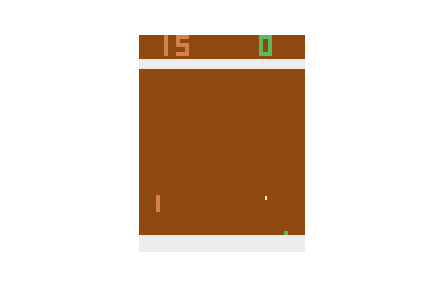
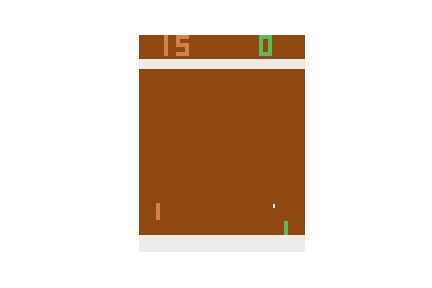
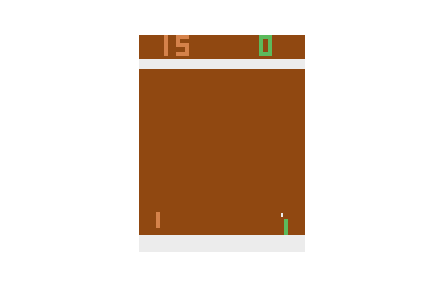
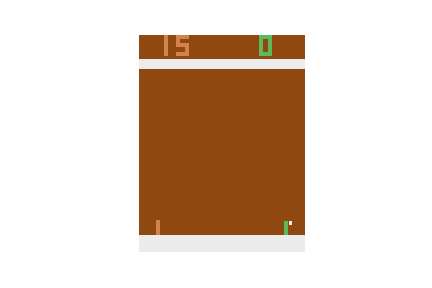
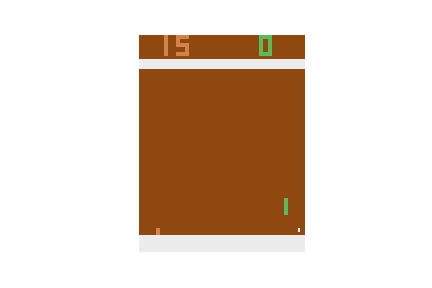
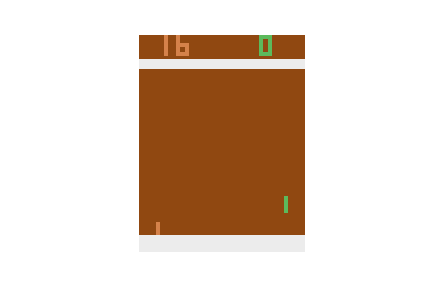
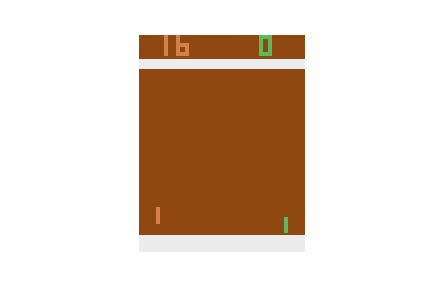
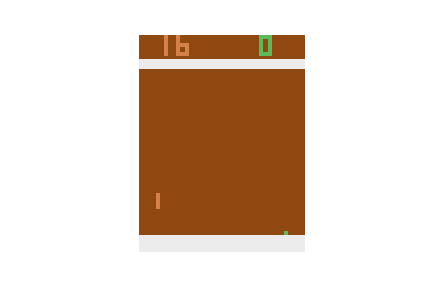
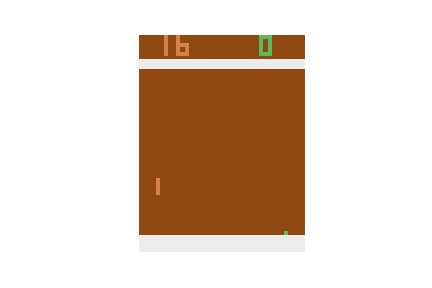
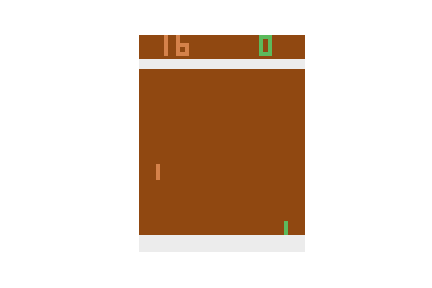
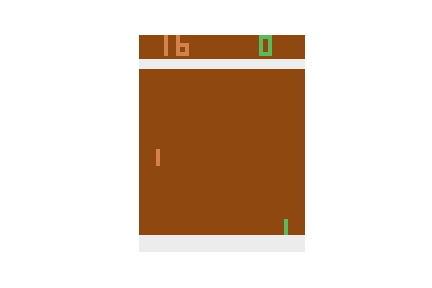
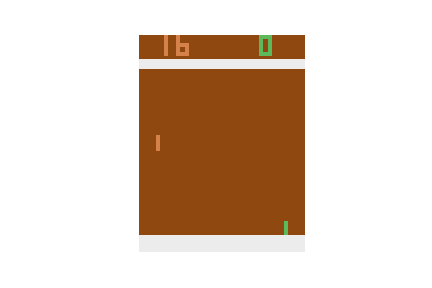
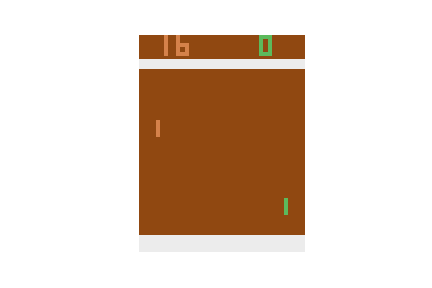
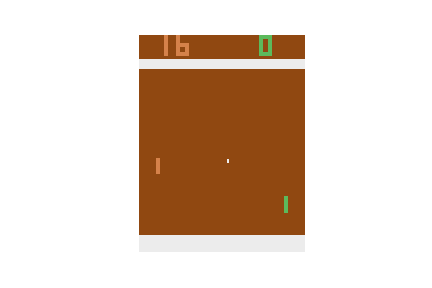
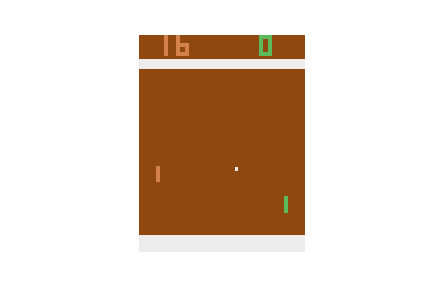
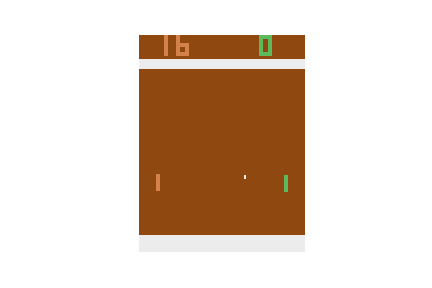
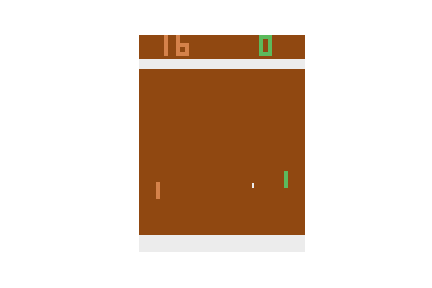
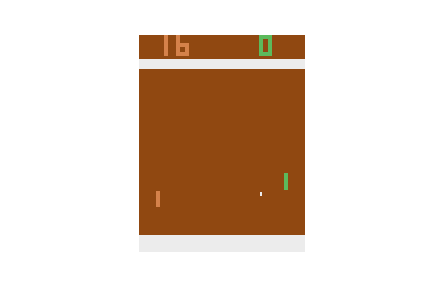
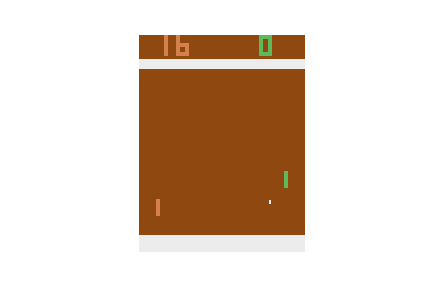
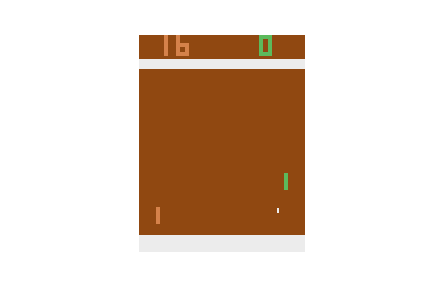
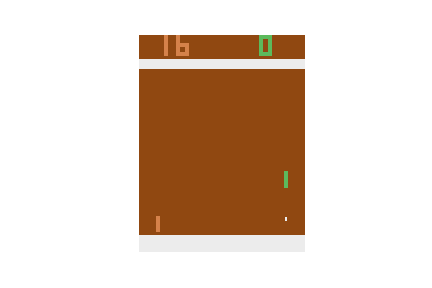
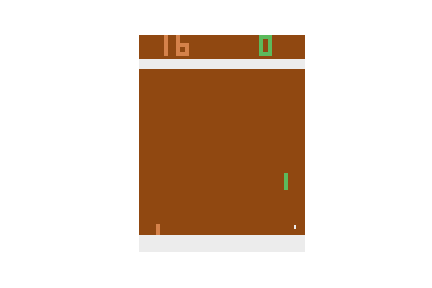
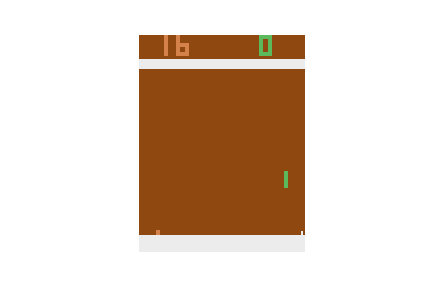
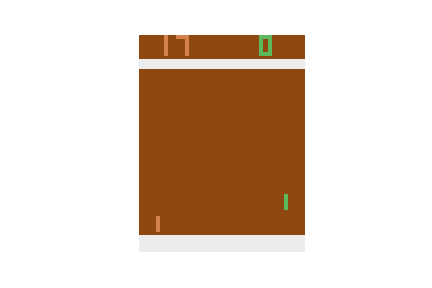
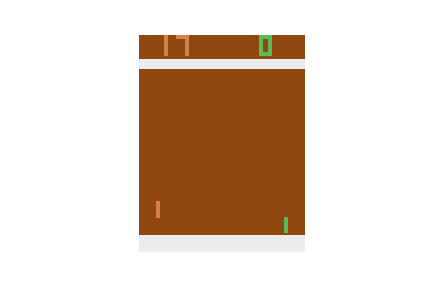
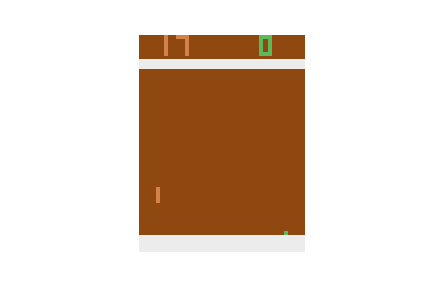
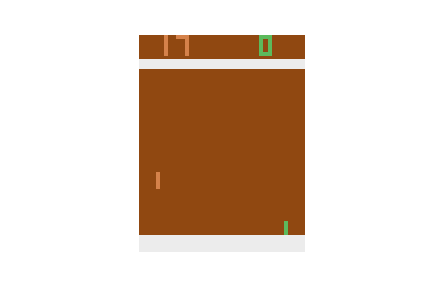
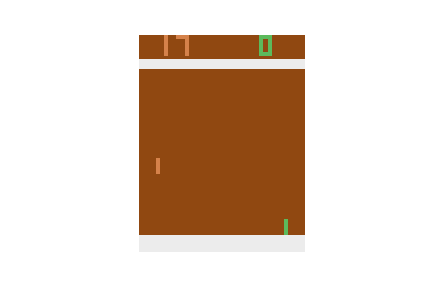
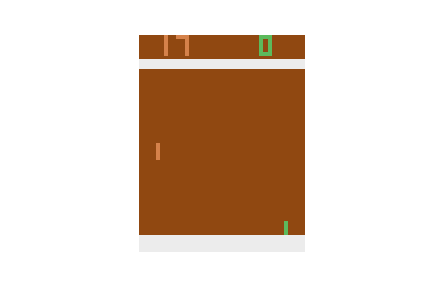
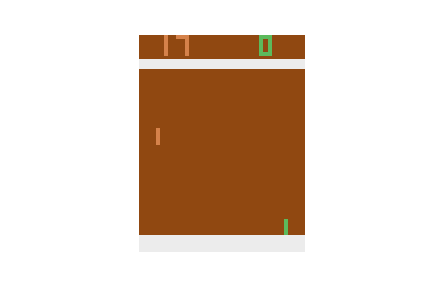
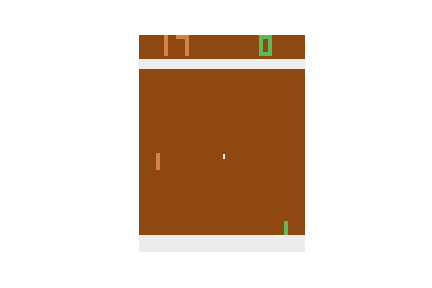
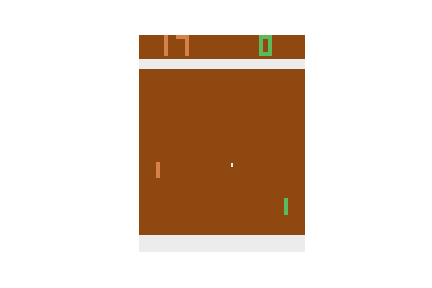
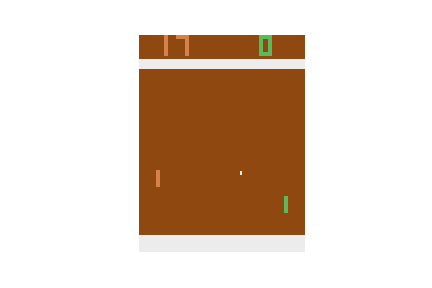
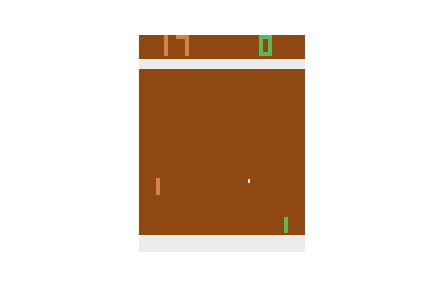
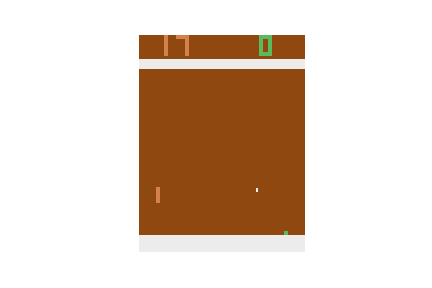
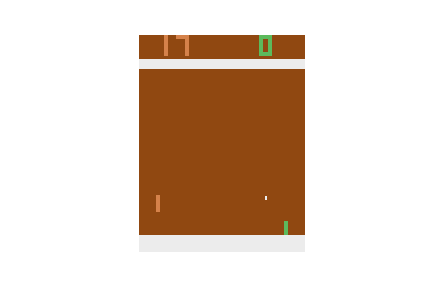
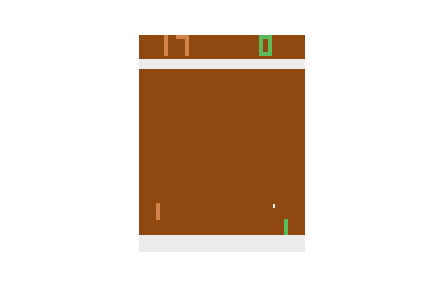
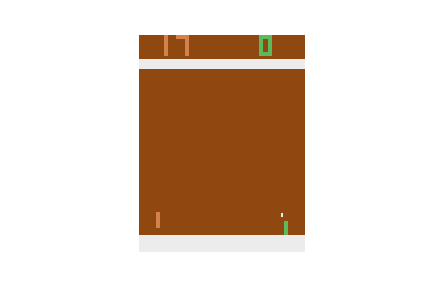
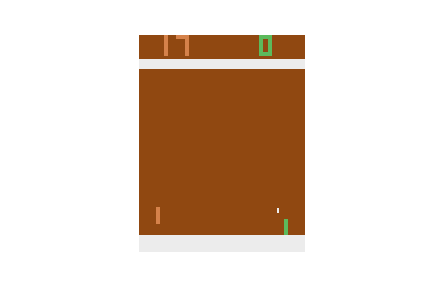
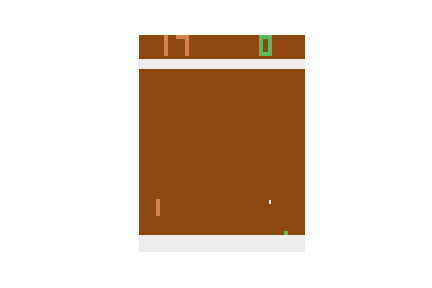
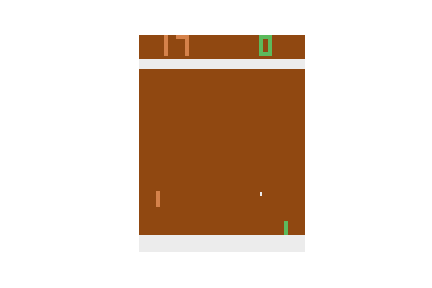
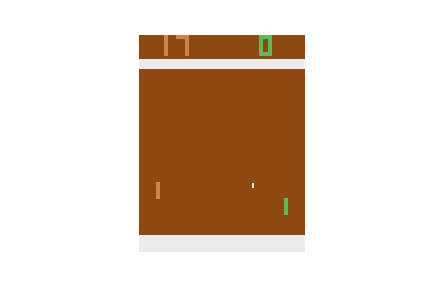
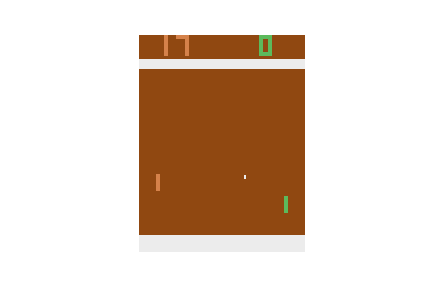
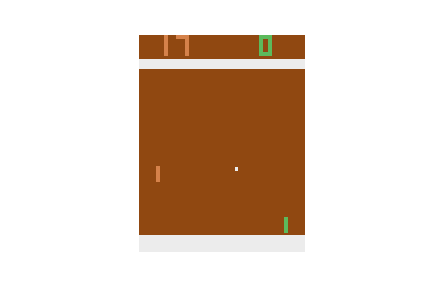
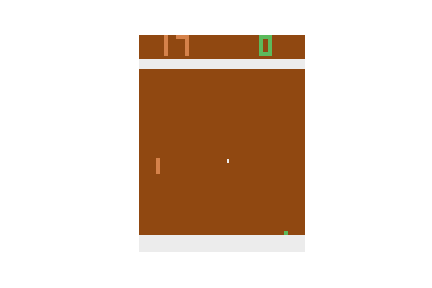
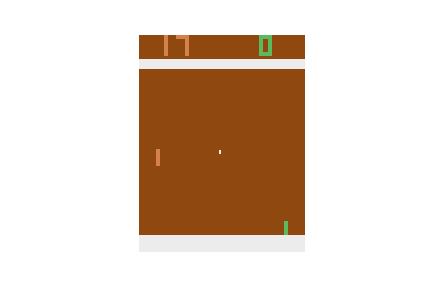
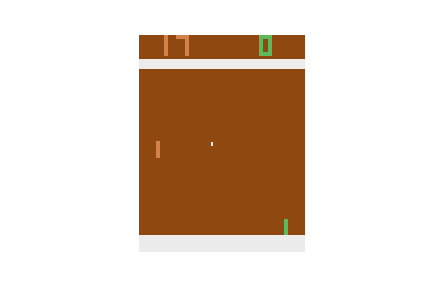
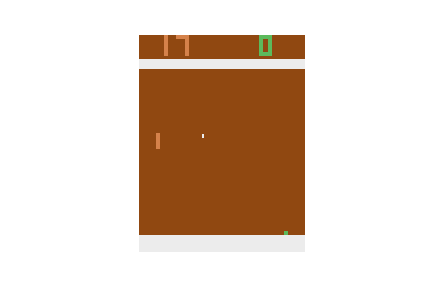
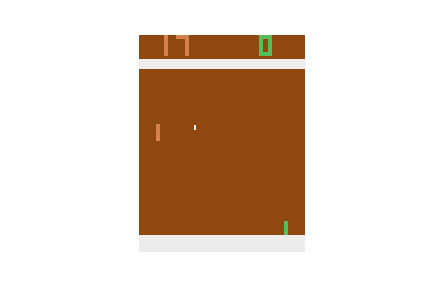
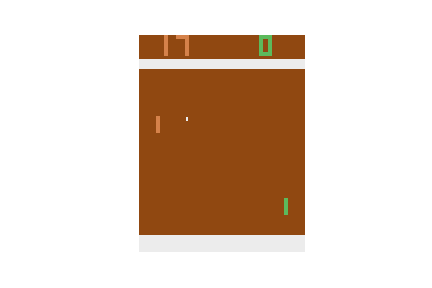
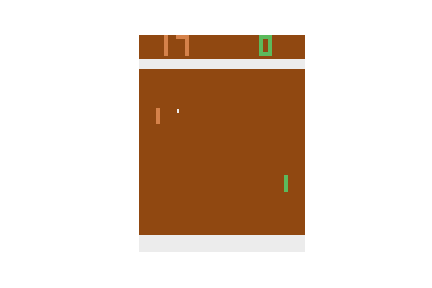
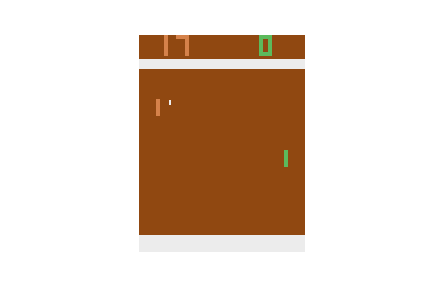
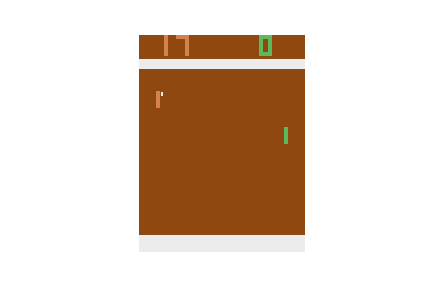
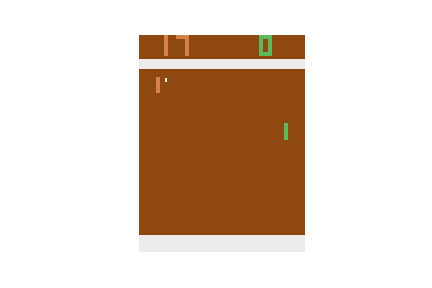
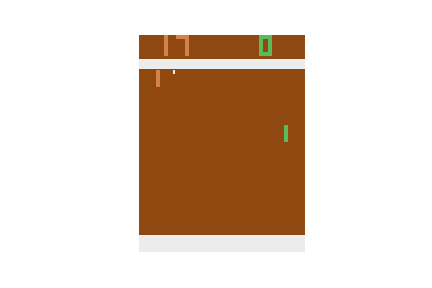
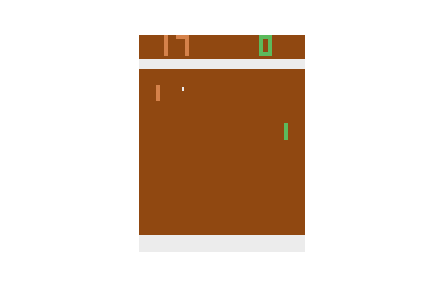
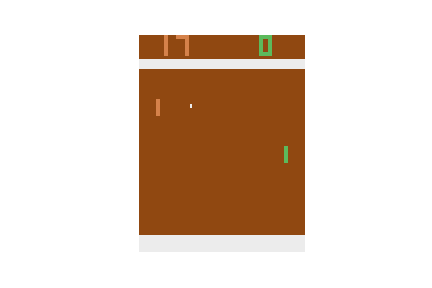
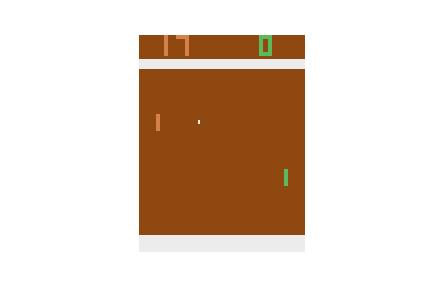
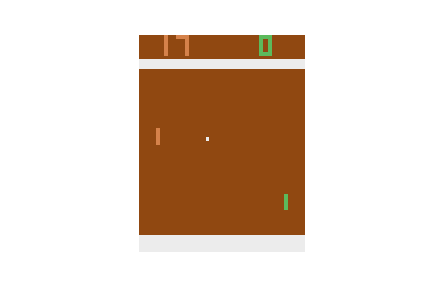
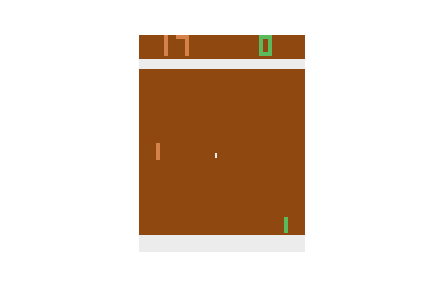
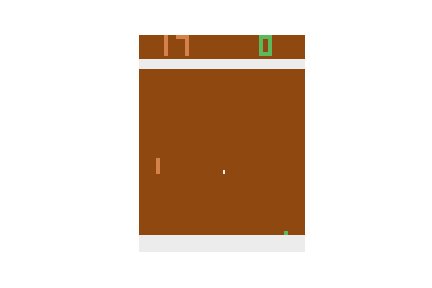
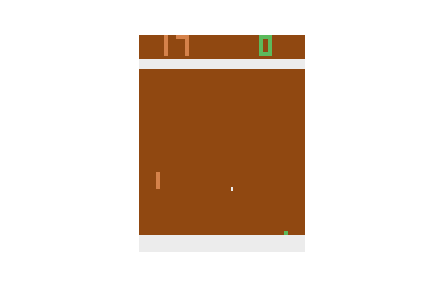
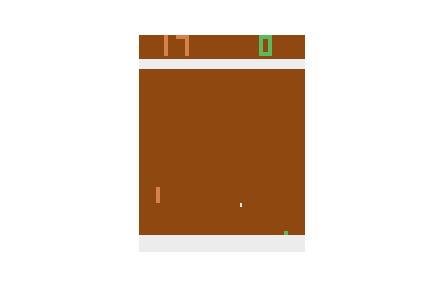
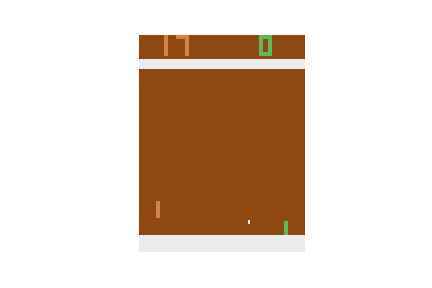
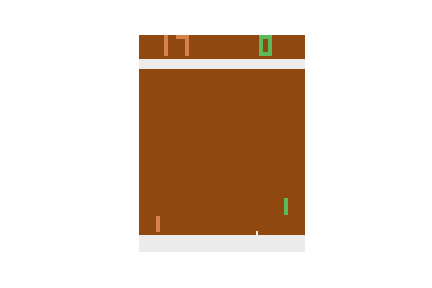
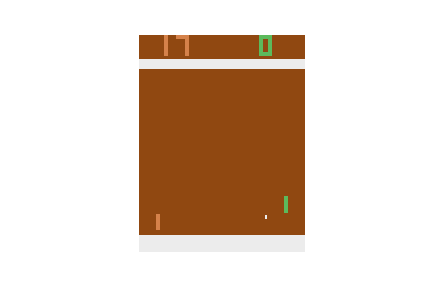
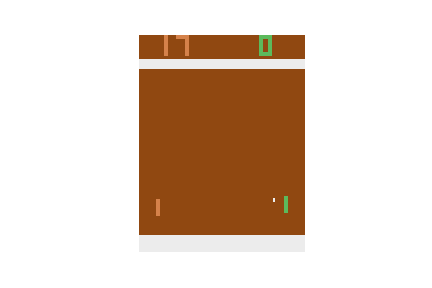
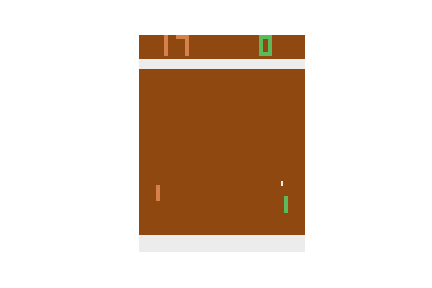
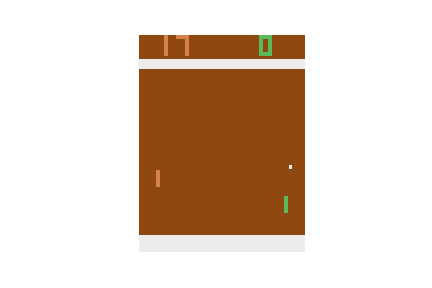
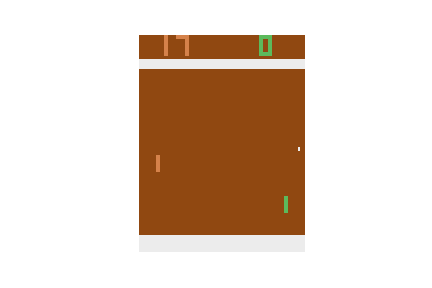
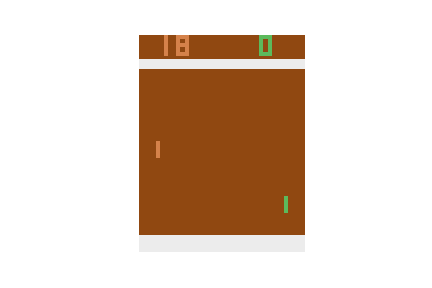
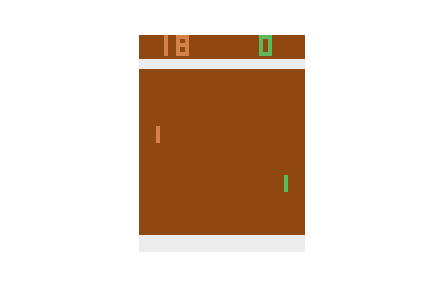
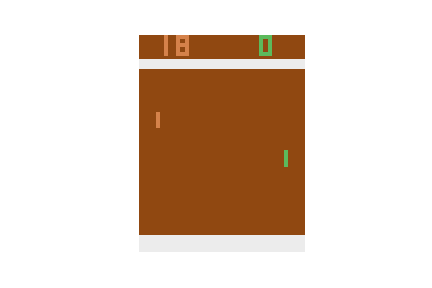
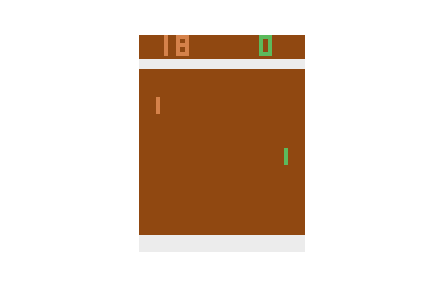
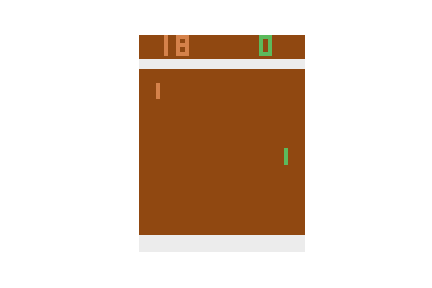
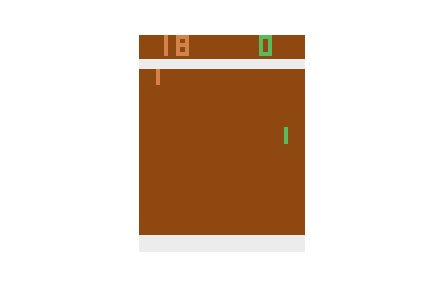
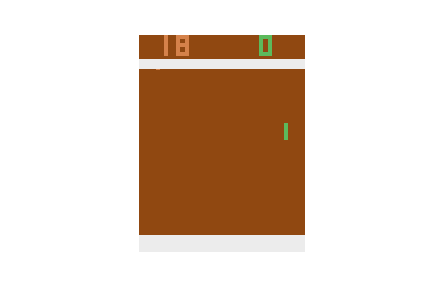
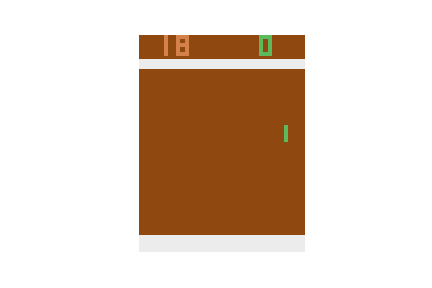
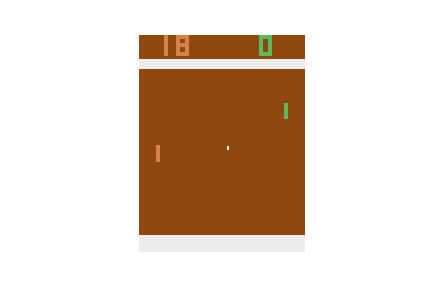
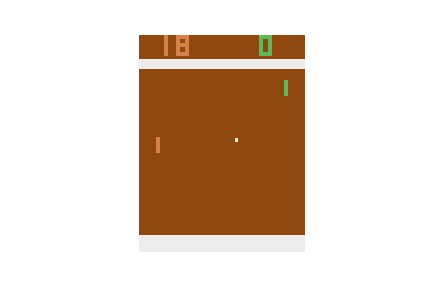
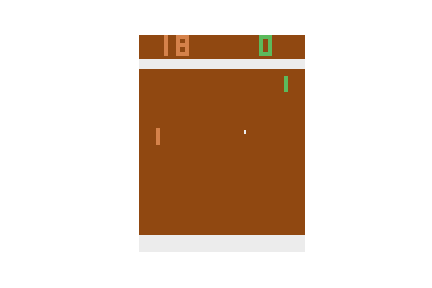
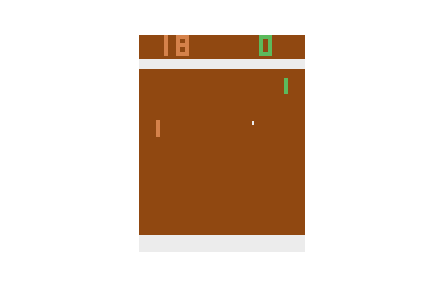
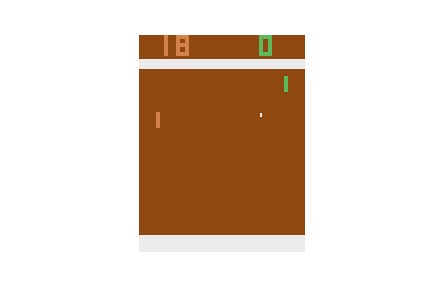
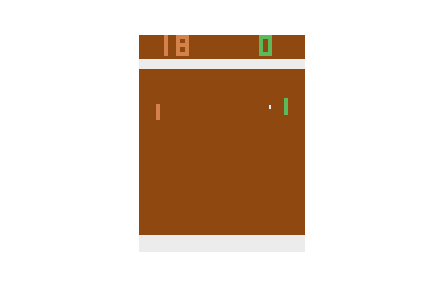
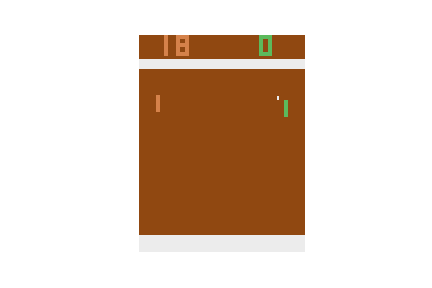
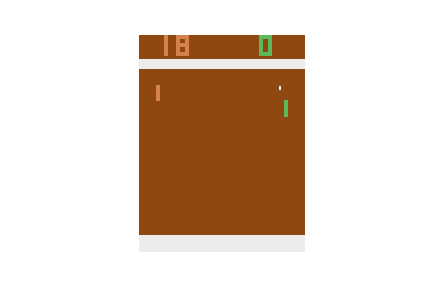
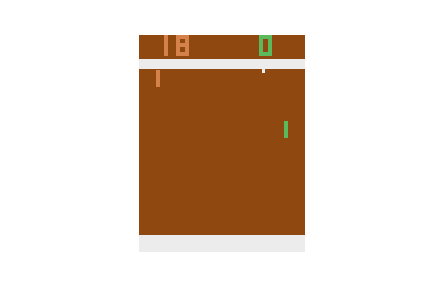
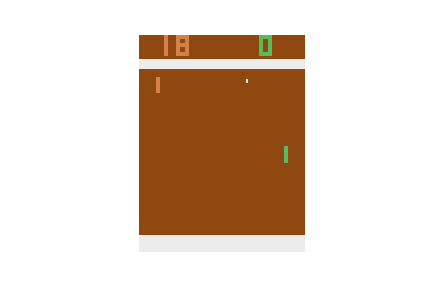
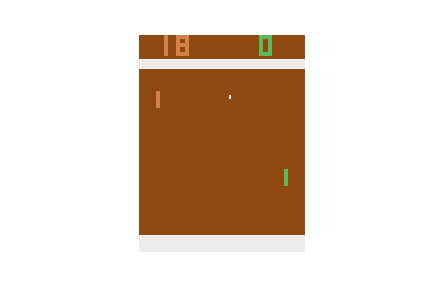
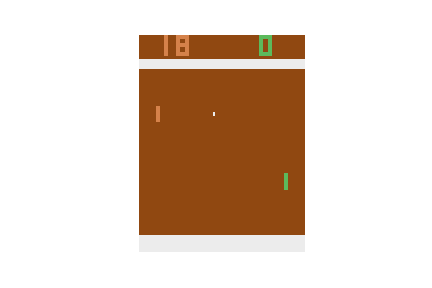
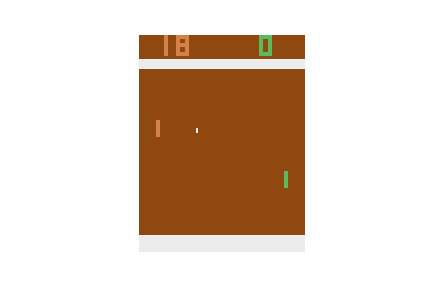
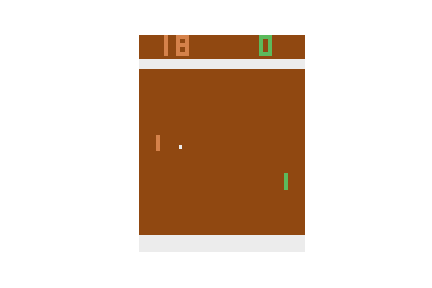
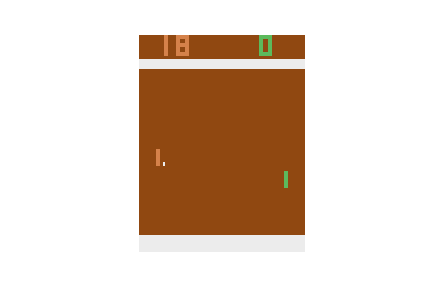
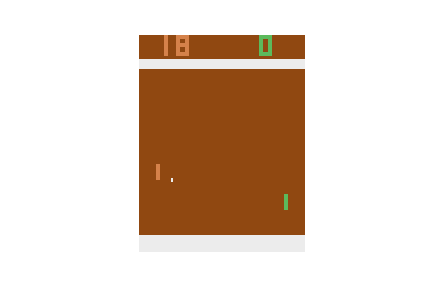
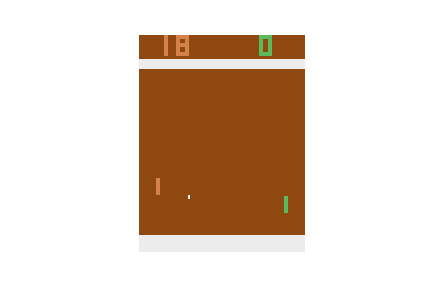
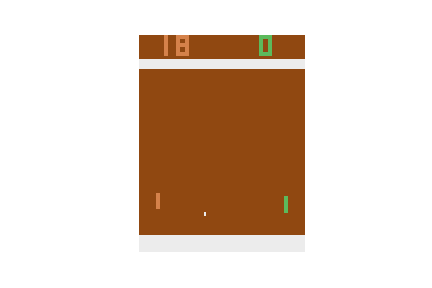
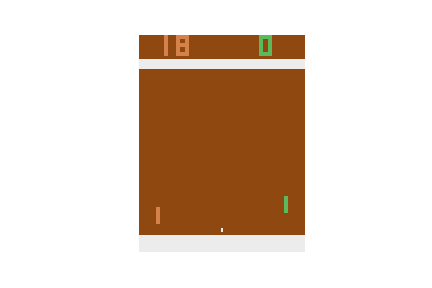
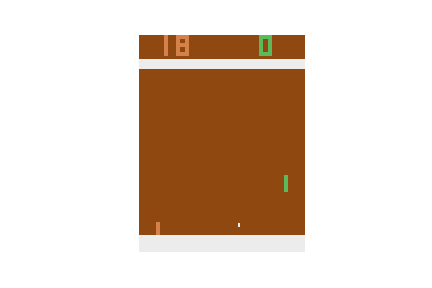
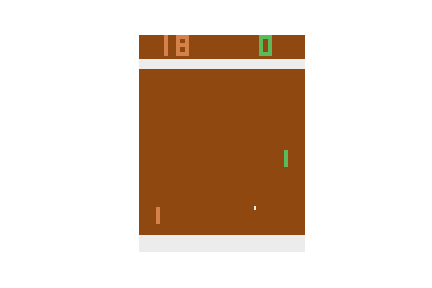
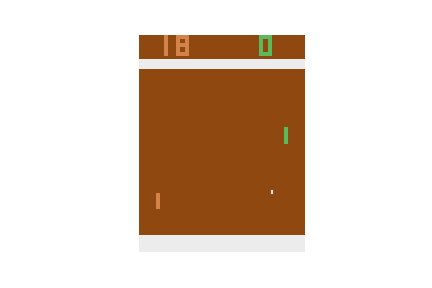
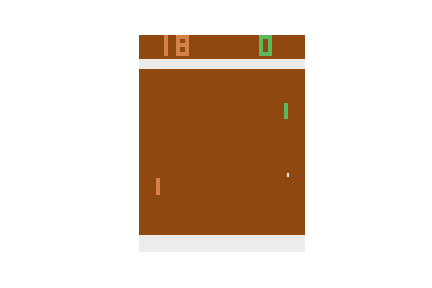
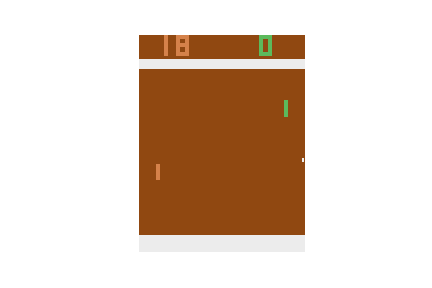
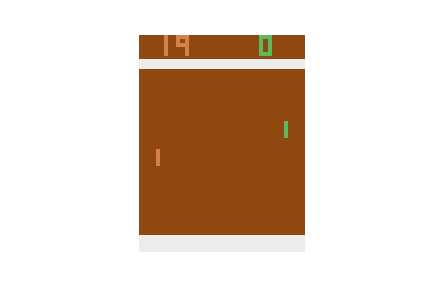
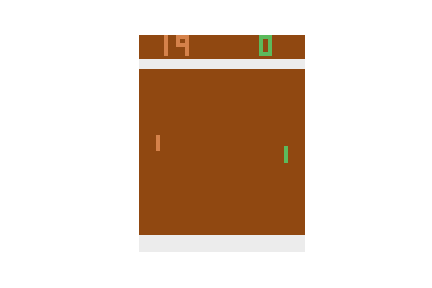
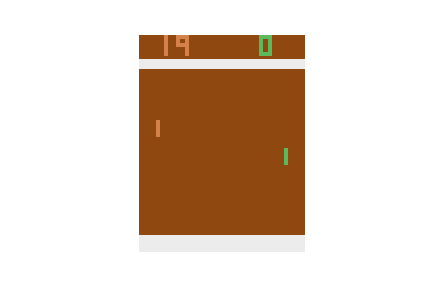
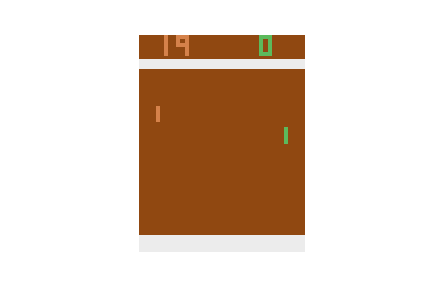
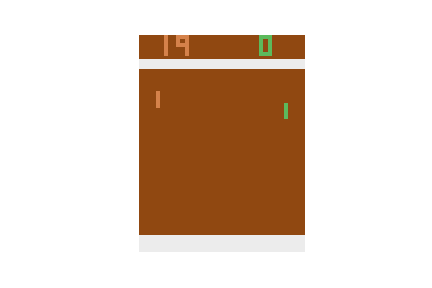
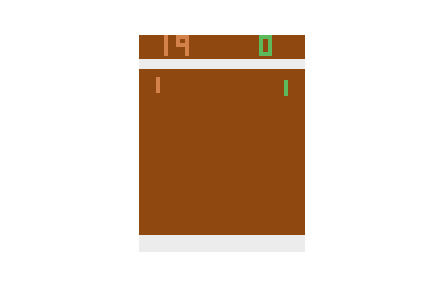
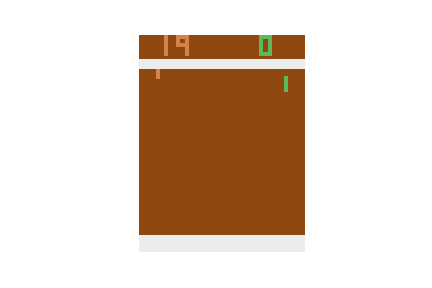
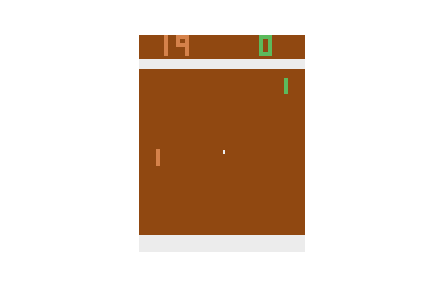
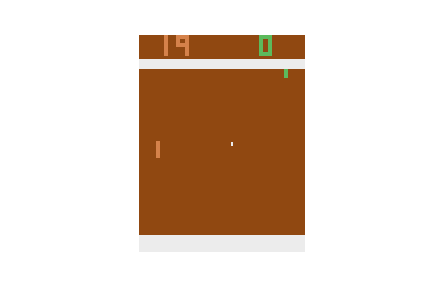
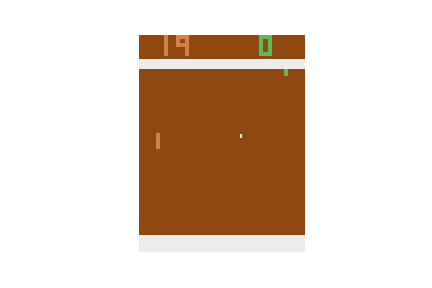
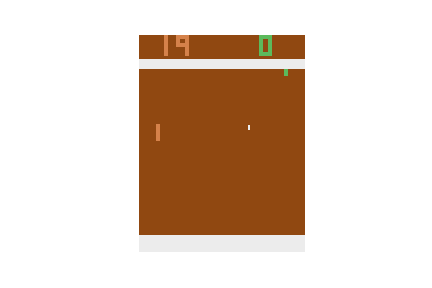
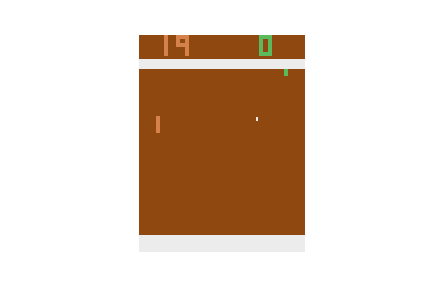
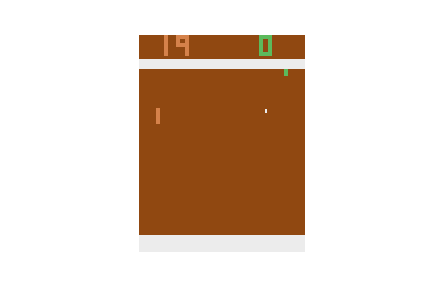
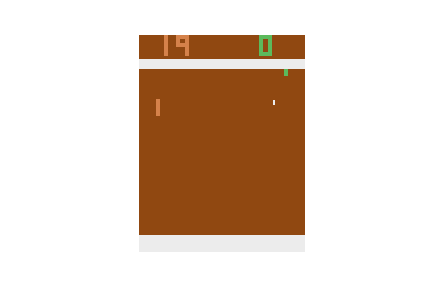
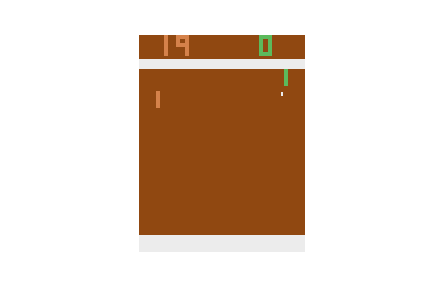
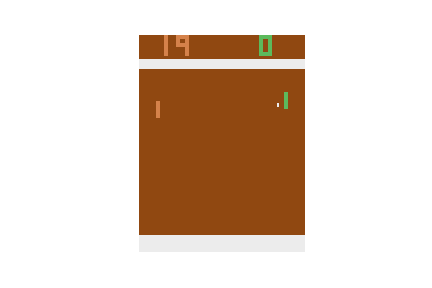
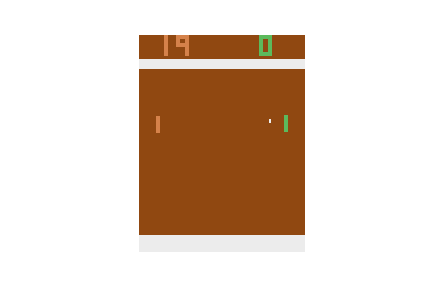
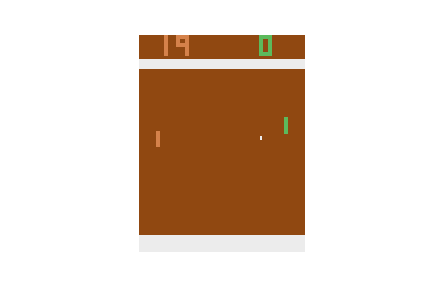
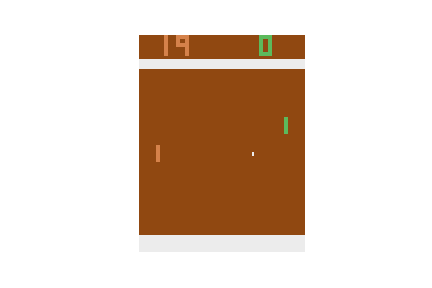
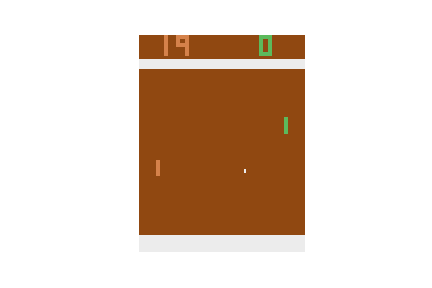
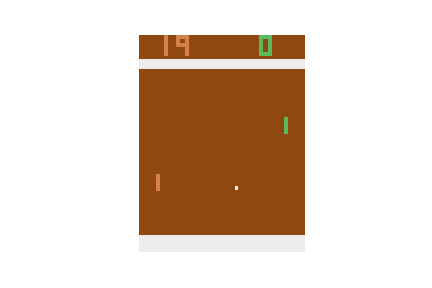
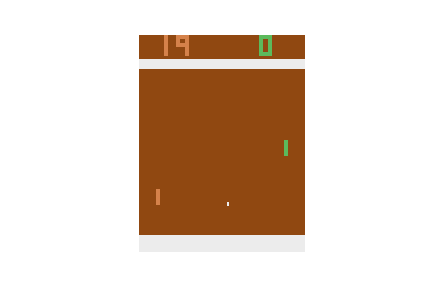
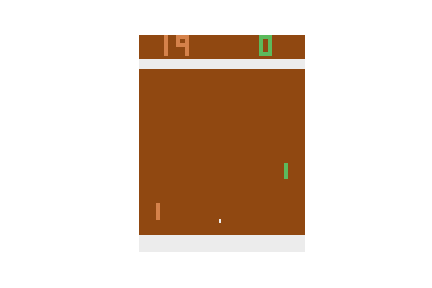
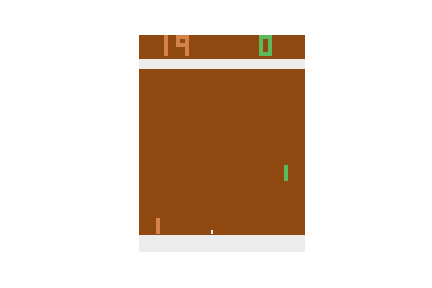
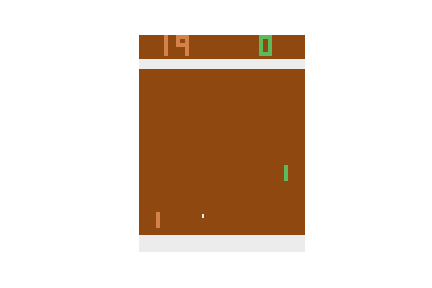
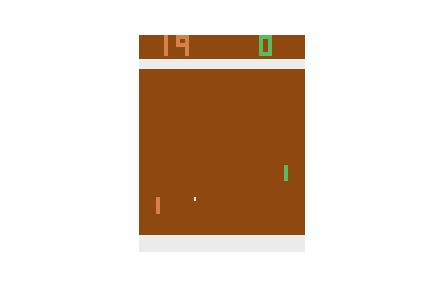
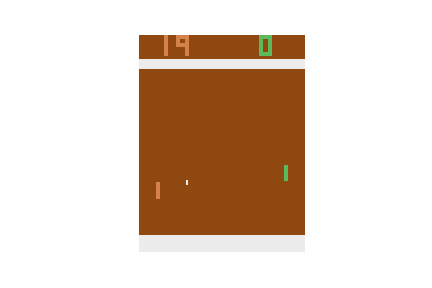
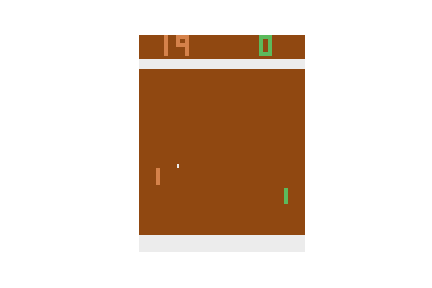
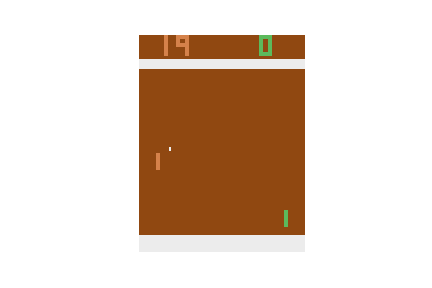
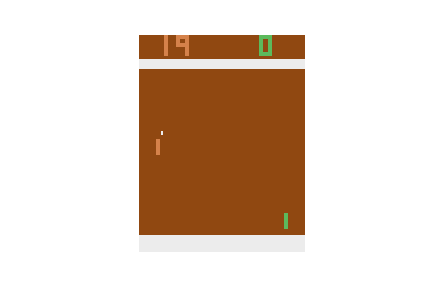
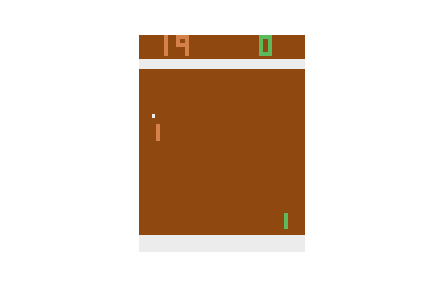
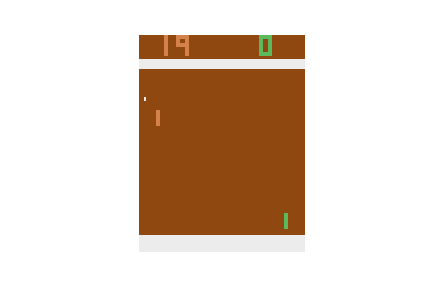
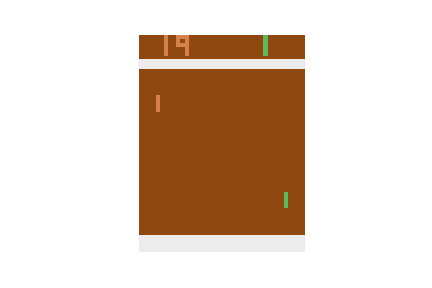
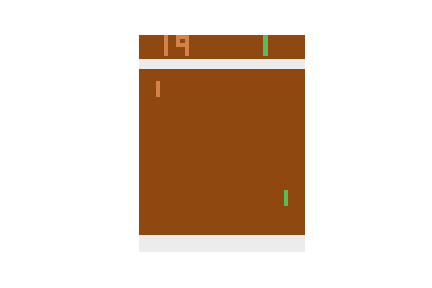
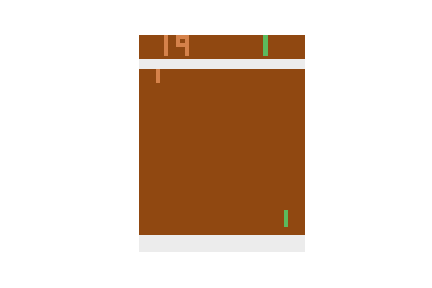
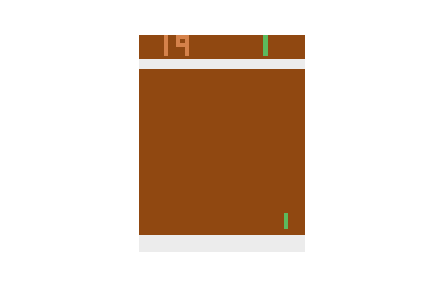
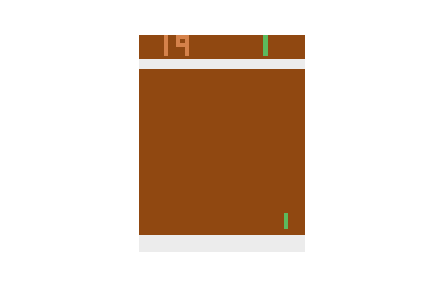
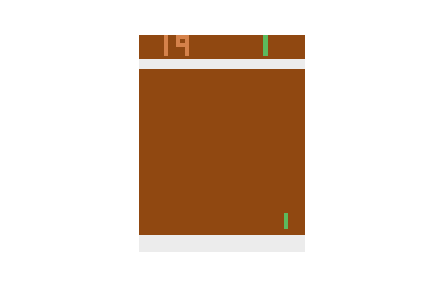
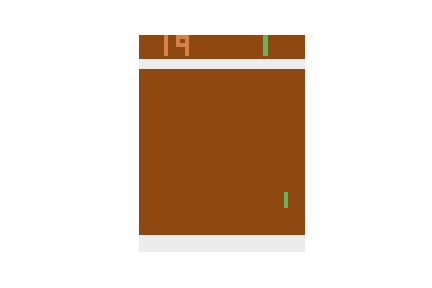
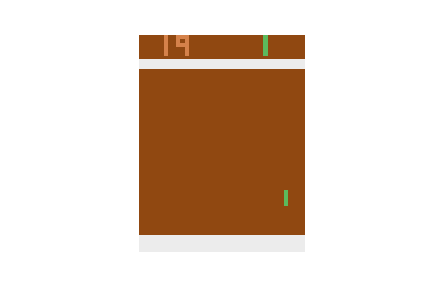
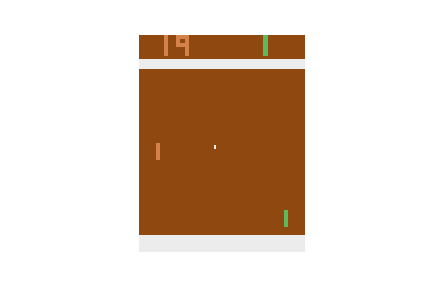
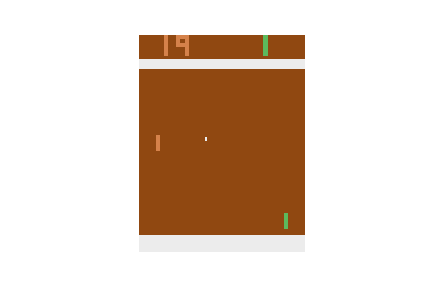
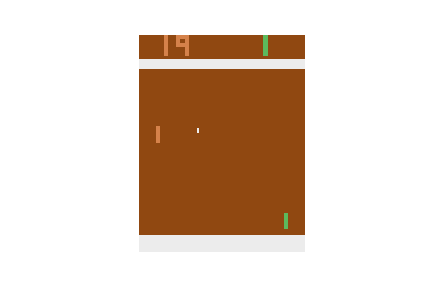
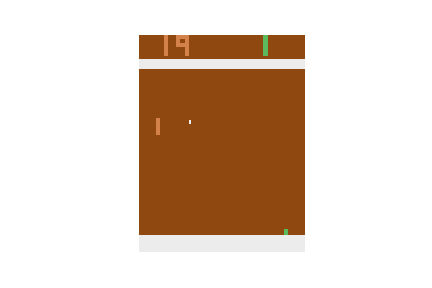
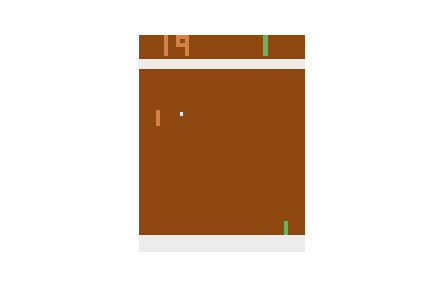
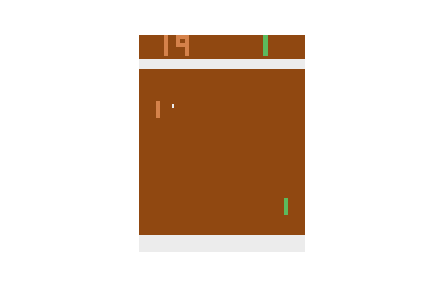
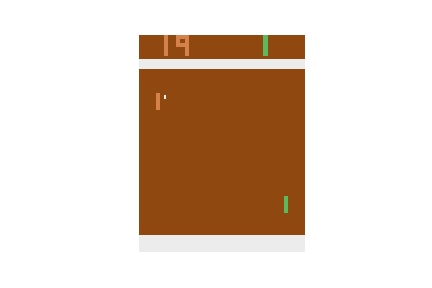
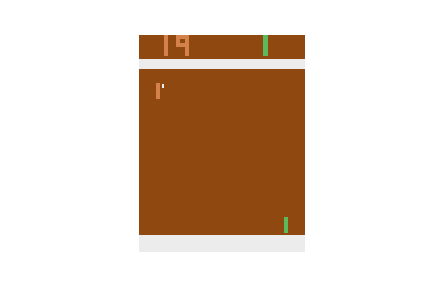
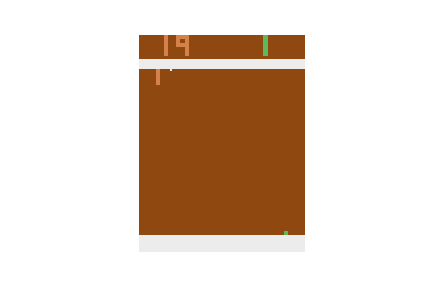
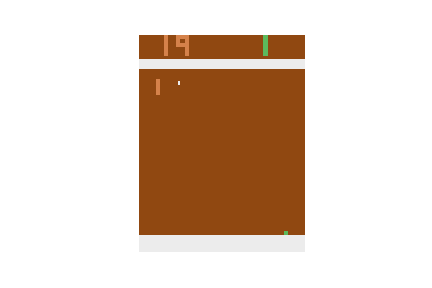
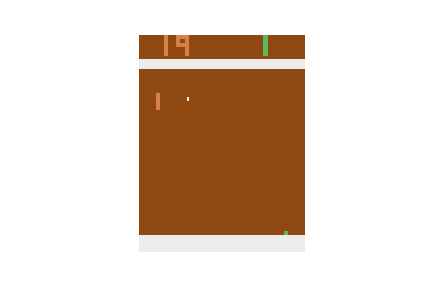
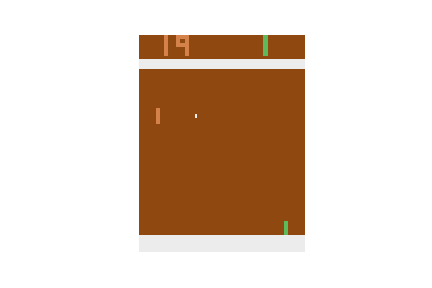
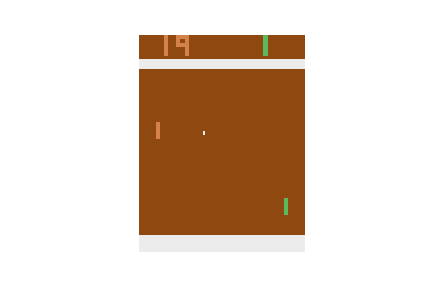
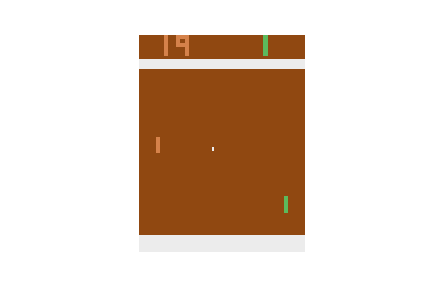
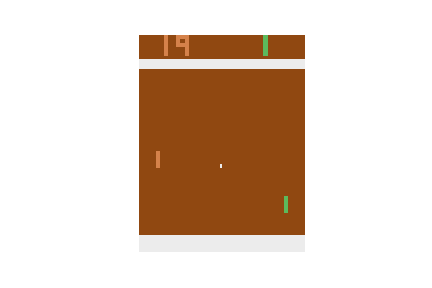
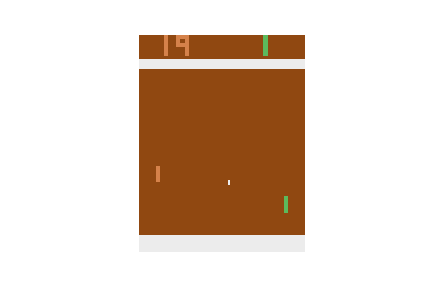
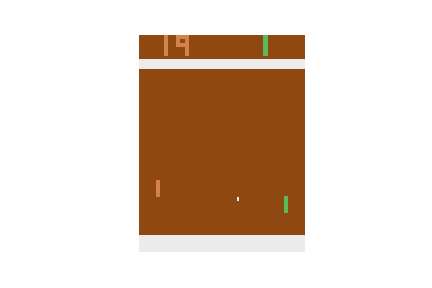
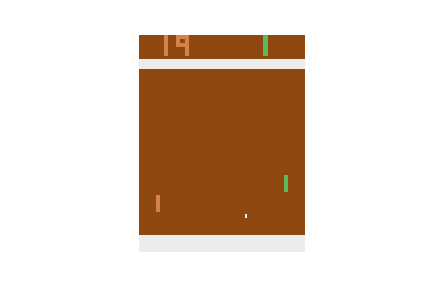
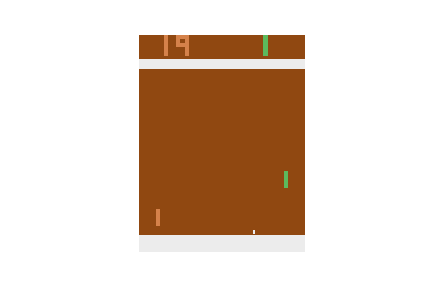
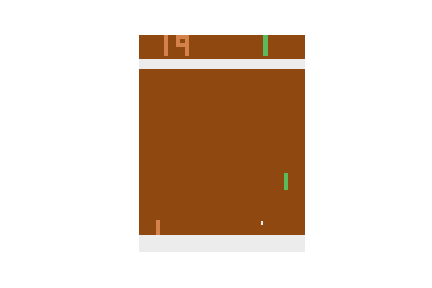
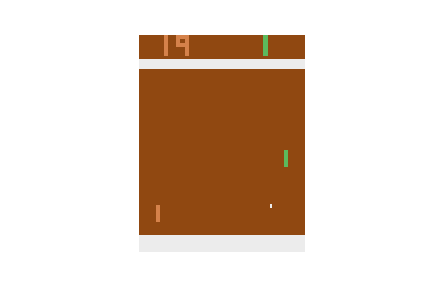
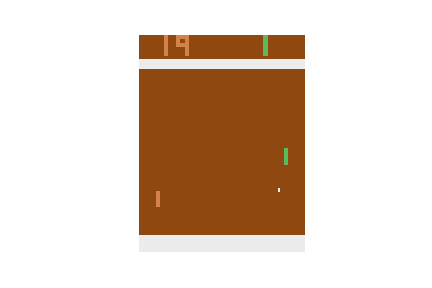
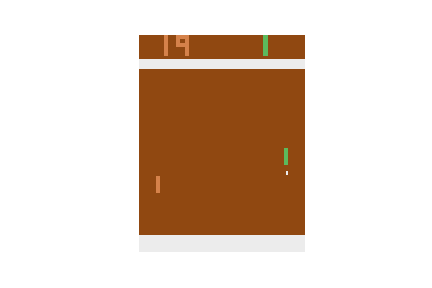
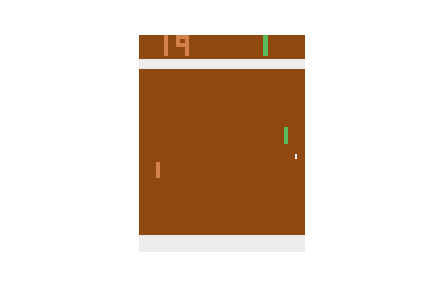
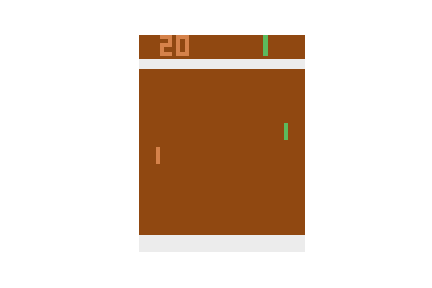
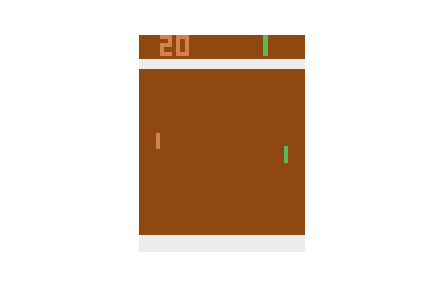
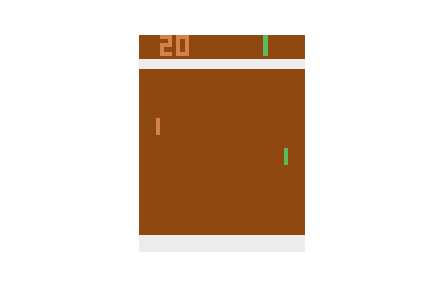
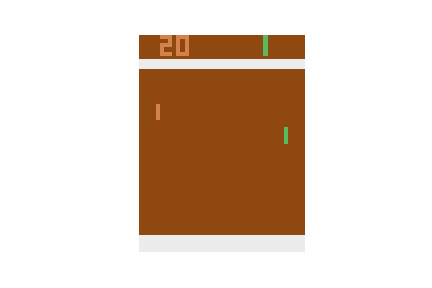
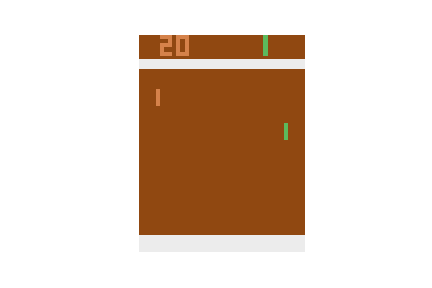
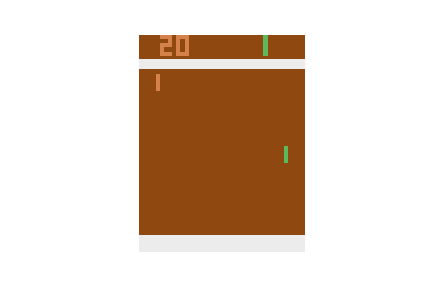
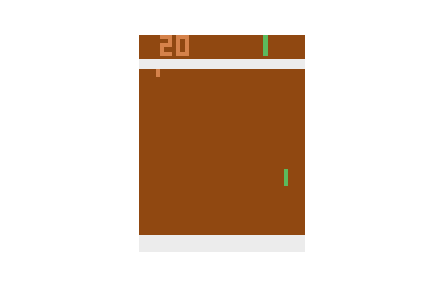
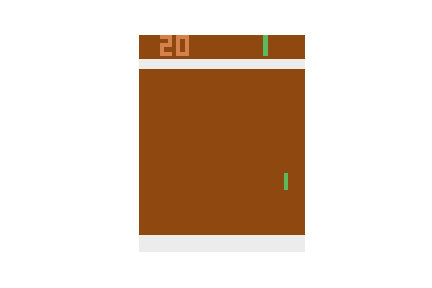
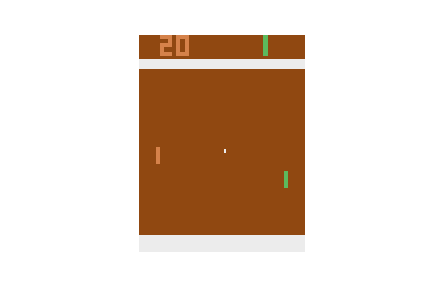
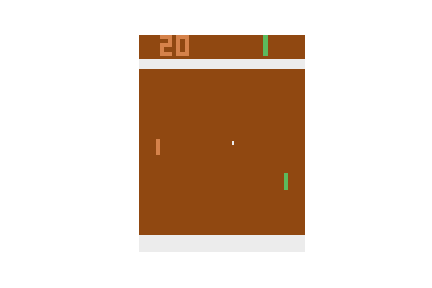
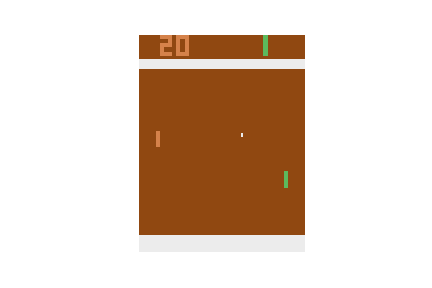
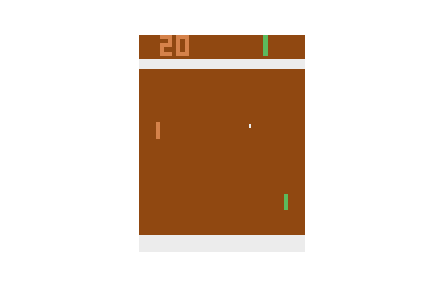
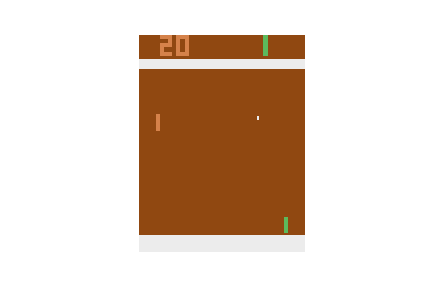
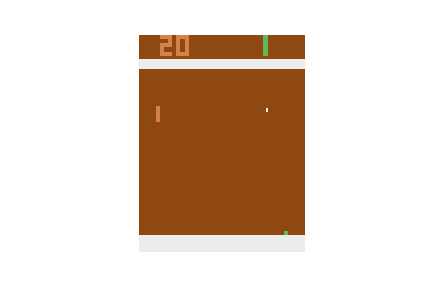
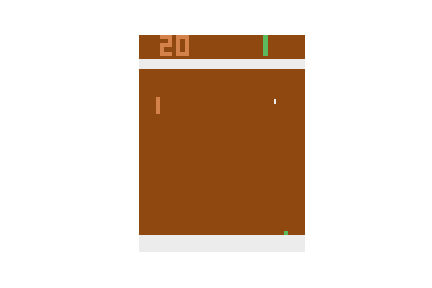
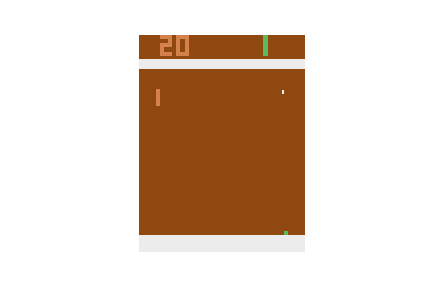
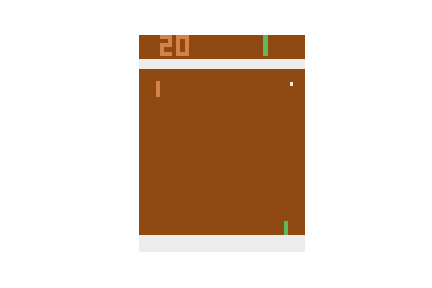
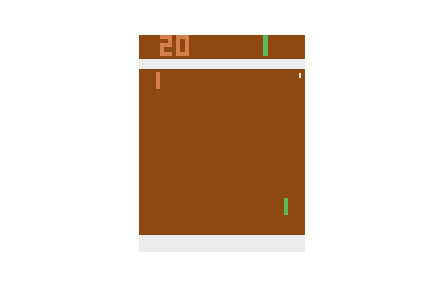

In [11]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

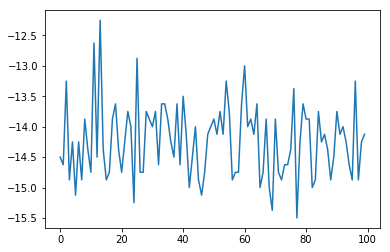

In [12]:
plt.plot(mean_rewards)

In [13]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
